In [1]:
import numpy as np
import pptk
import networkx as nx
import imageio
import glob
import re
from random import sample, seed
from scipy.spatial import distance
from time import strftime
import os
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
import time
import copy
from moving_least_square import *
from tempfile import TemporaryFile
from collections import defaultdict
from vpython import *
from math import *
scene = canvas()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
seed(20)
if os.name == 'nt': # Windows
    system_win = 1
else:
    system_win = 0

In [3]:
# Given the data points, return the MST of the point cloud generated from the PNG files and an array 
# of points positions
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#        drawMST: boolean value. Default is false. If set true, the function will also draw a MST graph at the end
#        sampleNumber: int value. Default is 5000. This function will only sample <sampleNumber> points from the data
# Return: a NetworkX graph representing the Minimum spanning tree of the data points

def getMSTFromDataPoint(data, drawMST: bool=False, sampleNumber: int=5000,  maxNeighborDis:int=10):
    # Read points data from PNGs 
    if(sampleNumber > len(data)):
        sampleNumber = len(data)
        
    # default sample 5000 points from the whole set, otherwise it would take too long
    print("---------------")
    print("There are " + str(len(data)) + " points in total. Now sampleling " + str(sampleNumber) + " points from them")
    sample_data = np.asarray(sample(list(data), sampleNumber))
    print("---------------")
    print("Done!")
    
    #display the points 
    #displayPoints(sample_data, 1.3)
    
    #Create a networkX graph instance that represent MST
    print("---------------")
    print("Begin creating a MST of the sampled points cloud")
    MST = CreateMSTGraph(sample_data, maxNeighborDis)
    print("---------------")
    print("MST creation Done!")
    
    if(drawMST):
        nx.draw(MST, dict(enumerate(sample_data[:, :2])))
        
    return (MST, sample_data)
    

In [4]:
# This function will invoke a pptk viewer to render the points 
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#       pointSize: the size of the point to be rendered on the screen
# Return: none

def displayPoints(data, pointSize):
    v = pptk.viewer(data)
    v.set(point_size=pointSize)

In [5]:
# This function will read a txt file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate should has the format of [x, y, z]
# Param: filePath: the file path of the txt file
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def readPointFromTXT(filePath):
    data = np.genfromtxt(fname=filePath, skip_header=0)
    return data

In [6]:
# This function will read a series of PNG file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate will have the format of [x, y, z]
# Param: filePath: the file path of the PNG files. Each file should be named as 1.png, 2.png, 3.png ... etc. All the png file should 
#                  be ordered by the their topological order from their original dicom file
#        orientation: 0, 1, or 2. 0 stands for coronal. 1 stands for transverse. 2 stands for sagittal.
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def ReadPointFromPNG(filepath, orientation:int, padding:int):
    print("---------------")
    print("Begin reading points data from PNG files")
    path_list = [im_path for im_path in glob.glob(filepath)]
    
    if system_win:
        path_list_parsed = [re.split('\\\\|\.', path) for path in path_list]
    else:
        path_list_parsed = [re.split('/|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    
    print("There are", len(path_list_parsed_valid),"PNG files, now convert them to point coordinates in 3D")
    imageData = []
    
    for path in path_list_parsed_valid:
        s = ""
        if system_win:
            s = "\\"
        else:
            s = "/"
        s = s.join(path)
        s = s[:-4] + '.png'
        image = imageio.imread(s)
        
        for i in range(padding):
            imageData.append(image)
    
    
    # Transfrom the matrix to list of points' coordinate whose grey scalse is not 0 (colon area)
    if(orientation == 0):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [1, 2, 0]]
        #xyz[:, 2] = xyz[:, 2]*3*thickness
        
    elif(orientation == 1):
        yxz = np.transpose(np.where(imageData))
        xyz = yxz[:, [1, 0, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
        
    elif(orientation == 2):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [0, 1, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
    
    else:
        print("Orientation shoud only be one of 0, 1 or 2 only.  0 stands for coronal. \
        1 stands for transverse. 2 stands for sagittal.")
        
    print("Done!")
    return xyz

In [7]:
# This function is used to limited the number of edges in the original graph.
# Instead of creating a graph with full connectivity, this function will return 
# a list of neighbor points for each point and we will only connect them in the graph
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# return: a tuple(closestIndices, closesDis). ClosestIndices is a matrix of each point's neighbors. 
#         closestDis is a matrix of the distances between each point and their neighbors

def getNearbyPoints(pointsData, maxNeighborDis):
    D = distance.squareform(distance.pdist(pointsData))
    closestIndicies = np.argsort(D, axis=1)
    closestDis = np.sort(D, 1)
    threshold = maxNeighborDis # This number can be changed. The greater this number, the more edges
    return (closestIndicies[:, 1:threshold], closestDis[:, 1:threshold])

In [8]:
# This function converts points' coordinate data into a minimum spanning tree. In this graph, the nodes are the points
# from the points cloud and the edges are the connection between each point and their neighbors. The weights are each 
# connection's distance in space
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# Return: A networkX instance containing the MST

def CreateMSTGraph(pointsData, maxNeighborDis):
    print("---------------")
    print("Begin calculating nearby points for each point")
    nearbyInfo = getNearbyPoints(pointsData, maxNeighborDis)
    closestIndicies = nearbyInfo[0]
    closestDis = nearbyInfo[1]
    print("---------------")
    print("Nearby points calculation Done! Total:", closestIndicies.shape[0], "points,",\
          closestIndicies.shape[1]*closestIndicies.shape[0],"edges.")
    print("---------------")
    print("Begin construct graph")
    G=nx.Graph()
    
    grid = np.indices(closestIndicies.shape)
    VEStack = np.stack((grid[0], closestIndicies, closestDis), axis=-1)
    VEList = VEStack.reshape(VEStack.shape[0]*VEStack.shape[1], 3).tolist()
    VETupleList = [(int(x[0]), int(x[1]), x[2]) for x in VEList]
    
    G.add_weighted_edges_from(VETupleList)
    
    '''
    for firstPIndex in range(len(closestIndicies)):
        for second in range(len(closestIndicies[firstPIndex])):
            secondPIndex = closestIndicies[firstPIndex][second]
            G.add_edge(firstPIndex, secondPIndex , weight = closestDis[firstPIndex][second])
    '''     
    print("---------------")
    print("Graph construction Done!")
    print("---------------")
    print("Begin calculate MST")
    G = nx.minimum_spanning_tree(G)
    print("---------------")
    print("MST calculation Done!")
    return G

In [9]:
# Impliment the collect algorithm for 3D points in the paper. This is a recursive function which may not be efficient 
# enough for the project. The non-Recursive version is right below.

def collectPoints1(P: int, PStar: int):
    global H_glo
    global graph
    global pointsCor3D
    global A

    A.append(P)
    for edge in graph.edges(P):
        Pj = edge[1]
        if(Pj) not in A and distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar]) < H_glo:
            collectPoints1(Pj, PStar)

In [10]:
# This function will collect the neighbors of PStar and return a list of this points's index
# Param: PStar: the index of the point that we want to find its neighbors
#        H: the searching range for the neighbors
# Return: A: A set of points' indicies representing the neighbors
# This function will also maintain the dictionary of the distance between points and the weight 
# between points. 

def collectPointsNonrec(PStar: int, H:int):
    
    global graph
    global pointsCor3D
    global distance_dict 
    global dirty_dict
    global weight_dict
    
    toExplore = [PStar]
    A = [PStar]
    distance_dict[(PStar, PStar)] = 0
    weight_dict[((PStar, PStar))] = 1
    
    while len(toExplore) > 0:
        curP = toExplore[0]
        del toExplore[0]
        for Pj in graph.neighbors(curP):
            if(Pj) not in A:
                
                # Maintain the dictionary of distance and weight between points
                if (Pj, PStar) not in distance_dict or (PStar, Pj) not in distance_dict or \
                dirty_dict[PStar] == 1 or dirty_dict[Pj] == 1:
                    dist_temp = distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar])
                    distance_dict[(Pj, PStar)] = dist_temp
                    distance_dict[(PStar, Pj)] = dist_temp
                    weight_dict[((PStar, Pj))] = weightFun(PStar, Pj)
                    weight_dict[((Pj, PStar))] = weightFun(PStar, Pj)
                    dirty_dict[Pj] = 0
                    dirty_dict[PStar] = 0
                    
                if distance_dict[(Pj, PStar)] < H:
                    toExplore.append(Pj)
                    A.append(Pj)
    return A

In [11]:
# This function will collect the neighbors of PStar and return a list of this points's index
# Param: PStar: the index of the point that we want to find its neighbors
#        H: the searching range for the neighbors
# Return: A: A set of points' indicies representing the neighbors
# This function will also maintain the dictionary of the distance between points and the weight 
# between points. 

def collectPointsLite(PStar: int, H:int, H_outer:int):
    
    global graph_base
    global pointsCor3D_base
    
    toExplore = [PStar]
    explored = []
    A = [PStar]
    
    while len(toExplore) > 0:
        curP = toExplore[0]
        del toExplore[0]
        explored.append(curP)
        
        for Pj in graph_base.neighbors(curP):
            PjCurDist = distance.euclidean(pointsCor3D_base[Pj], pointsCor3D_base[PStar])
            
            if (Pj) not in A and PjCurDist < H:                     
                toExplore.append(Pj)
                A.append(Pj)
            elif (Pj) not in A and (Pj) not in explored and PjCurDist < H_outer:
                toExplore.append(Pj)    
        
    return np.asarray(pointsCor3D_base[A])

In [12]:
# Calculate the weight between any tew points. This weight is used to calculate regression plane
# Params: P1: the index of the first point
#         P2: the index of the second point
# Return: the weight between the two points

def weightFun(P1, P2):
    global distance_dict 
    global dirty_dict
    global pointsCor3D
    if(P1 == P2):
        return 1
    return math.exp(-1 * (distance_dict[(P1, P2)]**2)/(H_glo**2))

In [13]:
# Calculate the regression plane for a specific point given its neighbors. 
# Params: PStar: the index of the point for which we want to find the gression plane.
#         A: A set of points' indicies representing PStar's neighbors
# Return: fitted_params: the regression plane's parameters, which is the A, B, C, D in Ax + By + Cz + D = 0

def calculateRegressionPlane(PStar, A: list):
    global pointsCor3D
    global H_glo
    global weight_dict
    global curPlaneGuess
    
    # The following code is used for a dynamic programming version. But currently there is no perfermance improvement 
    # using this technique. Need to explore further
    # global curScalar
    # global curALen
    '''
    weightKeyList = [(PStar, x) for x in A[curALen:]]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A[curALen:]])
    yMatrix = np.array([pointsCor3D[point][1] for point in A[curALen:]])
    zMatrix = np.array([pointsCor3D[point][2] for point in A[curALen:]])
    scalarList = np.array([np.sum(xMatrix**2*wM), 2*np.sum(xMatrix*yMatrix*wM), 2*np.sum(xMatrix*wM), \
                           -2*np.sum(xMatrix*zMatrix*wM), np.sum(yMatrix**2*wM), 2*np.sum(yMatrix*wM), \
                           -2*np.sum(yMatrix*zMatrix*wM), np.sum(wM) ,-2*np.sum(zMatrix*wM), \
                           np.sum(zMatrix**2*wM)]) + curScalar
    '''
    
    weightKeyList = [(PStar, x) for x in A]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A])
    yMatrix = np.array([pointsCor3D[point][1] for point in A])
    zMatrix = np.array([pointsCor3D[point][2] for point in A])
    
    def f(params):
        a, b, c, d = params 
        loss = sum(((a * xMatrix + b*yMatrix + c*zMatrix + d)**2)*wM)
        
        # Dynamic programming version
        #loss = a**2*scalarList[0] +  a*b*scalarList[1] + a*c*scalarList[2] + a*scalarList[3] + b**2*scalarList[4]\
        #+ b*c*scalarList[5] + b*scalarList[6] + c**2*scalarList[7] + c*scalarList[8] + scalarList[9]
        
        return loss
    
    result = optimize.minimize(f, curPlaneGuess, method = 'Nelder-Mead')
    
    if result.success:
        fitted_params = result.x
    else:
        raise ValueError(result.message)
        
    curPlaneGuess = fitted_params
    #curScalar = scalarList
    #curALen = len(A)
    
    return fitted_params

In [14]:
# This function projects a list of points to a plane specified using 'params' and return their coordinate after the
# projection in 3D
# Param: params: a plane's parameters, which is the A, B, C, D in Ax + By + Cz + D = 0
#        A: a list of points (points' indices) that need to be projected

def projectPoints(params, A: list):
    global pointsCor3D
    a, b, c, d = params
    normal = np.asarray([a, b, c])
    normal = normal / np.linalg.norm(normal)
    
    if(a != 0):
        pointOnPlane = np.asarray([-d/a, 0, 0])
    elif(b != 0):
        pointOnPlane = np.asarray([0, -d/b, 0])
    else:
        pointOnPlane = np.asarray([0, 0, -d/c])
        
    projectionPointsCor = []
    for point in A:
        point_cor = np.asarray(pointsCor3D[point])
        pointToPlaneV = point_cor - pointOnPlane
        dist = np.dot(normal, pointToPlaneV)
        projectionPointcor = point_cor - dist*normal
        projectionPointsCor.append(list(projectionPointcor))
    return projectionPointsCor

In [15]:
# This function converted the 3D coordinate system of points in a plane to 2D, returns a list of new coordinates
# each of them also has x, y and z component but z is equal to 0
# this finction also will return the info of the plane, which can be used to convert a 2D coordinate to 3D again
# The format of the plane info is [u, v, origin] (u is a unit vector in 3D representing plane's x axis, y is a unit 
# vector in 3D representing plane's y axis, origin is a coordinate in 3D of plane's origin )

def convertTo2DCor(pointsCor, planeParam):
    a, b, c, d = planeParam
    
    if(a != 0):
        origin = np.asarray([-d/a, 0, 0])
    elif(b != 0):
        origin = np.asarray([0, -d/b, 0])
    else:
        origin = np.asarray([0, 0, -d/c])
    
    if( a == 0 and b !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([0, -d/b , 0])
        u = u / np.linalg.norm(u)
    elif( b == 0 and a !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif( c == 0 and a !=0 and b != 0):
        u = np.array([0, -d/b, 0]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif(a == 0 and b == 0):
        u = np.array([1, 0, 0])
    elif(a == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(b == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(a == 0 or b == 0 or c == 0):
        print("plane parameter error! a =", a, "b =", b, "c =", c, "d =", d)
    else:
        u = np.array([0, 0, -d/c]) - np.array([1, 1, (-d - a - b)/c])
        u = u / np.linalg.norm(u)
    
    normal = np.array([a, b, c])
    normal = normal / np.linalg.norm(normal)
    
    v = np.cross(u, normal)
    v = v / np.linalg.norm(v)
    convertedPointsCor = []
    
    for pointCor in pointsCor:
        oriV = np.array(pointCor) - origin
        new_x = np.dot(oriV, u)
        new_y = np.dot(oriV, v)
        convertedPointsCor.append([new_x, new_y, 0])
        
    planeInfo = [u, v, origin]
    
    return (convertedPointsCor, planeInfo)
    

In [16]:
# Param: targetPoint: the index of the point that we want to find its neighbors and their coordinate in 2D 
# Return: the 2D coordinate of the 3D points and the information of the regression plane, which the points are located
# require gloable perameters graph and pointsCor3D

def get2DCorFrom3D(targetPoint):
    
    global graph
    global pointsCor3D
    global H_glo
    global H_delta
    global min_neighbors
    
    localPoints = []

    while (len(localPoints) < min_neighbors):
        localPoints = collectPointsNonrec(targetPoint, H_glo)
        if(len(localPoints) < min_neighbors):
            H_glo += H_delta

    params = calculateRegressionPlane(targetPoint, localPoints)

    projectionPointsCor = projectPoints(params, localPoints)

    points2DCor, planeInfo = convertTo2DCor(projectionPointsCor, params)

    return (points2DCor, planeInfo)

In [17]:
def getNeighborsCor(targetPoint):

    global pointsCor3D
    global H_glo
    global H_delta
    global min_neighbors
    
    while (len(localPoints) < min_neighbors):
        localPoints = collectPointsNonrec(targetPoint, H_glo)
        if(len(localPoints) < min_neighbors):
            H_glo += H_delta

In [18]:
# This function takes a single point's 2D coordinate and transform it into 3D base on the planeInfo
def get3DCorFrom2D(pointCor, planeInfo):
    u, v, origin = planeInfo
    vectorElem1 = pointCor[0]*u
    vectorElem2 = pointCor[1]*v
    newCor = vectorElem1 + vectorElem2 + origin
    
    return newCor

In [19]:
#compue the line regression
def calculateRegressionLine(pointsCor):
    X = np.array([x[0] for x in pointsCor]).reshape(-1, 1)
    Y = np.array([x[1] for x in pointsCor]).reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    return(linear_regressor.coef_[0], linear_regressor.intercept_[0])

In [20]:
def rotatePointsCor(pointsCor, lineCoef):
    pointsCor = np.array(pointsCor)
    theta = math.atan(lineCoef)
    c, s = math.cos(theta), math.sin(theta)
    R = np.array([(c,-s, 1), (s, c, 1)])
    newPointsCor = []
    
    for point in pointsCor:
        newPointsCor.append(R.dot(point))
    return np.asarray(newPointsCor)

In [21]:
# This function is used to reconstruct the end point of the centerline after cleaning

def deleteChild(child:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    graph_centerline.remove_node(child)
    
    for grandChild in removedNodeDict[child]:
        if(graph_centerline.has_node(grandChild)):
            deleteChild(grandChild)
        

In [22]:
# This function is used to reconstruct the end point of the centerline after cleaning

def addBackChildren(parent:int, curDepth:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    if(parent not in removedNodeDict):
        return curDepth
    
    if(len(removedNodeDict[parent]) == 1):
        child = removedNodeDict[parent][0]
        parent_cor = pointsCor3D_centerline[parent]
        child_cor = pointsCor3D_centerline[child]
        graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
        return addBackChildren(child, curDepth + 1)
    
    else:
        maxDepth = 0
        curChild = -1
        
        for child in removedNodeDict[parent]:
            parent_cor = pointsCor3D_centerline[parent]
            child_cor = pointsCor3D_centerline[child]
            graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
            childDepth = addBackChildren(child, curDepth + 1)
            
            if(childDepth < maxDepth):
                deleteChild(parent, child)
            else:
                maxDepth = childDepth
                
                if(curChild != -1):
                    deleteChild(curChild)
                    
                curChild = child           
        return maxDepth
     

In [23]:
# This function is used for visulize the centerline in VPython

def pointCorToVector(pointCor):
    x = pointCor[0]
    y = pointCor[1]
    z = pointCor[2]
    return vector(x, y, z)

In [24]:
def getMoveVec(targetPointCor, neighborsCor):
    totalVec = neighborsCor - targetPointCor
    averageVec = np.sum(totalVec, axis=0)/len(totalVec)
    return averageVec

---------------
Begin reading points data from PNG files
There are 144 PNG files, now convert them to point coordinates in 3D
Done!
---------------
There are 2240702 points in total. Now sampleling 7000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done! Total: 7000 points, 168000 edges.
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!


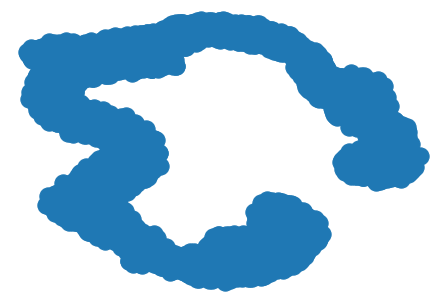

In [40]:
filePath = "./mri_label_2016_new_full/*.png"
pointData = ReadPointFromPNG(filePath, 0, 2)
(graph, pointsCor3D) = getMSTFromDataPoint(pointData, drawMST=True, sampleNumber=7000, maxNeighborDis=25)

if(not nx.is_connected(graph)):
    raise Exception('the raw centerline points cannot form a connected MST, raise maxNeighborDis and try again!')

In [47]:
displayPoints(pointsCor3D, 0.5)

In [41]:
pointsCor3D_base = copy.deepcopy(pointsCor3D)
pointsCor3D_moved = copy.deepcopy(pointsCor3D)
graph_base = copy.deepcopy(graph)

0 trial: 2 93
[-0.46236559 -1.32258065  5.46236559]
Moved! 5.639187827794984 > 5.4
1 trial: 2 66
[ 2.48484848 -5.10606061  0.66666667]
Moved! 5.717584398140727 > 5.4
2 trial: 2 73
[-0.54794521  2.26027397  1.01369863]
Not Moved! 2.5370587876860267 < 5.4
3 trial: 2 93
[ 1.29032258 -3.17204301  1.94623656]
Not Moved! 3.9388609988574155 < 5.4
4 trial: 1 72
[-0.40277778  0.31944444  1.36111111]
Not Moved! 1.454956407645311 < 4.4
5 trial: 4 97
[ -6.98969072  -7.19587629 -13.62886598]
Moved! 16.922836636626556 > 7.4
6 trial: 3 101
[6.33663366 6.11881188 4.04950495]
Moved! 9.694909765704901 > 6.4
7 trial: 1 65
[1.33846154 0.95384615 2.83076923]
Not Moved! 3.273309672642928 < 4.4
8 trial: 2 81
[ 0.74074074 -5.62962963  1.96296296]
Moved! 6.007882339540391 > 5.4
9 trial: 2 102
[0.45098039 5.87254902 0.58823529]
Moved! 5.919141497130531 > 5.4
10 trial: 2 114
[ 0.90350877 -2.15789474 -0.36842105]
Not Moved! 2.3682423584310706 < 5.4
11 trial: 1 61
[ 0.13114754 -1.8852459  -2.01639344]
Not Moved! 2

104 trial: 2 97
[-2.75257732 -2.70103093  4.28865979]
Moved! 5.767569054680676 > 5.4
105 trial: 2 84
[-3.35714286 -2.38095238  1.95238095]
Not Moved! 4.555341237146573 < 5.4
106 trial: 2 90
[ 1.38888889 -1.51111111 -2.77777778]
Not Moved! 3.45376874131991 < 5.4
107 trial: 2 87
[ 6.14942529 -1.81609195  2.71264368]
Moved! 6.962187664442177 > 5.4
108 trial: 1 74
[-1.40540541  1.10810811 -1.33783784]
Not Moved! 2.2344748853250254 < 4.4
109 trial: 2 97
[2.10309278 2.86597938 1.32989691]
Not Moved! 3.795452918258053 < 5.4
110 trial: 2 76
[-2.88157895  4.64473684  2.32894737]
Moved! 5.941470643468855 > 5.4
111 trial: 2 101
[ 4.12871287 -0.99009901 -1.73267327]
Not Moved! 4.585708524780835 < 5.4
112 trial: 2 72
[-3.13888889 -7.02777778  2.125     ]
Moved! 7.98485497367468 > 5.4
113 trial: 2 97
[-0.58762887 -1.07216495  6.62886598]
Moved! 6.740675747536403 > 5.4
114 trial: 2 74
[ 2.77027027 -7.87837838 -0.36486486]
Moved! 8.359208671450672 > 5.4
115 trial: 2 72
[ 3.05555556 -2.30555556  6.5833

205 trial: 2 94
[-1.56382979  1.21276596  1.85106383]
Not Moved! 2.7097605379311522 < 5.4
206 trial: 3 103
[ 5.33980583  2.00970874 -6.46601942]
Moved! 8.623332451524552 > 6.4
207 trial: 2 107
[ 1.04672897 -3.19626168 -3.02803738]
Not Moved! 4.525565232768342 < 5.4
208 trial: 2 67
[-5.25373134 -3.2238806  -2.98507463]
Moved! 6.848778698364173 > 5.4
209 trial: 3 91
[ -3.36263736 -10.24175824  -2.05494505]
Moved! 10.973775152337993 > 6.4
210 trial: 3 88
[ 6.02272727  8.35227273 -6.51136364]
Moved! 12.183249152724217 > 6.4
211 trial: 2 81
[ 2.48148148  1.49382716 -6.86419753]
Moved! 7.450266953008243 > 5.4
212 trial: 3 77
[-11.36363636  -1.76623377   1.28571429]
Moved! 11.571727370899852 > 6.4
213 trial: 3 94
[ 4.23404255 -5.10638298 -8.64893617]
Moved! 10.899833042026243 > 6.4
214 trial: 2 73
[-3.67123288 -7.05479452  1.54794521]
Moved! 8.102111510055488 > 5.4
215 trial: 2 101
[-1.33663366  3.06930693  2.55445545]
Not Moved! 4.210994800295632 < 5.4
216 trial: 3 101
[  3.81188119   5.5247

302 trial: 3 186
[2.7688172  2.24731183 2.77419355]
Not Moved! 4.518064741326932 < 6.4
303 trial: 2 105
[ 2.67619048 -2.35238095  0.9047619 ]
Not Moved! 3.676178139628943 < 5.4
304 trial: 2 72
[ 1.09722222  3.375      -3.79166667]
Not Moved! 5.193385958702605 < 5.4
305 trial: 1 73
[-0.39726027 -1.30136986 -0.52054795]
Not Moved! 1.4568285447830596 < 4.4
306 trial: 1 81
[-0.55555556 -0.9382716  -0.80246914]
Not Moved! 1.3538656853091608 < 4.4
307 trial: 2 62
[ 7.77419355  3.40322581 -0.32258065]
Moved! 8.49259026976543 > 5.4
308 trial: 1 64
[-0.9375  -0.25    -0.65625]
Not Moved! 1.171354050874457 < 4.4
309 trial: 1 66
[-0.04545455 -1.04545455  1.59090909]
Not Moved! 1.9042145514230373 < 4.4
310 trial: 4 67
[ 12.10447761   9.56716418 -10.88059701]
Moved! 18.879523301426513 > 7.4
311 trial: 2 65
[ 1.46153846 -0.84615385 -6.83076923]
Moved! 7.0364393900566515 > 5.4
312 trial: 2 93
[ 2.06451613 -4.23655914 -0.74193548]
Not Moved! 4.770862443432691 < 5.4
313 trial: 2 66
[-5.92424242  3.9545

397 trial: 3 91
[-7.35164835  5.          6.47252747]
Moved! 10.997288091566794 > 6.4
398 trial: 3 106
[-1.62264151  2.56603774  3.00943396]
Not Moved! 4.2748342544674625 < 6.4
399 trial: 2 85
[ 4.61176471  2.52941176 -2.02352941]
Moved! 5.6356870795078295 > 5.4
400 trial: 3 101
[-10.68316832  -3.94059406   1.4950495 ]
Moved! 11.484491275151651 > 6.4
401 trial: 3 83
[-8.54216867 -1.1686747   4.60240964]
Moved! 9.773260494822908 > 6.4
402 trial: 2 60
[-4.95       -4.88333333 -4.86666667]
Moved! 8.487278061244895 > 5.4
403 trial: 2 87
[-7.18390805 -1.85057471  0.74712644]
Moved! 7.455961339268563 > 5.4
404 trial: 2 108
[2.07407407 5.63888889 0.12962963]
Moved! 6.009630188860103 > 5.4
405 trial: 3 86
[3.20930233 8.8255814  6.48837209]
Moved! 11.414441764730883 > 6.4
406 trial: 3 183
[ 2.85245902 -2.54644809  0.53005464]
Not Moved! 3.8602950960609346 < 6.4
407 trial: 2 66
[ 0.04545455  1.57575758 -7.09090909]
Moved! 7.264025728808858 > 5.4
408 trial: 3 84
[ 5.75       10.23809524  2.940476

501 trial: 2 97
[ 1.6185567   5.4742268  -2.53608247]
Moved! 6.246486949759758 > 5.4
502 trial: 2 90
[1.91111111 0.6        1.1       ]
Not Moved! 2.2852452120095004 < 5.4
503 trial: 2 82
[ 3.97560976 -2.42682927 -0.68292683]
Not Moved! 4.707585610942679 < 5.4
504 trial: 2 76
[ 1.31578947  3.28947368 -4.75      ]
Moved! 5.925743755696136 > 5.4
505 trial: 2 119
[-0.65546218  1.7394958  -1.91596639]
Not Moved! 2.6695324501825226 < 5.4
506 trial: 2 72
[-2.34722222 -7.09722222 -4.65277778]
Moved! 8.805018823459804 > 5.4
507 trial: 2 75
[ 2.73333333 -3.53333333  6.12      ]
Moved! 7.576935762929204 > 5.4
508 trial: 3 74
[ -0.97297297   1.45945946 -10.21621622]
Moved! 10.365701717511495 > 6.4
509 trial: 1 66
[-0.37878788 -0.28787879 -2.45454545]
Not Moved! 2.5002295578720233 < 4.4
510 trial: 3 101
[-4.46534653 -6.55445545 -1.65346535]
Moved! 8.101490820482447 > 6.4
511 trial: 2 92
[-3.0326087   2.90217391 -2.14130435]
Not Moved! 4.712166511543726 < 5.4
512 trial: 2 91
[ 1.51648352  0.4285714

606 trial: 4 91
[14.78021978  4.21978022  5.95604396]
Moved! 16.484413894985053 > 7.4
607 trial: 2 100
[ 3.28 -1.45 -1.47]
Not Moved! 3.8757966922943723 < 5.4
608 trial: 3 122
[ 1.89344262 -1.59016393  9.53278689]
Moved! 9.84823700487925 > 6.4
609 trial: 3 154
[ 0.93506494 -3.86363636  3.64935065]
Not Moved! 5.396275803284819 < 6.4
610 trial: 2 89
[2.93258427 4.39325843 3.66292135]
Moved! 6.427889459902343 > 5.4
611 trial: 3 71
[-11.22535211   4.90140845   0.35211268]
Moved! 12.253828715582536 > 6.4
612 trial: 2 101
[ 1.6039604  -2.05940594  3.57425743]
Not Moved! 4.425964067374877 < 5.4
613 trial: 2 121
[ 3.19834711  1.68595041 -0.85123967]
Not Moved! 3.7143588935778955 < 5.4
614 trial: 1 60
[ 1.18333333  3.21666667 -2.53333333]
Not Moved! 4.262041764225217 < 4.4
615 trial: 2 85
[ 2.32941176  3.4        -1.23529412]
Not Moved! 4.302570246566998 < 5.4
616 trial: 3 92
[6.61956522 1.14130435 9.75      ]
Moved! 11.83992057750657 > 6.4
617 trial: 4 112
[ -1.00892857   4.08928571 -14.107142

706 trial: 4 72
[ 11.34722222   5.88888889 -12.86111111]
Moved! 18.134129246217434 > 7.4
707 trial: 3 77
[ 8.80519481 -7.42857143 -0.35064935]
Moved! 11.525540507669398 > 6.4
708 trial: 2 73
[ 3.5890411  -0.5890411  -5.17808219]
Moved! 6.32777374638788 > 5.4
709 trial: 2 63
[0.85714286 8.73015873 2.76190476]
Moved! 9.196656090403179 > 5.4
710 trial: 2 81
[ 5.24691358 -3.35802469  4.14814815]
Moved! 7.484221068710795 > 5.4
711 trial: 2 87
[ 3.42528736 -3.91954023  2.2183908 ]
Moved! 5.65832544565875 > 5.4
712 trial: 3 95
[ 7.50526316 -0.31578947 10.29473684]
Moved! 12.744030159613608 > 6.4
713 trial: 2 127
[ 1.07086614 -0.25984252 -0.78740157]
Not Moved! 1.354353598048655 < 5.4
714 trial: 2 76
[ 0.73684211  6.77631579 -6.82894737]
Moved! 9.648622395317572 > 5.4
715 trial: 2 63
[-6.73015873  2.12698413 -5.55555556]
Moved! 8.982388075586492 > 5.4
716 trial: 1 66
[1.3030303  1.24242424 2.18181818]
Not Moved! 2.8287517648763547 < 4.4
717 trial: 2 88
[ 0.03409091 -4.95454545 -2.70454545]
Mov

806 trial: 1 72
[ 0.38888889 -1.91666667  0.61111111]
Not Moved! 2.0489759562122254 < 4.4
807 trial: 5 473
[ 1.04651163 -4.34883721 -2.23044397]
Not Moved! 4.9982448903910575 < 8.4
808 trial: 2 102
[-0.23529412  4.3627451  -2.43137255]
Not Moved! 5.000048058208103 < 5.4
809 trial: 3 113
[ 3.65486726 -9.30973451  0.94690265]
Moved! 10.04618514706376 > 6.4
810 trial: 2 78
[-7.17948718  2.23076923 -5.05128205]
Moved! 9.057417837494953 > 5.4
811 trial: 2 99
[-2.26262626  5.26262626 -2.29292929]
Moved! 6.170270458155216 > 5.4
812 trial: 2 85
[ 1.17647059  0.34117647 -2.83529412]
Not Moved! 3.0885882151283552 < 5.4
813 trial: 3 121
[ 4.37190083 -7.75206612 -2.14049587]
Moved! 9.15367513397972 > 6.4
814 trial: 2 68
[ 3.89705882  4.44117647 -5.01470588]
Moved! 7.7497348989149435 > 5.4
815 trial: 2 60
[-2.41666667 -4.95       -5.21666667]
Moved! 7.586592706142125 > 5.4
816 trial: 3 98
[10.69387755 -0.91836735 -2.5       ]
Moved! 11.020545161657912 > 6.4
817 trial: 2 82
[ 0.98780488  7.02439024 

912 trial: 2 89
[-2.83146067  1.73033708  2.29213483]
Not Moved! 4.0330036003767 < 5.4
913 trial: 2 67
[-1.28358209  2.07462687 -2.58208955]
Not Moved! 3.5523015170684245 < 5.4
914 trial: 2 66
[8.01515152 4.07575758 3.        ]
Moved! 9.47915890926937 > 5.4
915 trial: 2 94
[-0.64893617 -0.9893617   3.87234043]
Not Moved! 4.0490708936564745 < 5.4
916 trial: 1 66
[ 1.45454545  0.15151515 -0.09090909]
Not Moved! 1.465238473180192 < 4.4
917 trial: 2 77
[-1.50649351 -6.62337662 -1.28571429]
Moved! 6.9131542587077295 > 5.4
918 trial: 3 83
[ 9.59036145  5.06024096 -1.02409639]
Moved! 10.891732859372034 > 6.4
919 trial: 2 81
[-1.         -0.44444444  0.64197531]
Not Moved! 1.2687250139819466 < 5.4
920 trial: 2 60
[ 5.98333333 -5.13333333 -4.31666667]
Moved! 8.988047618921476 > 5.4
921 trial: 3 101
[ 7.41584158  3.99009901 -6.95049505]
Moved! 10.919019092543932 > 6.4
922 trial: 2 75
[ 2.78666667  6.46666667 -1.66666667]
Moved! 7.23609471100722 > 5.4
923 trial: 2 72
[-3.04166667 -0.95833333  6.1

1012 trial: 2 110
[ 1.21818182  2.42727273 -2.24545455]
Not Moved! 3.523873713743616 < 5.4
1013 trial: 3 76
[-9.80263158 -4.69736842  2.10526316]
Moved! 11.071991190371659 > 6.4
1014 trial: 3 73
[ 6.69863014  0.5890411  -7.52054795]
Moved! 10.088471466031077 > 6.4
1015 trial: 3 86
[-7.8372093  -1.10465116 10.91860465]
Moved! 13.485474829174803 > 6.4
1016 trial: 1 67
[ 1.49253731  0.80597015 -0.64179104]
Not Moved! 1.8136017364990065 < 4.4
1017 trial: 2 83
[1.36144578 0.69879518 2.19277108]
Not Moved! 2.6739660344359057 < 5.4
1018 trial: 3 110
[-10.56363636   6.21818182   1.49090909]
Moved! 12.348239075449698 > 6.4
1019 trial: 2 72
[3.72222222 2.01388889 4.94444444]
Moved! 6.508319106542994 > 5.4
1020 trial: 1 62
[0.32258065 0.59677419 1.64516129]
Not Moved! 1.7795374067138519 < 4.4
1021 trial: 2 83
[ 0.3373494  -5.63855422 -2.4939759 ]
Moved! 6.174707610925238 > 5.4
1022 trial: 5 104
[-9.45192308 17.28846154 -2.40384615]
Moved! 19.849640514384532 > 8.4
1023 trial: 3 103
[-10.02912621  

1118 trial: 5 377
[ 6.54111406 -6.47480106  2.24137931]
Moved! 9.472750557091999 > 8.4
1119 trial: 2 70
[ 5.01428571 -4.81428571 -3.44285714]
Moved! 7.7571691659643305 > 5.4
1120 trial: 3 70
[  5.02857143   5.8        -10.01428571]
Moved! 12.6179415508074 > 6.4
1121 trial: 3 80
[ -4.7375   0.7875 -10.875 ]
Moved! 11.888216329626577 > 6.4
1122 trial: 2 71
[-0.11267606  4.14084507  2.29577465]
Not Moved! 4.736018900384232 < 5.4
1123 trial: 3 88
[-4.59090909  9.47727273 -3.97727273]
Moved! 11.256724344817483 > 6.4
1124 trial: 2 60
[-1.03333333 -6.26666667  3.53333333]
Moved! 7.267966244647352 > 5.4
1125 trial: 2 83
[ 4.98795181 -2.87951807  3.36144578]
Moved! 6.668628443152126 > 5.4
1126 trial: 2 79
[-3.91139241  3.01265823 -1.32911392]
Not Moved! 5.1128899819292934 < 5.4
1127 trial: 3 85
[-3.52941176  1.43529412 11.23529412]
Moved! 11.863753643726387 > 6.4
1128 trial: 3 83
[3.13253012 7.51807229 4.04819277]
Moved! 9.09516468309237 > 6.4
1129 trial: 3 98
[ 7.21428571 -5.07142857 -7.836734

1213 trial: 2 95
[ 1.61052632 -0.08421053 -1.42105263]
Not Moved! 2.1494829630193046 < 5.4
1214 trial: 1 72
[ 1.52777778 -0.04166667  0.80555556]
Not Moved! 1.7276460292748441 < 4.4
1215 trial: 2 80
[ 4.225  -3.7875  5.85  ]
Moved! 8.149741176871816 > 5.4
1216 trial: 3 101
[ 0.04950495 -7.75247525  4.15841584]
Moved! 8.797485181297299 > 6.4
1217 trial: 3 86
[-2.30232558  7.24418605 -9.55813953]
Moved! 12.2121646700136 > 6.4
1218 trial: 2 61
[-1.86885246  0.45901639 -8.62295082]
Moved! 8.835077045589639 > 5.4
1219 trial: 2 83
[-3.91566265 -6.77108434  0.86746988]
Moved! 7.869720521638118 > 5.4
1220 trial: 2 98
[ 4.73469388 -3.80612245  1.30612245]
Moved! 6.21368248806406 > 5.4
1221 trial: 2 75
[-3.04        1.90666667 -4.16      ]
Moved! 5.493867287965535 > 5.4
1222 trial: 3 124
[-10.10483871  -1.27419355  -5.41129032]
Moved! 11.533143435447313 > 6.4
1223 trial: 2 119
[-1.8907563   0.52941176 -5.24369748]
Moved! 5.599249901845313 > 5.4
1224 trial: 1 70
[ 0.74285714 -1.84285714  1.042857

1317 trial: 2 74
[-1.52702703 -5.37837838  2.05405405]
Moved! 5.9563330648356905 > 5.4
1318 trial: 2 97
[-4.34020619  2.90721649 -0.87628866]
Not Moved! 5.296902802243809 < 5.4
1319 trial: 3 86
[-0.40697674  1.10465116 -6.60465116]
Moved! 6.708748113017482 > 6.4
1320 trial: 2 60
[ 2.41666667  7.         -5.08333333]
Moved! 8.982235554446095 > 5.4
1321 trial: 2 147
[ 1.23129252 -0.50340136 -1.54421769]
Not Moved! 2.03816153857084 < 5.4
1322 trial: 3 85
[ 0.08235294  2.82352941 10.83529412]
Moved! 11.1974416257437 > 6.4
1323 trial: 1 69
[1.08695652 0.20289855 1.08695652]
Not Moved! 1.550521454926895 < 4.4
1324 trial: 2 63
[-0.66666667 -3.85714286  6.04761905]
Moved! 7.203866434768021 > 5.4
1325 trial: 3 101
[-2.83168317 -4.13861386 -9.97029703]
Moved! 11.160348431831787 > 6.4
1326 trial: 3 104
[-1.40384615 -0.05769231 10.69230769]
Moved! 10.784227195910598 > 6.4
1327 trial: 3 80
[12.375   0.1     3.7625]
Moved! 12.93472192395337 > 6.4
1328 trial: 3 83
[-9.85542169  0.72289157  2.6746988 

Moved! 5.873361767487862 > 5.4
1422 trial: 2 65
[ 2.86153846 -3.09230769 -7.13846154]
Moved! 8.289053164678334 > 5.4
1423 trial: 3 85
[ 6.05882353 -3.21176471  5.67058824]
Moved! 8.898333890159508 > 6.4
1424 trial: 1 63
[-0.47619048  0.66666667 -1.06349206]
Not Moved! 1.3424668275862774 < 4.4
1425 trial: 2 77
[-7.1038961  -1.72727273  0.80519481]
Moved! 7.355076451243937 > 5.4
1426 trial: 2 69
[1.50724638 5.92753623 4.04347826]
Moved! 7.331929750538714 > 5.4
1427 trial: 2 96
[-2.76041667  1.02083333  0.36458333]
Not Moved! 2.9656233535295744 < 5.4
1428 trial: 1 71
[ 0.47887324 -0.52112676 -0.42253521]
Not Moved! 0.8242746415999735 < 4.4
1429 trial: 3 77
[-10.07792208   7.1038961    8.07792208]
Moved! 14.740511468758486 > 6.4
1430 trial: 2 76
[-2.71052632  6.75        3.51315789]
Moved! 8.077854374890592 > 5.4
1431 trial: 3 97
[-1.73195876 -8.64948454 -4.        ]
Moved! 9.685724748116144 > 6.4
1432 trial: 2 76
[-1.01315789  1.67105263 -7.64473684]
Moved! 7.890558104609335 > 5.4
1433 tr

1521 trial: 3 109
[-3.33027523  5.35779817  1.14678899]
Moved! 6.411853029437366 > 6.4
1522 trial: 1 68
[ 0.07352941 -0.83823529 -2.11764706]
Not Moved! 2.278700078650744 < 4.4
1523 trial: 2 68
[-3.91176471  3.52941176  4.89705882]
Moved! 7.193040778428718 > 5.4
1524 trial: 3 74
[-0.04054054  7.12162162 -8.14864865]
Moved! 10.822181520197274 > 6.4
1525 trial: 3 70
[6.01428571 9.61428571 7.55714286]
Moved! 13.627785242373204 > 6.4
1526 trial: 3 99
[ 0.88888889 -2.09090909 13.52525253]
Moved! 13.71475410479846 > 6.4
1527 trial: 2 98
[-2.03061224 -0.15306122  0.13265306]
Not Moved! 2.040688771523986 < 5.4
1528 trial: 2 96
[-2.67708333  2.58333333  3.42708333]
Not Moved! 5.058190037783608 < 5.4
1529 trial: 4 78
[  7.69230769   9.92307692 -16.58974359]
Moved! 20.805255240632746 > 7.4
1530 trial: 2 74
[-0.52702703  4.32432432 -4.14864865]
Moved! 6.015714750475975 > 5.4
1531 trial: 2 85
[-4.31764706  1.01176471  5.95294118]
Moved! 7.423156511562699 > 5.4
1532 trial: 2 81
[-3.02469136 -2.28395

1620 trial: 3 132
[-1.29545455 -6.81818182 -0.90909091]
Moved! 6.999446554272396 > 6.4
1621 trial: 3 81
[-11.20987654   6.4691358   -0.09876543]
Moved! 12.942982838409879 > 6.4
1622 trial: 2 70
[-2.78571429 -6.3         4.41428571]
Moved! 8.181449898946983 > 5.4
1623 trial: 2 113
[-0.07964602 -3.94690265 -2.61061947]
Not Moved! 4.732834041797154 < 5.4
1624 trial: 2 90
[-2.04444444 -2.36666667 -3.27777778]
Not Moved! 4.530418452861136 < 5.4
1625 trial: 2 119
[ 0.02521008 -1.32773109 -1.86554622]
Not Moved! 2.289927530616086 < 5.4
1626 trial: 2 66
[1.86363636 5.65151515 6.16666667]
Moved! 8.56974572443377 > 5.4
1627 trial: 3 81
[ 5.66666667  6.92592593 -7.34567901]
Moved! 11.577502372918772 > 6.4
1628 trial: 3 71
[-1.63380282 -1.90140845 10.88732394]
Moved! 11.172219492793708 > 6.4
1629 trial: 2 90
[-1.95555556  0.71111111 -7.5       ]
Moved! 7.783307558050747 > 5.4
1630 trial: 2 83
[ 2.30120482 -1.54216867 -4.45783133]
Not Moved! 5.248436716425485 < 5.4
1631 trial: 1 60
[-1.68333333 -1.

1725 trial: 1 61
[-1.01639344  0.59016393  0.7704918 ]
Not Moved! 1.405349322632642 < 4.4
1726 trial: 3 100
[10.84 -2.32 -4.35]
Moved! 11.908421389924023 > 6.4
1727 trial: 3 95
[ -4.01052632   0.95789474 -10.03157895]
Moved! 10.845942090652846 > 6.4
1728 trial: 3 100
[ 1.25 -4.59  9.  ]
Moved! 10.179911590971702 > 6.4
1729 trial: 2 120
[ 1.2         0.44166667 -2.95      ]
Not Moved! 3.2152090825394923 < 5.4
1730 trial: 3 113
[2.02654867 4.7079646  6.99115044]
Moved! 8.66879545976012 > 6.4
1731 trial: 1 66
[-0.56060606 -1.25757576 -0.81818182]
Not Moved! 1.6016233729668758 < 4.4
1732 trial: 3 91
[-5.21978022  2.7032967  -9.01098901]
Moved! 10.758802980119507 > 6.4
1733 trial: 2 77
[ 2.41558442 -1.68831169 -3.63636364]
Not Moved! 4.680660735576969 < 5.4
1734 trial: 3 72
[-3.68055556  8.05555556  6.08333333]
Moved! 10.744552524447785 > 6.4
1735 trial: 2 69
[-0.10144928 -7.72463768 -2.79710145]
Moved! 8.216087619919705 > 5.4
1736 trial: 2 100
[-0.79 -2.63  2.64]
Not Moved! 3.8092781468409

1823 trial: 4 99
[ 9.14141414 10.50505051 -5.1010101 ]
Moved! 14.830436361385845 > 7.4
1824 trial: 2 77
[ 3.18181818  3.68831169 -0.06493506]
Not Moved! 4.871532265616589 < 5.4
1825 trial: 2 86
[-3.94186047 -1.8372093  -1.5       ]
Not Moved! 4.600391499318115 < 5.4
1826 trial: 2 75
[-1.84  5.8   2.24]
Moved! 6.484072794162632 > 5.4
1827 trial: 3 68
[11.69117647 -3.05882353  1.20588235]
Moved! 12.144717407155014 > 6.4
1828 trial: 2 67
[ 0.86567164  6.50746269 -5.25373134]
Moved! 8.408219254745052 > 5.4
1829 trial: 1 72
[-0.47222222 -0.43055556 -1.70833333]
Not Moved! 1.823944815875202 < 4.4
1830 trial: 2 100
[3.82 0.17 0.09]
Not Moved! 3.82483986592903 < 5.4
1831 trial: 3 91
[ 6.40659341 -7.04395604  9.2967033 ]
Moved! 13.307533506007976 > 6.4
1832 trial: 3 98
[-2.75510204 10.7244898   0.14285714]
Moved! 11.073647854313084 > 6.4
1833 trial: 2 75
[-3.93333333 -4.2        -0.14666667]
Moved! 5.756094354874859 > 5.4
1834 trial: 2 72
[ 5.88888889 -1.79166667 -2.72222222]
Moved! 6.730495941

1927 trial: 3 128
[-2.140625   6.109375   4.0546875]
Moved! 7.6385357892665695 > 6.4
1928 trial: 2 69
[-7.04347826 -4.          1.56521739]
Moved! 8.249878271428235 > 5.4
1929 trial: 2 99
[-0.05050505  2.90909091 -0.17171717]
Not Moved! 2.914592160928255 < 5.4
1930 trial: 2 78
[ 2.26923077 -4.17948718 -2.57692308]
Moved! 5.409071446366749 > 5.4
1931 trial: 3 84
[ 4.72619048  3.82142857 -7.80952381]
Moved! 9.895900912766024 > 6.4
1932 trial: 3 92
[-9.83695652 -4.27173913 -3.22826087]
Moved! 11.199782901960186 > 6.4
1933 trial: 2 82
[ 4.48780488 -2.41463415  4.29268293]
Moved! 6.663180726530544 > 5.4
1934 trial: 2 62
[ 6.4516129  -0.48387097 -7.01612903]
Moved! 9.543767954209056 > 5.4
1935 trial: 2 90
[ 0.22222222 -2.35555556  0.6       ]
Not Moved! 2.440906530647584 < 5.4
1936 trial: 2 85
[ 0.87058824 -1.23529412  5.95294118]
Moved! 6.14177369194315 > 5.4
1937 trial: 1 71
[-0.26760563  0.32394366  0.12676056]
Not Moved! 0.43888553382768686 < 4.4
1938 trial: 1 68
[ 0.89705882 -0.13235294

2028 trial: 2 87
[-2.27586207  5.45977011  3.        ]
Moved! 6.632393072260989 > 5.4
2029 trial: 3 85
[-11.18823529   1.           6.55294118]
Moved! 13.004524099667144 > 6.4
2030 trial: 2 79
[ 2.46835443  3.12658228 -0.64556962]
Not Moved! 4.035474008425857 < 5.4
2031 trial: 2 106
[-0.30188679  1.87735849 -0.86792453]
Not Moved! 2.0901922218747973 < 5.4
2032 trial: 2 79
[-3.96202532 -0.05063291  1.62025316]
Not Moved! 4.280821021394001 < 5.4
2033 trial: 2 97
[-1.06185567  1.05154639 -3.32989691]
Not Moved! 3.649863105765466 < 5.4
2034 trial: 3 97
[-6.01030928  7.42268041  7.5257732 ]
Moved! 12.15965724522671 > 6.4
2035 trial: 2 123
[ 0.42276423 -2.08130081  1.48780488]
Not Moved! 2.5930881245241206 < 5.4
2036 trial: 2 70
[ 2.41428571  5.07142857 -4.15714286]
Moved! 6.987846592477542 > 5.4
2037 trial: 2 65
[-1.90769231 -3.73846154  5.81538462]
Moved! 7.171755910531025 > 5.4
2038 trial: 3 111
[ 3.98198198  4.82882883 -9.46846847]
Moved! 11.350139360436911 > 6.4
2039 trial: 2 65
[6.    

2123 trial: 3 130
[1.38461538 1.9        7.80769231]
Moved! 8.153969520111737 > 6.4
2124 trial: 3 81
[ -6.66666667 -10.72839506   0.98765432]
Moved! 12.669584290841128 > 6.4
2125 trial: 1 61
[ 1.08196721 -0.78688525 -0.06557377]
Not Moved! 1.339455620709213 < 4.4
2126 trial: 1 61
[-0.03278689 -0.45901639  0.2295082 ]
Not Moved! 0.514242201356004 < 4.4
2127 trial: 3 86
[-4.84883721  8.3372093  -6.84883721]
Moved! 11.829068110067801 > 6.4
2128 trial: 2 64
[ 2.125     7.65625  -4.734375]
Moved! 9.249221356585915 > 5.4
2129 trial: 2 88
[-1.92045455 -0.69318182 -1.15909091]
Not Moved! 2.3477943755261164 < 5.4
2130 trial: 2 74
[0.7972973  6.63513514 2.72972973]
Moved! 7.218872878722319 > 5.4
2131 trial: 2 83
[-5.36144578 -2.37349398  0.04819277]
Moved! 5.8635225830813615 > 5.4
2132 trial: 2 75
[-2.64        1.8        -2.65333333]
Not Moved! 4.153285178961081 < 5.4
2133 trial: 3 154
[1.46753247 5.85064935 6.11688312]
Moved! 8.590693128794982 > 6.4
2134 trial: 1 65
[1.16923077 0.50769231 1.83

2223 trial: 2 81
[-3.39506173 -3.44444444 -1.19753086]
Not Moved! 4.982441353511624 < 5.4
2224 trial: 2 84
[-1.64285714 -2.85714286  8.76190476]
Moved! 9.3612616646822 > 5.4
2225 trial: 4 73
[-4.78082192 15.12328767  1.43835616]
Moved! 15.926046485310785 > 7.4
2226 trial: 3 172
[ 0.25581395 -0.43604651  6.01162791]
Not Moved! 6.0328473734252395 < 6.4
2227 trial: 2 62
[ 5.40322581 -0.43548387  5.38709677]
Moved! 7.642336486435563 > 5.4
2228 trial: 2 109
[3.55963303 3.50458716 3.1559633 ]
Moved! 5.90874121896485 > 5.4
2229 trial: 2 81
[5.01234568 2.79012346 1.87654321]
Moved! 6.035711435164703 > 5.4
2230 trial: 2 60
[-4.05       -4.93333333 -2.76666667]
Moved! 6.956631528421081 > 5.4
2231 trial: 2 66
[-5.63636364 -3.          0.43939394]
Moved! 6.400129848315458 > 5.4
2232 trial: 3 74
[-7.71621622 -4.01351351  6.60810811]
Moved! 10.923157793742512 > 6.4
2233 trial: 3 84
[-8.79761905 -6.57142857 -5.3452381 ]
Moved! 12.212835242940184 > 6.4
2234 trial: 1 69
[ 1.56521739  1.85507246 -0.3188

2327 trial: 2 62
[ 0.41935484 -4.          7.43548387]
Moved! 8.453536471570384 > 5.4
2328 trial: 3 82
[-2.65853659 -0.70731707 13.53658537]
Moved! 13.813300025148624 > 6.4
2329 trial: 2 146
[-0.67808219 -0.7739726   0.30136986]
Not Moved! 1.0722186544426864 < 5.4
2330 trial: 2 76
[-1.17105263  0.67105263 -6.55263158]
Moved! 6.6901910667555144 > 5.4
2331 trial: 3 85
[-13.94117647   0.14117647  -2.47058824]
Moved! 14.159100903952359 > 6.4
2332 trial: 2 65
[-7.69230769  3.63076923 -3.47692308]
Moved! 9.189291426605042 > 5.4
2333 trial: 2 100
[-4.11  1.38  2.63]
Not Moved! 5.070838195012734 < 5.4
2334 trial: 3 95
[ 2.52631579  9.45263158 -6.31578947]
Moved! 11.645759396078788 > 6.4
2335 trial: 4 94
[-4.67021277 -6.82978723 14.94680851]
Moved! 17.08402662124161 > 7.4
2336 trial: 3 88
[-6.68181818 -6.82954545  2.05681818]
Moved! 9.773427564761318 > 6.4
2337 trial: 2 70
[-1.3        -4.14285714 -6.32857143]
Moved! 7.6748994542373685 > 5.4
2338 trial: 2 73
[-4.90410959  2.89041096  2.69863014

2427 trial: 2 63
[-5.57142857  2.28571429 -1.38095238]
Moved! 6.178376453479266 > 5.4
2428 trial: 3 121
[-6.39669421 -1.9338843  -6.7107438 ]
Moved! 9.470569556592054 > 6.4
2429 trial: 2 61
[-2.45901639 -3.31147541  1.85245902]
Not Moved! 4.521530207859488 < 5.4
2430 trial: 2 93
[ 3.89247312 -1.46236559  4.62365591]
Moved! 6.218364263236898 > 5.4
2431 trial: 2 74
[ 1.01351351 -3.14864865  2.82432432]
Not Moved! 4.349483399632825 < 5.4
2432 trial: 1 65
[ 1.09230769  1.07692308 -1.58461538]
Not Moved! 2.205426336435608 < 4.4
2433 trial: 2 65
[-2.86153846 -5.46153846  0.27692308]
Moved! 6.171992476037245 > 5.4
2434 trial: 2 70
[-3.15714286 -7.17142857 -1.51428571]
Moved! 7.98060148109151 > 5.4
2435 trial: 3 89
[-4.66292135  5.62921348 -8.76404494]
Moved! 11.412246216968088 > 6.4
2436 trial: 3 88
[ 9.86363636 -1.97727273 -6.93181818]
Moved! 12.216834003040692 > 6.4
2437 trial: 2 85
[-2.62352941  2.14117647  3.09411765]
Not Moved! 4.587058672661162 < 5.4
2438 trial: 2 104
[-2.32692308 -1.55

2532 trial: 2 116
[ 0.68103448 -0.42241379  2.02586207]
Not Moved! 2.178613894609045 < 5.4
2533 trial: 1 61
[-1.62295082  0.31147541 -2.7704918 ]
Not Moved! 3.225927948054852 < 4.4
2534 trial: 2 91
[ 0.52747253 -3.63736264  3.78021978]
Not Moved! 5.272446852238988 < 5.4
2535 trial: 2 100
[ 3.11 -0.17 -1.24]
Not Moved! 3.352402123850896 < 5.4
2536 trial: 2 82
[-2.84146341  5.7804878   2.42682927]
Moved! 6.883128205728132 > 5.4
2537 trial: 2 92
[ 0.2826087  -0.65217391  3.04347826]
Not Moved! 3.125373323636442 < 5.4
2538 trial: 2 116
[-0.06034483 -1.89655172 -1.88793103]
Not Moved! 2.676720667441806 < 5.4
2539 trial: 2 88
[ 0.47727273 -0.95454545  4.11363636]
Not Moved! 4.249817691763158 < 5.4
2540 trial: 2 114
[ 1.78070175  1.86842105 -0.47368421]
Not Moved! 2.6241708593938946 < 5.4
2541 trial: 2 101
[-0.36633663  2.24752475 -1.45544554]
Not Moved! 2.702571326591797 < 5.4
2542 trial: 2 78
[-1.06410256  5.82051282  2.64102564]
Moved! 6.479637350750322 > 5.4
2543 trial: 2 98
[-1.25510204 

2626 trial: 2 98
[ 1.94897959 -4.55102041 -1.20408163]
Not Moved! 5.095107533998383 < 5.4
2627 trial: 3 87
[ 9.32183908  2.56321839 -1.09195402]
Moved! 9.729292674663803 > 6.4
2628 trial: 1 62
[ 0.37096774 -0.80645161  0.48387097]
Not Moved! 1.0109957383364399 < 4.4
2629 trial: 3 84
[ 6.79761905  9.13095238 -0.17857143]
Moved! 11.384805832989656 > 6.4
2630 trial: 2 65
[ 0.26153846 -1.38461538 -1.86153846]
Not Moved! 2.334713595703871 < 5.4
2631 trial: 2 99
[-0.52525253  4.33333333  1.61616162]
Not Moved! 4.654637081730009 < 5.4
2632 trial: 2 68
[ 1.82352941 -5.25       -3.91176471]
Moved! 6.796297714914922 > 5.4
2633 trial: 1 62
[-0.75806452  3.09677419  0.48387097]
Not Moved! 3.2247175581536944 < 4.4
2634 trial: 4 81
[-15.59259259  -8.38271605   2.5308642 ]
Moved! 17.883068688273152 > 7.4
2635 trial: 2 80
[ 2.95    1.2375 -2.525 ]
Not Moved! 4.075479266294947 < 5.4
2636 trial: 3 93
[ 8.52688172  2.6344086  -7.51612903]
Moved! 11.667905389865073 > 6.4
2637 trial: 2 80
[-2.1375 -0.0375 

2731 trial: 2 93
[-1.08602151 -2.09677419 -2.74193548]
Not Moved! 3.618579130899462 < 5.4
2732 trial: 2 74
[1.52702703 1.60810811 5.74324324]
Moved! 6.156514125679662 > 5.4
2733 trial: 2 83
[ 3.65060241  4.57831325 -2.68674699]
Moved! 6.442550703970648 > 5.4
2734 trial: 2 83
[-1.73493976 -4.69879518 -2.77108434]
Moved! 5.724299129375772 > 5.4
2735 trial: 2 63
[-1.73015873 -0.36507937 -6.9047619 ]
Moved! 7.127585084430944 > 5.4
2736 trial: 2 69
[ 4.23188406 -3.20289855  3.44927536]
Moved! 6.329684220515506 > 5.4
2737 trial: 2 87
[-1.36781609 -4.01149425  7.29885057]
Moved! 8.44015560959803 > 5.4
2738 trial: 2 120
[-0.21666667  0.65       -1.74166667]
Not Moved! 1.8715894908398643 < 5.4
2739 trial: 2 80
[-3.425   1.1125  3.375 ]
Not Moved! 4.935474267990868 < 5.4
2740 trial: 2 84
[-0.96428571 -0.85714286  6.5952381 ]
Moved! 6.720246003622661 > 5.4
2741 trial: 2 74
[-4.74324324 -5.62162162  1.7027027 ]
Moved! 7.549846529238026 > 5.4
2742 trial: 2 64
[3.375    9.859375 0.3125  ]
Moved! 10.

2836 trial: 3 89
[10.41573034 -4.29213483  3.52808989]
Moved! 11.804968365965633 > 6.4
2837 trial: 2 95
[1.6        0.38947368 1.05263158]
Not Moved! 1.9544111623938683 < 5.4
2838 trial: 2 76
[ 1.14473684 -1.82894737  5.82894737]
Moved! 6.215472495148711 > 5.4
2839 trial: 2 64
[ 4.4375   -2.78125  -6.109375]
Moved! 8.046814320159562 > 5.4
2840 trial: 1 60
[-0.75       -1.21666667  1.        ]
Not Moved! 1.7443559779407922 < 4.4
2841 trial: 2 60
[3.03333333 3.4        7.23333333]
Moved! 8.548814082796644 > 5.4
2842 trial: 3 90
[-4.5        -2.84444444  9.41111111]
Moved! 10.812487065574222 > 6.4
2843 trial: 2 84
[-4.67857143 -2.98809524  4.14285714]
Moved! 6.926832542388677 > 5.4
2844 trial: 2 84
[5.47619048 0.20238095 2.05952381]
Moved! 5.854165910136248 > 5.4
2845 trial: 2 92
[-2.29347826 -3.26086957 -1.51086957]
Not Moved! 4.26333668592366 < 5.4
2846 trial: 2 61
[3.50819672 1.04918033 7.60655738]
Moved! 8.442034039622731 > 5.4
2847 trial: 2 63
[-4.53968254 -5.82539683 -0.85714286]
Mo

2932 trial: 1 62
[ 0.58064516  0.70967742 -0.48387097]
Not Moved! 1.0367844309669805 < 4.4
2933 trial: 3 79
[  2.37974684  -3.49367089 -10.21518987]
Moved! 11.05527183795097 > 6.4
2934 trial: 3 78
[-1.91025641 10.74358974 -2.97435897]
Moved! 11.310199442973683 > 6.4
2935 trial: 1 75
[-1.58666667  0.12        0.24      ]
Not Moved! 1.6091957963874723 < 4.4
2936 trial: 2 96
[-3.55208333  4.67708333  1.16666667]
Moved! 5.987780525787498 > 5.4
2937 trial: 3 204
[0.8627451  4.10294118 1.69117647]
Not Moved! 4.520899606985299 < 6.4
2938 trial: 2 107
[ 4.07476636  1.05607477 -1.12149533]
Not Moved! 4.3562330665183575 < 5.4
2939 trial: 3 117
[ 0.23931624 -2.18803419 -7.86324786]
Moved! 8.165502607266681 > 6.4
2940 trial: 2 100
[ 0.31 -1.39 -3.19]
Not Moved! 3.4934653282951014 < 5.4
2941 trial: 2 67
[ 0.58208955  2.3880597  -7.59701493]
Moved! 7.9847537946426606 > 5.4
2942 trial: 2 73
[-3.39726027 -0.53424658  5.63013699]
Moved! 6.597366084802042 > 5.4
2943 trial: 3 93
[-6.7311828  -9.23655914 

3033 trial: 3 76
[ 1.18421053  8.01315789 10.02631579]
Moved! 12.889533053096603 > 6.4
3034 trial: 2 85
[ 0.14117647  6.47058824 -0.2       ]
Moved! 6.47521759530708 > 5.4
3035 trial: 3 96
[ 1.22916667  7.4375     -6.14583333]
Moved! 9.72617727093001 > 6.4
3036 trial: 1 64
[0.109375 1.15625  1.      ]
Not Moved! 1.5326046304004826 < 4.4
3037 trial: 1 61
[-0.27868852  1.03278689  1.2295082 ]
Not Moved! 1.629725881821561 < 4.4
3038 trial: 2 76
[ 4.96052632  4.26315789 -4.80263158]
Moved! 8.114592204676674 > 5.4
3039 trial: 2 86
[-0.69767442  0.18604651 -4.69767442]
Not Moved! 4.752842080490031 < 5.4
3040 trial: 2 94
[ 1.11702128  1.39361702 -2.06382979]
Not Moved! 2.7293402728560525 < 5.4
3041 trial: 2 82
[ 3.3902439   2.81707317 -2.53658537]
Not Moved! 5.0856582942176045 < 5.4
3042 trial: 2 98
[-1.56122449  0.06122449  3.05102041]
Not Moved! 3.427812112225236 < 5.4
3043 trial: 2 79
[-5.92405063 -0.56962025 -6.53164557]
Moved! 8.836358807860453 > 5.4
3044 trial: 2 82
[-3.75609756  2.5   

3127 trial: 2 75
[-3.12       -2.94666667 -4.4       ]
Moved! 6.1463195852839 > 5.4
3128 trial: 3 109
[1.55963303 6.04587156 7.81651376]
Moved! 10.004144415157988 > 6.4
3129 trial: 2 86
[-4.41860465 -2.55813953  0.89534884]
Not Moved! 5.183608249424776 < 5.4
3130 trial: 2 116
[-4.19827586  0.81896552 -5.09482759]
Moved! 6.652329882502531 > 5.4
3131 trial: 2 125
[ 0.216 -0.704 -2.192]
Not Moved! 2.3123875107775516 < 5.4
3132 trial: 3 85
[ 3.77647059 -4.69411765  8.69411765]
Moved! 10.57753053643122 > 6.4
3133 trial: 2 75
[ 2.4        -5.26666667  5.08      ]
Moved! 7.700920579890289 > 5.4
3134 trial: 1 70
[-0.41428571 -0.4         0.5       ]
Not Moved! 0.7626484465736652 < 4.4
3135 trial: 2 64
[ 5.75     -1.875     5.328125]
Moved! 8.060213459681139 > 5.4
3136 trial: 2 98
[1.46938776 2.96938776 2.7755102 ]
Not Moved! 4.322015838466469 < 5.4
3137 trial: 2 92
[-5.20652174 -1.52173913 -3.5326087 ]
Moved! 6.473243607167242 > 5.4
3138 trial: 1 62
[1.38709677 1.25806452 2.72580645]
Not Moved

3226 trial: 2 65
[-1.47692308  6.24615385 -2.04615385]
Moved! 6.736652373924351 > 5.4
3227 trial: 2 87
[-1.77011494  1.31034483 -2.48275862]
Not Moved! 3.3187950894193867 < 5.4
3228 trial: 3 112
[ 4.16964286 -7.47321429  0.11607143]
Moved! 8.558523581369462 > 6.4
3229 trial: 2 110
[ 0.89090909  0.88181818 -2.17272727]
Not Moved! 2.508399114116906 < 5.4
3230 trial: 3 85
[-4.77647059  8.12941176 -0.65882353]
Moved! 9.451775249302207 > 6.4
3231 trial: 2 75
[-1.6         3.41333333 -5.32      ]
Moved! 6.520218128593894 > 5.4
3232 trial: 2 104
[-0.30769231 -2.67307692 -3.08653846]
Not Moved! 4.094720316145612 < 5.4
3233 trial: 2 109
[ 0.18348624 -3.33027523 -2.        ]
Not Moved! 3.8890101957959424 < 5.4
3234 trial: 2 83
[ 1.30120482  0.55421687 -6.4939759 ]
Moved! 6.646202927583787 > 5.4
3235 trial: 1 60
[ 2.83333333 -0.46666667  0.26666667]
Not Moved! 2.8838631497813254 < 4.4
3236 trial: 2 112
[-0.70535714 -3.10714286 -0.99107143]
Not Moved! 3.3367780882468168 < 5.4
3237 trial: 1 75
[-0.

3327 trial: 3 104
[6.80769231 2.91346154 9.45192308]
Moved! 12.007155472649577 > 6.4
3328 trial: 2 102
[-0.21568627  1.15686275  0.81372549]
Not Moved! 1.4307344803989794 < 5.4
3329 trial: 2 76
[-0.13157895 -1.55263158  2.36842105]
Not Moved! 2.835030180065753 < 5.4
3330 trial: 2 89
[-1.64044944  0.76404494 -0.84269663]
Not Moved! 1.9962406278710703 < 5.4
3331 trial: 1 63
[ 1.06349206 -0.34920635 -0.87301587]
Not Moved! 1.4195482231943728 < 4.4
3332 trial: 3 61
[-8.18032787  7.98360656  0.13114754]
Moved! 11.431226416374757 > 6.4
3333 trial: 2 73
[-4.16438356 -3.69863014  5.21917808]
Moved! 7.632940140754661 > 5.4
3334 trial: 3 99
[ 1.14141414 10.45454545 -5.4040404 ]
Moved! 11.823874136334435 > 6.4
3335 trial: 1 67
[-0.2238806  -0.94029851 -1.02985075]
Not Moved! 1.4124009219929108 < 4.4
3336 trial: 2 79
[ 5.11392405 -5.53164557 -1.34177215]
Moved! 7.651906586671851 > 5.4
3337 trial: 4 110
[-5.2 13.9  5.7]
Moved! 15.897798589741914 > 7.4
3338 trial: 3 184
[ 2.73369565 -3.61956522  0.9

3423 trial: 3 64
[  3.484375  -3.390625 -13.546875]
Moved! 14.392881202069132 > 6.4
3424 trial: 2 69
[-2.46376812  2.88405797  0.89855072]
Not Moved! 3.8981196895492665 < 5.4
3425 trial: 2 78
[0.79487179 2.61538462 4.66666667]
Moved! 5.408311717574258 > 5.4
3426 trial: 2 79
[-0.86075949 -6.91139241 -1.91139241]
Moved! 7.222303843569914 > 5.4
3427 trial: 2 95
[0.34736842 4.31578947 2.18947368]
Not Moved! 4.851855172504477 < 5.4
3428 trial: 3 83
[-9.57831325  5.3253012   6.85542169]
Moved! 12.926705852536323 > 6.4
3429 trial: 1 66
[ 1.04545455 -1.09090909 -0.59090909]
Not Moved! 1.6224152997795225 < 4.4
3430 trial: 2 63
[-2.76190476  8.20634921 -0.17460317]
Moved! 8.66041404777866 > 5.4
3431 trial: 1 73
[0.57534247 0.35616438 0.09589041]
Not Moved! 0.6834229963433656 < 4.4
3432 trial: 2 115
[ 1.42608696 -0.08695652  0.84347826]
Not Moved! 1.6591386382077753 < 5.4
3433 trial: 2 91
[ 1.61538462  4.         -4.94505495]
Moved! 6.56224320375538 > 5.4
3434 trial: 3 84
[ 4.63095238 -7.30952381

3518 trial: 2 66
[ 3.84848485 -4.83333333  3.16666667]
Moved! 6.942602143138143 > 5.4
3519 trial: 2 68
[ 0.91176471  1.14705882 -4.08823529]
Not Moved! 4.3428938098459895 < 5.4
3520 trial: 2 92
[ 2.72826087 -2.72826087  3.29347826]
Not Moved! 5.072850658123293 < 5.4
3521 trial: 2 81
[-1.12345679  2.85185185 -3.54320988]
Not Moved! 4.685034724889314 < 5.4
3522 trial: 4 111
[ -4.81981982   5.54954955 -14.34234234]
Moved! 16.116170362818195 > 7.4
3523 trial: 2 93
[ 4.02150538  4.07526882 -1.3655914 ]
Moved! 5.88601404095527 > 5.4
3524 trial: 2 113
[2.77876106 0.11504425 1.82300885]
Not Moved! 3.3253735856150564 < 5.4
3525 trial: 2 101
[-1.18811881  0.53465347 -2.99009901]
Not Moved! 3.261621180971804 < 5.4
3526 trial: 3 79
[-9.7721519   5.62025316 -8.17721519]
Moved! 13.926559037577913 > 6.4
3527 trial: 2 72
[-3.68055556  1.94444444  3.55555556]
Moved! 5.474424965574348 > 5.4
3528 trial: 1 60
[-0.96666667  2.81666667 -2.95      ]
Not Moved! 4.19172465168641 < 4.4
3529 trial: 2 85
[-0.6823

3618 trial: 2 102
[ 4.18627451 -1.          2.39215686]
Not Moved! 4.924155635985985 < 5.4
3619 trial: 1 64
[-1.3125    0.84375   0.328125]
Not Moved! 1.5944391892214014 < 4.4
3620 trial: 2 102
[ 4.51960784  0.02941176 -0.75490196]
Not Moved! 4.582313507175923 < 5.4
3621 trial: 2 79
[-4.12658228  1.4556962   7.89873418]
Moved! 9.029824712442979 > 5.4
3622 trial: 2 117
[0.43589744 0.71794872 1.51282051]
Not Moved! 1.7303418275695375 < 5.4
3623 trial: 2 60
[ 1.9        -5.76666667 -4.88333333]
Moved! 7.791751336438355 > 5.4
3624 trial: 3 102
[12.94117647  0.82352941  2.92156863]
Moved! 13.292396788384476 > 6.4
3625 trial: 2 73
[-0.98630137 -6.28767123  1.83561644]
Moved! 6.623978233184525 > 5.4
3626 trial: 2 105
[-3.81904762 -3.93333333 -0.23809524]
Moved! 5.487524502912769 > 5.4
3627 trial: 1 77
[-0.50649351  0.23376623 -0.77922078]
Not Moved! 0.9583148474999099 < 4.4
3628 trial: 2 110
[ 0.83636364 -0.48181818  0.32727273]
Not Moved! 1.0191959235488102 < 5.4
3629 trial: 3 68
[ -4.573529

3720 trial: 3 101
[-3.65346535  4.37623762  8.47524752]
Moved! 10.214161022021628 > 6.4
3721 trial: 2 63
[-3.41269841 -6.66666667 -3.49206349]
Moved! 8.26350182023828 > 5.4
3722 trial: 3 68
[  2.23529412   0.04411765 -11.77941176]
Moved! 11.989705070670457 > 6.4
3723 trial: 3 62
[  6.09677419 -10.58064516   2.22580645]
Moved! 12.412691970571714 > 6.4
3724 trial: 3 100
[7.84 4.37 3.71]
Moved! 9.71218821893398 > 6.4
3725 trial: 2 101
[-0.18811881 -3.72277228  2.88118812]
Not Moved! 4.711227769006888 < 5.4
3726 trial: 3 86
[-13.39534884  -2.51162791   4.1627907 ]
Moved! 14.250349876626668 > 6.4
3727 trial: 3 72
[ -6.41666667  -5.73611111 -11.09722222]
Moved! 14.043679106256528 > 6.4
3728 trial: 1 67
[ 1.92537313  0.25373134 -0.43283582]
Not Moved! 1.989670361845951 < 4.4
3729 trial: 2 66
[ 0.75757576 10.40909091  0.04545455]
Moved! 10.436721740943751 > 5.4
3730 trial: 2 84
[ 2.53571429 -1.19047619 -6.25      ]
Moved! 6.8490569057985065 > 5.4
3731 trial: 2 135
[ 0.65185185  1.2962963  -0.7

3821 trial: 3 65
[-1.49230769 11.52307692  8.03076923]
Moved! 14.124501352668648 > 6.4
3822 trial: 2 115
[-1.02608696 -1.48695652 -2.43478261]
Not Moved! 3.0318411059112886 < 5.4
3823 trial: 2 94
[ 1.78723404 -1.79787234 -0.73404255]
Not Moved! 2.6391985422139204 < 5.4
3824 trial: 2 86
[-1.39534884  1.19767442  3.69767442]
Not Moved! 4.129675350010529 < 5.4
3825 trial: 2 75
[-0.92       -0.17333333  7.16      ]
Moved! 7.220944844301502 > 5.4
3826 trial: 2 118
[ 0.26271186  1.28813559 -0.58474576]
Not Moved! 1.4388323172735178 < 5.4
3827 trial: 2 68
[ 0.72058824 -3.86764706  5.72058824]
Moved! 6.942843144869115 > 5.4
3828 trial: 3 62
[-3.9516129   0.82258065 11.74193548]
Moved! 12.416317181923262 > 6.4
3829 trial: 2 100
[ 6.48  0.35 -0.83]
Moved! 6.542308461086194 > 5.4
3830 trial: 3 169
[-3.37869822  7.10650888 -0.40828402]
Moved! 7.879388678036384 > 6.4
3831 trial: 2 82
[-3.52439024 -1.30487805 -0.93902439]
Not Moved! 3.873732065976789 < 5.4
3832 trial: 3 85
[ 2.89411765  5.25882353 1

3921 trial: 3 82
[ -0.82926829 -10.53658537   2.23170732]
Moved! 10.802214338840379 > 6.4
3922 trial: 3 103
[8.11650485 4.9223301  7.68932039]
Moved! 12.216080904708114 > 6.4
3923 trial: 2 80
[-0.9375  1.8875  5.6125]
Moved! 5.995141261888663 > 5.4
3924 trial: 3 111
[ 5.03603604 -5.22522523 -0.69369369]
Moved! 7.29011992708309 > 6.4
3925 trial: 3 90
[-7.14444444 -1.11111111 10.        ]
Moved! 12.340083238008878 > 6.4
3926 trial: 3 69
[-5.46376812 -1.1884058  11.75362319]
Moved! 13.015864489860038 > 6.4
3927 trial: 3 124
[10.38709677  2.38709677 -0.80645161]
Moved! 10.68832889696895 > 6.4
3928 trial: 3 85
[-5.56470588 -8.89411765  0.29411765]
Moved! 10.495607913176254 > 6.4
3929 trial: 2 76
[-2.68421053  7.22368421  3.93421053]
Moved! 8.652433888124524 > 5.4
3930 trial: 2 90
[0.08888889 4.04444444 5.73333333]
Moved! 7.016875601710248 > 5.4
3931 trial: 2 90
[ 1.07777778  1.86666667 -3.61111111]
Not Moved! 4.205493174350206 < 5.4
3932 trial: 1 61
[ 2.06557377 -0.19672131  1.26229508]
Not

4017 trial: 2 92
[-0.35869565 -0.92391304  2.42391304]
Not Moved! 2.618708140503973 < 5.4
4018 trial: 2 106
[-0.26415094  0.9245283   1.28301887]
Not Moved! 1.603329572276745 < 5.4
4019 trial: 2 65
[ 5.44615385 -1.30769231 -4.43076923]
Moved! 7.1415941402396514 > 5.4
4020 trial: 2 117
[ 0.55555556 -0.95726496  2.1025641 ]
Not Moved! 2.3760837483361805 < 5.4
4021 trial: 3 69
[  5.86956522 -10.53623188   1.14492754]
Moved! 12.11506653795478 > 6.4
4022 trial: 2 63
[-0.36507937  1.36507937 -8.96825397]
Moved! 9.078893316636961 > 5.4
4023 trial: 2 90
[ 1.95555556 -1.41111111 -1.86666667]
Not Moved! 3.049569894790063 < 5.4
4024 trial: 1 69
[-1.11594203  0.92753623  0.62318841]
Not Moved! 1.5792447127136127 < 4.4
4025 trial: 2 67
[-1.46268657  8.13432836  1.59701493]
Moved! 8.417672273543886 > 5.4
4026 trial: 2 63
[1.25396825 8.03174603 2.57142857]
Moved! 8.52605568820586 > 5.4
4027 trial: 2 98
[ 2.81632653 -0.52040816  4.03061224]
Not Moved! 4.9445277683662505 < 5.4
4028 trial: 1 66
[ 1.0303

4118 trial: 4 75
[-14.04         4.          -5.78666667]
Moved! 15.703729210321702 > 7.4
4119 trial: 1 67
[-2.10447761  0.11940299  0.65671642]
Not Moved! 2.2077951774464504 < 4.4
4120 trial: 2 130
[-0.03846154  0.61538462  1.20769231]
Not Moved! 1.3559860710391058 < 5.4
4121 trial: 4 65
[-15.66153846  -5.95384615  -6.67692308]
Moved! 18.036445680373532 > 7.4
4122 trial: 2 92
[ 3.89130435 -1.56521739  1.27173913]
Not Moved! 4.382861556715066 < 5.4
4123 trial: 1 61
[ 0.36065574 -0.2295082  -1.3442623 ]
Not Moved! 1.4105983451999313 < 4.4
4124 trial: 3 66
[ -9.16666667   3.1969697  -11.04545455]
Moved! 14.70545678096477 > 6.4
4125 trial: 2 104
[-1.25       -1.07692308 -1.00961538]
Not Moved! 1.9343181068432198 < 5.4
4126 trial: 2 70
[-0.44285714  6.5        -1.78571429]
Moved! 6.755360683130374 > 5.4
4127 trial: 2 114
[-2.07017544  5.5         3.88596491]
Moved! 7.045306923480689 > 5.4
4128 trial: 2 65
[-3.76923077  2.24615385  8.95384615]
Moved! 9.971141792144632 > 5.4
4129 trial: 3 98

4216 trial: 3 118
[-1.05084746 -0.23728814 -4.66949153]
Not Moved! 4.792153706268061 < 6.4
4217 trial: 2 71
[ 2.5915493   2.90140845 -4.49295775]
Moved! 5.943144627374677 > 5.4
4218 trial: 2 94
[-2.68085106 -3.44680851  1.94680851]
Not Moved! 4.78095332674767 < 5.4
4219 trial: 3 105
[-3.18095238 -0.6952381  10.1047619 ]
Moved! 10.616403685376905 > 6.4
4220 trial: 2 68
[-0.5         7.76470588  1.22058824]
Moved! 7.875943948479113 > 5.4
4221 trial: 3 91
[2.91208791 7.51648352 9.18681319]
Moved! 12.22191952970979 > 6.4
4222 trial: 2 69
[2.28985507 6.10144928 4.66666667]
Moved! 8.0155409855159 > 5.4
4223 trial: 2 76
[-0.51315789  6.60526316  1.23684211]
Moved! 6.739629871389385 > 5.4
4224 trial: 2 109
[-0.94495413 -0.09174312 -0.50458716]
Not Moved! 1.0751573386031896 < 5.4
4225 trial: 2 72
[-1.18055556 -2.31944444 -6.70833333]
Moved! 7.195503461310292 > 5.4
4226 trial: 1 65
[ 1.90769231 -1.86153846 -0.89230769]
Not Moved! 2.8108412268157132 < 4.4
4227 trial: 2 63
[-3.84126984 -6.82539683

4314 trial: 3 96
[-4.39583333  6.83333333  7.5       ]
Moved! 11.057476888462796 > 6.4
4315 trial: 2 91
[-4.81318681 -3.35164835  2.        ]
Moved! 6.196798687366126 > 5.4
4316 trial: 1 60
[0.03333333 0.4        0.31666667]
Not Moved! 0.5112620550059322 < 4.4
4317 trial: 2 81
[ 3.82716049  6.19753086 -3.37037037]
Moved! 8.02595431656964 > 5.4
4318 trial: 3 76
[-11.65789474  -2.63157895  -3.14473684]
Moved! 12.358037354597117 > 6.4
4319 trial: 2 96
[-2.0625     -1.51041667 -2.22916667]
Not Moved! 3.3918208656593616 < 5.4
4320 trial: 1 64
[ 0.6875   -0.109375  0.      ]
Not Moved! 0.6961459190607957 < 4.4
4321 trial: 2 71
[-3.54929577  0.84507042 -2.81690141]
Not Moved! 4.609401052187665 < 5.4
4322 trial: 3 74
[ 4.          5.28378378 -8.78378378]
Moved! 11.003328070817458 > 6.4
4323 trial: 2 71
[ 3.81690141  4.8028169  -1.4084507 ]
Moved! 6.294403858708189 > 5.4
4324 trial: 2 117
[ 0.76923077  4.31623932 -0.14529915]
Not Moved! 4.386655862158104 < 5.4
4325 trial: 3 88
[ 8.125      -3.8

4417 trial: 2 77
[-4.45454545  0.22077922  4.33766234]
Moved! 6.221497667484393 > 5.4
4418 trial: 1 63
[-0.76190476 -0.76190476  0.04761905]
Not Moved! 1.0785477764672498 < 4.4
4419 trial: 2 108
[-0.52777778  0.2962963  -1.07407407]
Not Moved! 1.2328730650448292 < 5.4
4420 trial: 2 64
[-8.453125 -0.96875   1.6875  ]
Moved! 8.674183251357157 > 5.4
4421 trial: 2 104
[0.33653846 0.40384615 4.34615385]
Not Moved! 4.377830867736769 < 5.4
4422 trial: 1 63
[-0.46031746  0.34920635  0.52380952]
Not Moved! 0.7798805394627458 < 4.4
4423 trial: 2 95
[ 0.74736842 -4.87368421 -2.86315789]
Moved! 5.701669095178545 > 5.4
4424 trial: 2 75
[2.53333333 3.22666667 7.04      ]
Moved! 8.148052255327991 > 5.4
4425 trial: 3 103
[ 2.72815534 -8.41747573  3.66019417]
Moved! 9.575685384823505 > 6.4
4426 trial: 2 77
[ 5.53246753 -0.64935065  3.16883117]
Moved! 6.408692865177377 > 5.4
4427 trial: 3 96
[ 3.125      -8.82291667 -2.07291667]
Moved! 9.58678606279961 > 6.4
4428 trial: 3 80
[-6.575   7.9     6.0125]
Mo

4514 trial: 3 72
[ 7.25       -5.375       9.13888889]
Moved! 12.844158793920947 > 6.4
4515 trial: 2 84
[-3.16666667  2.96428571 -4.19047619]
Moved! 6.031157291651743 > 5.4
4516 trial: 1 77
[-2.72727273  0.         -1.75324675]
Not Moved! 3.2422046059272542 < 4.4
4517 trial: 3 69
[-9.4057971   6.52173913 -2.34782609]
Moved! 11.683937167482089 > 6.4
4518 trial: 2 132
[-0.34090909 -0.40151515 -2.36363636]
Not Moved! 2.42161315751811 < 5.4
4519 trial: 3 88
[6.02272727 9.31818182 2.97727273]
Moved! 11.487641580886352 > 6.4
4520 trial: 2 106
[ 1.96226415 -1.5754717  -0.06603774]
Not Moved! 2.5173304614590015 < 5.4
4521 trial: 3 79
[ 3.93670886 -2.48101266 11.60759494]
Moved! 12.505573184759596 > 6.4
4522 trial: 1 71
[ 1.1971831  -0.02816901  0.54929577]
Not Moved! 1.317484995342937 < 4.4
4523 trial: 2 79
[-6.46835443 -6.43037975 -1.92405063]
Moved! 9.321553709738065 > 5.4
4524 trial: 3 67
[ 3.3880597  -8.50746269  7.11940299]
Moved! 11.599214144419433 > 6.4
4525 trial: 3 77
[ 3.45454545 11.

4609 trial: 2 66
[-2.18181818 -5.54545455 -3.72727273]
Moved! 7.028866101846439 > 5.4
4610 trial: 2 72
[-4.27777778  5.97222222  2.55555556]
Moved! 7.778025789696584 > 5.4
4611 trial: 1 88
[0.45454545 0.625      0.79545455]
Not Moved! 1.1090466645422237 < 4.4
4612 trial: 2 73
[ 1.01369863  7.64383562 -5.73972603]
Moved! 9.612505537759377 > 5.4
4613 trial: 3 87
[-6.17241379  8.35632184 -6.4137931 ]
Moved! 12.209158393821722 > 6.4
4614 trial: 2 93
[0.56989247 0.         2.4516129 ]
Not Moved! 2.5169789943859557 < 5.4
4615 trial: 3 75
[ 0.57333333 10.85333333  6.        ]
Moved! 12.414650843078736 > 6.4
4616 trial: 2 86
[-1.26744186 -2.15116279  1.05813953]
Not Moved! 2.711746576844049 < 5.4
4617 trial: 2 69
[ 7.14492754  1.52173913 -2.24637681]
Moved! 7.642767055116175 > 5.4
4618 trial: 2 68
[ 0.10294118  4.94117647 -0.07352941]
Not Moved! 4.9427956030674 < 5.4
4619 trial: 2 86
[3.24418605 4.26744186 0.25581395]
Not Moved! 5.366679039744231 < 5.4
4620 trial: 3 75
[ 6.45333333  4.36      

4709 trial: 3 111
[ 6.90990991  2.56756757 -0.45945946]
Moved! 7.38582163147627 > 6.4
4710 trial: 2 65
[ 1.56923077  4.4        -5.8       ]
Moved! 7.447313959213791 > 5.4
4711 trial: 2 72
[ 0.63888889 -1.875       4.31944444]
Not Moved! 4.751989511876858 < 5.4
4712 trial: 1 62
[0.03225806 1.29032258 0.98387097]
Not Moved! 1.6229525643143634 < 4.4
4713 trial: 2 74
[-8.56756757  4.32432432 -1.27027027]
Moved! 9.680732485009138 > 5.4
4714 trial: 3 70
[ -1.7          4.31428571 -10.87142857]
Moved! 11.81909558334153 > 6.4
4715 trial: 3 94
[4.46808511 9.61702128 2.68085106]
Moved! 10.937908629112512 > 6.4
4716 trial: 3 83
[-3.34939759 -2.85542169 11.12048193]
Moved! 11.959808340103429 > 6.4
4717 trial: 2 61
[-5.          2.04918033 -7.13114754]
Moved! 8.947200973902467 > 5.4
4718 trial: 2 68
[-6.36764706 -1.44117647  5.27941176]
Moved! 8.396195999762988 > 5.4
4719 trial: 2 97
[ 0.10309278 -1.20618557  2.41237113]
Not Moved! 2.699082479719867 < 5.4
4720 trial: 3 85
[-7.         -2.04705882 

4806 trial: 2 82
[-3.17073171 -4.31707317  2.08536585]
Moved! 5.747991915864389 > 5.4
4807 trial: 2 94
[5.85106383 0.71276596 0.42553191]
Moved! 5.909658252465412 > 5.4
4808 trial: 2 64
[-4.375    3.84375 -5.53125]
Moved! 8.031797160349607 > 5.4
4809 trial: 1 70
[-0.84285714  0.38571429  1.47142857]
Not Moved! 1.7390473582642063 < 4.4
4810 trial: 2 66
[ 4.81818182 -5.86363636  5.04545455]
Moved! 9.113381315859908 > 5.4
4811 trial: 2 111
[ 1.63963964  0.27027027 -1.7027027 ]
Not Moved! 2.379214294816812 < 5.4
4812 trial: 1 62
[-0.14516129 -2.01612903 -0.85483871]
Not Moved! 2.1946747582466317 < 4.4
4813 trial: 1 66
[-0.59090909 -0.07575758 -1.39393939]
Not Moved! 1.5159089016097895 < 4.4
4814 trial: 2 65
[-0.75384615  5.50769231 -4.52307692]
Moved! 7.166671712304999 > 5.4
4815 trial: 2 96
[4.46875 0.375   0.71875]
Not Moved! 4.541690558041135 < 5.4
4816 trial: 2 90
[-6.66666667  0.44444444  2.31111111]
Moved! 7.0698804711637955 > 5.4
4817 trial: 2 103
[-1.39805825 -1.4368932   2.2038835

4910 trial: 3 78
[ 8.06410256  7.07692308 -5.20512821]
Moved! 11.92501362820492 > 6.4
4911 trial: 2 79
[-2.29113924  0.75949367  6.93670886]
Moved! 7.344663332954288 > 5.4
4912 trial: 1 66
[ 0.62121212 -0.07575758  0.90909091]
Not Moved! 1.1036711425135948 < 4.4
4913 trial: 2 61
[ 3.60655738 -2.78688525 -5.31147541]
Moved! 6.998982534416363 > 5.4
4914 trial: 2 66
[ 3.62121212 -3.10606061  4.43939394]
Moved! 6.51682501410486 > 5.4
4915 trial: 4 96
[-10.5          7.41666667 -10.54166667]
Moved! 16.624791143216072 > 7.4
4916 trial: 2 99
[-0.6969697   3.94949495  0.02020202]
Not Moved! 4.010571684461006 < 5.4
4917 trial: 2 94
[ 0.44680851 -2.11702128  3.90425532]
Not Moved! 4.4637009899679265 < 5.4
4918 trial: 2 68
[ 1.33823529 -3.33823529 -2.10294118]
Not Moved! 4.16617932559442 < 5.4
4919 trial: 3 86
[-2.8372093   1.34883721 10.47674419]
Moved! 10.937608842076072 > 6.4
4920 trial: 2 64
[ 3.109375 -3.5625   -0.296875]
Not Moved! 4.737906067689607 < 5.4
4921 trial: 2 74
[ 6.55405405 -2.32

5016 trial: 3 69
[ 6.46376812  5.31884058 -5.73913043]
Moved! 10.149284778568791 > 6.4
5017 trial: 2 102
[ 1.09803922 -4.53921569  4.35294118]
Moved! 6.384220081695073 > 5.4
5018 trial: 2 75
[1.04       1.02666667 4.37333333]
Not Moved! 4.611039892354965 < 5.4
5019 trial: 2 105
[5.37142857 1.81904762 0.3047619 ]
Moved! 5.679265705785925 > 5.4
5020 trial: 2 77
[-5.03896104 -3.84415584 -0.98701299]
Moved! 6.4142698058981855 > 5.4
5021 trial: 2 88
[-0.89772727  1.34090909  3.65909091]
Not Moved! 3.9991121173671447 < 5.4
5022 trial: 3 80
[-11.1125   0.675   -2.9375]
Moved! 11.513999630884136 > 6.4
5023 trial: 1 78
[-0.01282051  2.38461538 -0.41025641]
Not Moved! 2.419682875967393 < 4.4
5024 trial: 2 78
[1.96153846 6.80769231 2.96153846]
Moved! 7.678738031179296 > 5.4
5025 trial: 3 93
[6.46236559 8.89247312 6.2688172 ]
Moved! 12.65449786981486 > 6.4
5026 trial: 4 90
[ -2.52222222 -13.81111111   9.17777778]
Moved! 16.773192898193233 > 7.4
5027 trial: 2 100
[ 0.24  0.39 -4.36]
Not Moved! 4.38

5117 trial: 2 84
[0.83333333 3.46428571 1.85714286]
Not Moved! 4.018046732740332 < 5.4
5118 trial: 2 86
[4.98837209 0.56976744 3.03488372]
Moved! 5.86677170817348 > 5.4
5119 trial: 1 69
[-0.50724638 -1.34782609 -0.15942029]
Not Moved! 1.4489129981770799 < 4.4
5120 trial: 3 83
[-9.31325301 -1.55421687 -7.26506024]
Moved! 11.913579312800433 > 6.4
5121 trial: 2 91
[-3.03296703  4.24175824 -2.01098901]
Moved! 5.588870977836881 > 5.4
5122 trial: 2 101
[-2.13861386  2.0990099   0.12871287]
Not Moved! 2.9993463981011548 < 5.4
5123 trial: 2 98
[-3.45918367  0.44897959  1.03061224]
Not Moved! 3.6372649009958926 < 5.4
5124 trial: 1 65
[-0.32307692 -1.41538462  0.87692308]
Not Moved! 1.6960797123167721 < 4.4
5125 trial: 2 123
[ 1.3495935  -0.06504065  0.35772358]
Not Moved! 1.3977120762823807 < 5.4
5126 trial: 4 86
[ -4.74418605 -14.31395349   7.56976744]
Moved! 16.872994542612936 > 7.4
5127 trial: 2 81
[-3.50617284  3.82716049 -5.34567901]
Moved! 7.450952256526357 > 5.4
5128 trial: 3 81
[ 5.9753

5221 trial: 2 61
[ 2.40983607 -1.90163934 -7.75409836]
Moved! 8.339639287481827 > 5.4
5222 trial: 2 77
[ 7.84415584 -2.25974026 -0.67532468]
Moved! 8.19104818481723 > 5.4
5223 trial: 2 65
[-0.43076923  7.07692308 -3.21538462]
Moved! 7.785056235616797 > 5.4
5224 trial: 3 82
[-7.40243902  7.32926829  3.41463415]
Moved! 10.96239041310352 > 6.4
5225 trial: 2 103
[-3.68932039  0.16504854  2.17475728]
Not Moved! 4.285778247102258 < 5.4
5226 trial: 2 100
[0.84 2.92 1.43]
Not Moved! 3.3581095872529234 < 5.4
5227 trial: 2 118
[ 0.12711864 -2.09322034  1.60169492]
Not Moved! 2.638779478992747 < 5.4
5228 trial: 2 70
[-2.31428571 -5.67142857  0.        ]
Moved! 6.125440425648042 > 5.4
5229 trial: 3 113
[-10.0619469    6.11504425  -3.62831858]
Moved! 12.320764480005279 > 6.4
5230 trial: 2 76
[5.43421053 1.61842105 1.78947368]
Moved! 5.9457671342228355 > 5.4
5231 trial: 2 130
[ 0.3        -0.1        -0.60769231]
Not Moved! 0.685047400424527 < 5.4
5232 trial: 2 71
[ 0.56338028 -1.32394366  6.4366197

5316 trial: 2 69
[-3.17391304  6.33333333  1.27536232]
Moved! 7.19801251478427 > 5.4
5317 trial: 3 104
[-12.03846154  -0.97115385   4.23076923]
Moved! 12.797152194529096 > 6.4
5318 trial: 2 91
[ 2.51648352 -1.65934066 -4.43956044]
Not Moved! 5.366171597049839 < 5.4
5319 trial: 2 82
[-1.13414634 -0.65853659 -5.07317073]
Not Moved! 5.239944621002394 < 5.4
5320 trial: 2 82
[-2.8902439  -4.75609756  1.30487805]
Moved! 5.7163520314351945 > 5.4
5321 trial: 2 88
[1.56818182 3.81818182 3.19318182]
Not Moved! 5.2186316918841085 < 5.4
5322 trial: 3 116
[ 6.44827586  7.84482759 -0.71551724]
Moved! 10.180056305019392 > 6.4
5323 trial: 3 100
[ 8.43 -2.35 -6.6 ]
Moved! 10.961176944105956 > 6.4
5324 trial: 2 135
[ 1.3037037  -1.20740741  0.26666667]
Not Moved! 1.7968269548357023 < 5.4
5325 trial: 2 77
[-1.62337662  1.64935065 -5.05194805]
Moved! 5.556787592253352 > 5.4
5326 trial: 2 69
[-2.46376812  4.14492754  2.84057971]
Moved! 5.596380142505769 > 5.4
5327 trial: 2 69
[ 1.30434783  7.98550725 -0.30

5420 trial: 2 76
[-3.30263158  2.35526316 -3.30263158]
Not Moved! 5.230871364835601 < 5.4
5421 trial: 2 91
[-0.45054945 -0.64835165 -3.45054945]
Not Moved! 3.5397240256830513 < 5.4
5422 trial: 2 97
[-0.27835052  2.84536082 -1.17525773]
Not Moved! 3.0910820061858413 < 5.4
5423 trial: 3 98
[-7.03061224 -6.10204082 -0.17346939]
Moved! 9.31098825532028 > 6.4
5424 trial: 2 65
[ 1.09230769 -1.          7.95384615]
Moved! 8.090537975544507 > 5.4
5425 trial: 2 77
[ 1.28571429 -3.23376623  4.14285714]
Moved! 5.410505575753425 > 5.4
5426 trial: 2 75
[-2.36       -0.02666667  3.56      ]
Not Moved! 4.271289162666362 < 5.4
5427 trial: 2 61
[-0.31147541  3.86885246 -4.08196721]
Moved! 5.6327162727687226 > 5.4
5428 trial: 2 68
[-3.95588235 -1.32352941  3.44117647]
Moved! 5.407627094747543 > 5.4
5429 trial: 2 69
[ 7.11594203 -2.60869565  2.14492754]
Moved! 7.876714930809622 > 5.4
5430 trial: 2 97
[-3.94845361 -1.19587629  0.59793814]
Not Moved! 4.168685166656927 < 5.4
5431 trial: 2 67
[-4.55223881  2

5520 trial: 2 86
[ 1.01162791  5.97674419 -4.1627907 ]
Moved! 7.353481385048826 > 5.4
5521 trial: 2 79
[ 2.67088608  1.49367089 -3.87341772]
Not Moved! 4.936400509681975 < 5.4
5522 trial: 3 97
[ -0.49484536   8.39175258 -11.45360825]
Moved! 14.207446115875596 > 6.4
5523 trial: 1 68
[-0.39705882 -0.58823529 -0.48529412]
Not Moved! 0.8597597636613804 < 4.4
5524 trial: 2 78
[ 0.38461538 -6.01282051 -1.70512821]
Moved! 6.261741108461904 > 5.4
5525 trial: 3 85
[ 5.75294118  6.31764706 -6.70588235]
Moved! 10.861761121994917 > 6.4
5526 trial: 2 74
[-0.02702703 -1.33783784  0.7972973 ]
Not Moved! 1.55763394955879 < 5.4
5527 trial: 2 80
[ 1.525   3.8875 -2.2375]
Not Moved! 4.737582453108336 < 5.4
5528 trial: 2 77
[-3.77922078 -7.14285714  0.02597403]
Moved! 8.081063822999093 > 5.4
5529 trial: 2 93
[-1.40860215  1.61290323 -4.55913978]
Not Moved! 5.037000338792496 < 5.4
5530 trial: 3 62
[10.77419355  0.16129032 -3.85483871]
Moved! 11.44417068484614 > 6.4
5531 trial: 2 66
[ 8.15151515 -0.48484848

5624 trial: 4 220
[ 4.88181818 -8.2        -1.56363636]
Moved! 9.670424367007714 > 7.4
5625 trial: 3 101
[ 3.23762376 -9.4950495  -1.38613861]
Moved! 10.127169050875052 > 6.4
5626 trial: 2 64
[ 5.78125  -3.171875  4.984375]
Moved! 8.26605327340382 > 5.4
5627 trial: 3 106
[ 4.53773585  2.43396226 10.64150943]
Moved! 11.821884028031747 > 6.4
5628 trial: 1 62
[-2.88709677  1.01612903 -0.69354839]
Not Moved! 3.1382886035227933 < 4.4
5629 trial: 4 83
[-3.81927711  5.01204819 14.63855422]
Moved! 15.93721350418053 > 7.4
5630 trial: 3 92
[  3.79347826 -12.80434783   3.51086957]
Moved! 13.80825860386014 > 6.4
5631 trial: 2 95
[ 0.02105263  4.43157895 -0.55789474]
Not Moved! 4.466607405789267 < 5.4
5632 trial: 3 86
[-8.87209302 -9.47674419  4.04651163]
Moved! 13.597682572256835 > 6.4
5633 trial: 1 64
[-0.40625   0.78125   2.796875]
Not Moved! 2.932217657443765 < 4.4
5634 trial: 1 73
[-0.20547945  0.69863014 -0.80821918]
Not Moved! 1.0878989444530638 < 4.4
5635 trial: 2 63
[ 1.93650794 -2.9841269

5721 trial: 2 90
[-2.9         1.37777778 -3.5       ]
Not Moved! 4.749554884927457 < 5.4
5722 trial: 1 62
[-0.67741935 -1.51612903 -0.62903226]
Not Moved! 1.7757324704052728 < 4.4
5723 trial: 2 89
[-0.08988764 -2.47191011  3.50561798]
Not Moved! 4.290428509584924 < 5.4
5724 trial: 2 80
[-3.2125  2.0625  3.9875]
Moved! 5.520345890431142 > 5.4
5725 trial: 2 86
[ 3.18604651  4.46511628 -3.31395349]
Moved! 6.408622588588266 > 5.4
5726 trial: 2 77
[ 2.25974026 -1.20779221 -6.42857143]
Moved! 6.920384286362966 > 5.4
5727 trial: 2 104
[-0.23076923 -1.05769231 -3.68269231]
Not Moved! 3.838514046966273 < 5.4
5728 trial: 1 63
[-0.01587302  0.58730159 -1.28571429]
Not Moved! 1.4135898738918815 < 4.4
5729 trial: 1 62
[-1.80645161  1.11290323  1.51612903]
Not Moved! 2.6077707457188115 < 4.4
5730 trial: 3 68
[-11.10294118  -1.25        -4.45588235]
Moved! 12.028827470348832 > 6.4
5731 trial: 2 70
[0.42857143 5.74285714 1.87142857]
Moved! 6.055272622319515 > 5.4
5732 trial: 2 129
[ 0.90697674  0.379

5829 trial: 1 65
[ 0.83076923 -0.66153846  2.        ]
Not Moved! 2.2644669683807654 < 4.4
5830 trial: 2 65
[ 7.70769231 -1.2         3.89230769]
Moved! 8.717716437327885 > 5.4
5831 trial: 2 111
[ 1.46846847 -5.13513514  1.30630631]
Moved! 5.498404192570885 > 5.4
5832 trial: 3 82
[11.56097561 -2.17073171 -0.2804878 ]
Moved! 11.76634635743876 > 6.4
5833 trial: 3 69
[-1.2173913   6.69565217 11.20289855]
Moved! 13.107964584929132 > 6.4
5834 trial: 2 71
[7.3943662  0.36619718 4.61971831]
Moved! 8.726542791816316 > 5.4
5835 trial: 3 61
[  2.04918033  -0.70491803 -15.08196721]
Moved! 15.236856121475364 > 6.4
5836 trial: 2 78
[0.56410256 0.07692308 4.87179487]
Not Moved! 4.904947923825207 < 5.4
5837 trial: 1 70
[-1.58571429  0.47142857  0.32857143]
Not Moved! 1.6866220316214953 < 4.4
5838 trial: 2 84
[ 1.8452381  -3.5         3.76190476]
Moved! 5.4595632669435785 > 5.4
5839 trial: 2 86
[ 3.52325581 -0.89534884 -2.31395349]
Not Moved! 4.309218237360286 < 5.4
5840 trial: 2 107
[-1.12149533  1.0

5923 trial: 2 76
[-1.03947368 -4.07894737  1.69736842]
Not Moved! 4.538653625393982 < 5.4
5924 trial: 3 189
[-0.17460317  5.16931217  2.98941799]
Not Moved! 5.974018286533469 < 6.4
5925 trial: 2 73
[ 0.94520548  3.43835616 -6.68493151]
Moved! 7.576543787427568 > 5.4
5926 trial: 2 80
[-3.0125 -0.9875  3.1625]
Not Moved! 4.477914553673395 < 5.4
5927 trial: 2 62
[ 0.06451613  8.30645161 -7.40322581]
Moved! 11.126951652169566 > 5.4
5928 trial: 3 165
[0.83636364 0.92727273 1.70909091]
Not Moved! 2.1166791392443955 < 6.4
5929 trial: 2 88
[ 1.125      -0.85227273 -5.60227273]
Moved! 5.777322347973731 > 5.4
5930 trial: 2 121
[ 1.8677686  -0.46280992 -1.50413223]
Not Moved! 2.4423689962363144 < 5.4
5931 trial: 2 76
[-5.75        2.60526316 -5.81578947]
Moved! 8.583315403974138 > 5.4
5932 trial: 3 74
[-7.22972973 -8.63513514 -7.32432432]
Moved! 13.434294829832794 > 6.4
5933 trial: 2 94
[3.78723404 0.95744681 4.30851064]
Moved! 5.815763922695534 > 5.4
5934 trial: 2 70
[-2.          2.52857143 -7.

6017 trial: 2 111
[ 3.1981982   0.53153153 -2.41441441]
Not Moved! 4.0423253763771365 < 5.4
6018 trial: 2 92
[ 1.55434783 -0.26086957 -0.39130435]
Not Moved! 1.623936324843298 < 5.4
6019 trial: 1 82
[ 0.36585366  0.15853659 -1.48780488]
Not Moved! 1.540307145834822 < 4.4
6020 trial: 2 69
[ 0.8115942   4.27536232 -3.72463768]
Moved! 5.728030548404317 > 5.4
6021 trial: 2 102
[-1.53921569  2.28431373  1.75490196]
Not Moved! 3.266030467907646 < 5.4
6022 trial: 2 70
[-3.81428571  4.12857143  5.92857143]
Moved! 8.169567720185315 > 5.4
6023 trial: 3 63
[-10.85714286   3.19047619   7.3015873 ]
Moved! 13.467363010816355 > 6.4
6024 trial: 1 60
[-1.4        -1.33333333 -1.73333333]
Not Moved! 2.5965789458867263 < 4.4
6025 trial: 3 65
[10.58461538  4.50769231 -1.29230769]
Moved! 11.576848964751278 > 6.4
6026 trial: 2 87
[-0.24137931  3.79310345  6.52873563]
Moved! 7.554487851319412 > 5.4
6027 trial: 1 68
[-0.02941176 -0.29411765 -0.05882353]
Not Moved! 0.30138090488116465 < 4.4
6028 trial: 1 62
[ 

6114 trial: 2 63
[-1.36507937 -7.71428571 -6.58730159]
Moved! 10.235535548111987 > 5.4
6115 trial: 3 69
[ 5.86956522  8.43478261 -1.23188406]
Moved! 10.349632449002604 > 6.4
6116 trial: 3 105
[-0.79047619 -7.36190476  4.58095238]
Moved! 8.706757091341128 > 6.4
6117 trial: 2 121
[-1.24793388 -1.46280992  0.36363636]
Not Moved! 1.9568809976209094 < 5.4
6118 trial: 2 76
[-0.75        4.34210526 -2.5       ]
Not Moved! 5.06619957328405 < 5.4
6119 trial: 2 89
[-4.01123596 -1.64044944  4.07865169]
Moved! 5.951175330738862 > 5.4
6120 trial: 2 66
[ 0.87878788 -5.28787879 -1.83333333]
Moved! 5.665248566683906 > 5.4
6121 trial: 3 174
[ 0.37356322 -3.59195402  2.94252874]
Not Moved! 4.6583428965050375 < 6.4
6122 trial: 2 72
[-0.58333333  1.33333333  5.90277778]
Moved! 6.079542832268124 > 5.4
6123 trial: 3 85
[ -1.49411765   3.50588235 -11.49411765]
Moved! 12.109431824009995 > 6.4
6124 trial: 2 83
[-2.71084337 -0.3253012   0.1686747 ]
Not Moved! 2.7354969975283683 < 5.4
6125 trial: 2 80
[-0.425  -

6221 trial: 2 89
[-6.83146067 -1.59550562  1.59550562]
Moved! 7.194451424295911 > 5.4
6222 trial: 2 84
[ 1.9047619  -7.28571429 -2.51190476]
Moved! 7.938476938290697 > 5.4
6223 trial: 2 89
[-3.2247191   1.8988764   0.41573034]
Not Moved! 3.765285725395141 < 5.4
6224 trial: 2 70
[ 4.25714286 -1.34285714 -0.6       ]
Not Moved! 4.504057127995258 < 5.4
6225 trial: 2 63
[ 5.07936508  1.20634921 -4.79365079]
Moved! 7.0876170853539815 > 5.4
6226 trial: 2 94
[-1.75531915 -4.03191489  0.41489362]
Not Moved! 4.416969519641013 < 5.4
6227 trial: 2 101
[1.44554455 1.05940594 3.05940594]
Not Moved! 3.5456881864066947 < 5.4
6228 trial: 2 94
[-0.4787234  -6.          2.23404255]
Moved! 6.420289886543453 > 5.4
6229 trial: 2 113
[-0.15929204 -4.16814159 -1.89380531]
Not Moved! 4.580968985089571 < 5.4
6230 trial: 2 70
[ 2.04285714 -4.         -4.61428571]
Moved! 6.4393243402692235 > 5.4
6231 trial: 2 69
[ 4.76811594  3.26086957 -1.39130435]
Moved! 5.941710843374304 > 5.4
6232 trial: 3 133
[0.57142857 8.

6322 trial: 2 61
[0.7704918  6.93442623 1.57377049]
Moved! 7.1523896924232 > 5.4
6323 trial: 2 81
[-0.32098765 -7.49382716  2.04938272]
Moved! 7.775631685105939 > 5.4
6324 trial: 3 77
[ -6.09090909   1.58441558 -11.19480519]
Moved! 12.842632504572236 > 6.4
6325 trial: 2 112
[-1.23214286 -0.72321429  1.41071429]
Not Moved! 2.0078171528771627 < 5.4
6326 trial: 3 195
[ 0.81025641 -2.86153846 -0.26153846]
Not Moved! 2.9855184112795916 < 6.4
6327 trial: 3 158
[ 2.20886076 -4.08860759  2.5443038 ]
Not Moved! 5.298043009830797 < 6.4
6328 trial: 2 81
[ 1.03703704 -2.95061728 -7.24691358]
Moved! 7.892993387308887 > 5.4
6329 trial: 2 135
[-0.32592593 -0.37777778  1.08888889]
Not Moved! 1.1977573923458236 < 5.4
6330 trial: 2 109
[-4.63302752 -0.26605505 -5.67889908]
Moved! 7.333868290725912 > 5.4
6331 trial: 2 80
[ 7.4    -1.5     4.8125]
Moved! 8.953778881008844 > 5.4
6332 trial: 1 73
[ 0.09589041  1.01369863 -0.17808219]
Not Moved! 1.0336794235569031 < 4.4
6333 trial: 4 68
[-16.01470588  -1.514

6426 trial: 5 77
[  8.45454545 -17.06493506  13.28571429]
Moved! 23.220713849816462 > 8.4
6427 trial: 5 311
[ 6.82636656 -7.93569132  3.70096463]
Moved! 11.102775162022573 > 8.4
6428 trial: 2 77
[6.54545455 5.85714286 2.46753247]
Moved! 9.12347598966085 > 5.4
6429 trial: 2 106
[-2.20754717  0.39622642 -1.85849057]
Not Moved! 2.9127730881432816 < 5.4
6430 trial: 2 87
[-2.66666667  3.7816092  -3.04597701]
Moved! 5.53982447126385 > 5.4
6431 trial: 1 62
[ 0.40322581 -0.19354839 -0.12903226]
Not Moved! 0.46551192547296166 < 4.4
6432 trial: 2 100
[-0.12  2.49  1.25]
Not Moved! 2.788727308289572 < 5.4
6433 trial: 3 81
[ 7.75308642 -4.30864198 -8.33333333]
Moved! 12.170422718541692 > 6.4
6434 trial: 3 62
[-6.88709677 -5.79032258 -9.87096774]
Moved! 13.356494365190564 > 6.4
6435 trial: 2 83
[ 4.56626506  1.77108434 -3.69879518]
Moved! 6.137475223519901 > 5.4
6436 trial: 2 102
[ 0.41176471  0.7745098  -4.82352941]
Not Moved! 4.90263720823193 < 5.4
6437 trial: 2 70
[-0.07142857  7.8         2.071

6528 trial: 3 102
[ 5.07843137 -1.85294118 10.88235294]
Moved! 12.151109486194358 > 6.4
6529 trial: 2 89
[0.35955056 3.97752809 6.2247191 ]
Moved! 7.395751091013491 > 5.4
6530 trial: 1 60
[ 0.66666667 -0.51666667  1.23333333]
Not Moved! 1.4941552797483935 < 4.4
6531 trial: 2 74
[-2.43243243 -4.17567568  2.43243243]
Moved! 5.4101499447915335 > 5.4
6532 trial: 1 63
[-2.3015873  -0.26984127  2.25396825]
Not Moved! 3.23272196571777 < 4.4
6533 trial: 2 77
[-1.23376623  0.14285714  5.25974026]
Moved! 5.404392184397756 > 5.4
6534 trial: 2 90
[-0.43333333  1.27777778 -4.48888889]
Not Moved! 4.687282505242309 < 5.4
6535 trial: 2 122
[-1.93442623  1.5         0.75409836]
Not Moved! 2.5613803261040657 < 5.4
6536 trial: 2 83
[0.31325301 7.51807229 1.98795181]
Moved! 7.782768837785608 > 5.4
6537 trial: 2 66
[ 0.04545455 -7.75757576 -5.1969697 ]
Moved! 9.337587578247975 > 5.4
6538 trial: 3 80
[ 0.4875 10.6375  5.8125]
Moved! 12.131744258349663 > 6.4
6539 trial: 3 91
[-11.76923077   0.10989011  -2.86

6635 trial: 2 84
[3.60714286 0.16666667 5.75      ]
Moved! 6.78982749188921 > 5.4
6636 trial: 3 63
[-2.34920635  3.61904762 11.93650794]
Moved! 12.69237951916041 > 6.4
6637 trial: 1 74
[ 1.32432432  0.59459459 -0.24324324]
Not Moved! 1.4719187896421733 < 4.4
6638 trial: 2 93
[ 0.05376344 -1.49462366 -4.24731183]
Not Moved! 4.502937723785899 < 5.4
6639 trial: 2 63
[ 0.11111111  3.07936508 -6.33333333]
Moved! 7.043148875477257 > 5.4
6640 trial: 2 88
[-1.77272727  6.09090909 -3.90909091]
Moved! 7.451357411420235 > 5.4
6641 trial: 2 100
[-0.6  -5.26 -3.37]
Moved! 6.275707131471321 > 5.4
6642 trial: 2 78
[-3.26923077 -3.32051282  3.74358974]
Moved! 5.977302015289636 > 5.4
6643 trial: 2 99
[-0.56565657  1.66666667 -3.93939394]
Not Moved! 4.314692310904899 < 5.4
6644 trial: 3 66
[ 9.89393939 -4.75757576 -9.12121212]
Moved! 14.27308916738648 > 6.4
6645 trial: 2 97
[ 3.53608247 -2.7628866  -0.50515464]
Not Moved! 4.515816961202087 < 5.4
6646 trial: 2 126
[-1.46031746 -1.97619048  0.73809524]
No

6740 trial: 2 117
[-1.60683761 -0.5982906  -3.44444444]
Not Moved! 3.84760656325653 < 5.4
6741 trial: 2 101
[-4.2970297   3.21782178 -3.21782178]
Moved! 6.258851197458701 > 5.4
6742 trial: 3 89
[-9.30337079  0.19101124 -5.94382022]
Moved! 11.041657128685717 > 6.4
6743 trial: 3 106
[ 2.28301887 -8.23584906 -6.21698113]
Moved! 10.568454912192372 > 6.4
6744 trial: 2 107
[ 0.1682243  -1.72897196  3.48598131]
Not Moved! 3.8948310804068877 < 5.4
6745 trial: 4 245
[ 3.94693878 -6.9755102  -1.73877551]
Moved! 8.201183364597966 > 7.4
6746 trial: 2 88
[-3.02272727 -0.25       -2.875     ]
Not Moved! 4.179115356781774 < 5.4
6747 trial: 2 77
[ 1.06493506 -3.97402597  2.68831169]
Not Moved! 4.914670779235836 < 5.4
6748 trial: 2 62
[-4.20967742 -3.53225806  1.27419355]
Moved! 5.641081475046833 > 5.4
6749 trial: 2 66
[ 4.45454545  6.5        -1.86363636]
Moved! 8.097290639620104 > 5.4
6750 trial: 2 64
[-6.5       1.265625  7.234375]
Moved! 9.807547516135214 > 5.4
6751 trial: 3 85
[ -2.65882353  -2.35

6842 trial: 2 94
[ 5.23404255  2.09574468 -2.61702128]
Moved! 6.215798225335957 > 5.4
6843 trial: 3 88
[ 7.48863636  6.47727273 -5.45454545]
Moved! 11.304282493194798 > 6.4
6844 trial: 2 68
[ 0.73529412 -2.10294118 -8.26470588]
Moved! 8.559695225470424 > 5.4
6845 trial: 2 66
[5.31818182 1.63636364 6.16666667]
Moved! 8.305932914455227 > 5.4
6846 trial: 2 103
[-0.11650485 -3.15533981  2.45631068]
Not Moved! 4.000400583203018 < 5.4
6847 trial: 2 98
[-0.63265306  2.90816327 -5.28571429]
Moved! 6.066006840068412 > 5.4
6848 trial: 2 76
[-1.48684211  7.52631579 -2.75      ]
Moved! 8.149762500150803 > 5.4
6849 trial: 3 73
[-3.60273973 -4.50684932 10.39726027]
Moved! 11.890939638521346 > 6.4
6850 trial: 2 106
[ 3.06603774 -1.40566038 -2.8490566 ]
Not Moved! 4.4151548133255645 < 5.4
6851 trial: 2 83
[ 1.20481928  3.34939759 -0.3373494 ]
Not Moved! 3.5754521846705947 < 5.4
6852 trial: 2 98
[-1.28571429 -3.23469388  5.42857143]
Moved! 6.448697035918023 > 5.4
6853 trial: 2 60
[ 0.95        1.35    

6943 trial: 3 107
[ 9.6635514   1.3271028  -1.45794393]
Moved! 9.862607567848533 > 6.4
6944 trial: 3 236
[-0.69491525  0.51694915  0.05508475]
Not Moved! 0.8678582638321162 < 6.4
6945 trial: 2 119
[-0.63865546 -1.         -0.49579832]
Not Moved! 1.2859614196494302 < 5.4
6946 trial: 2 146
[ 0.37671233 -0.56164384 -1.48630137]
Not Moved! 1.6329261277803613 < 5.4
6947 trial: 2 71
[-3.66197183 -2.15492958  4.14084507]
Moved! 5.93298888183768 > 5.4
6948 trial: 2 102
[ 4.50980392 -1.31372549  0.06862745]
Not Moved! 4.69775646469831 < 5.4
6949 trial: 2 114
[-3.02631579 -0.19298246 -2.62280702]
Not Moved! 4.009357322224225 < 5.4
6950 trial: 4 64
[14.3125    7.140625 -7.71875 ]
Moved! 17.75993477474298 > 7.4
6951 trial: 2 64
[0.703125 7.09375  2.046875]
Moved! 7.41656059732205 > 5.4
6952 trial: 2 71
[-6.01408451 -1.21126761  4.47887324]
Moved! 7.595833539858875 > 5.4
6953 trial: 2 90
[ 3.28888889 -2.35555556  2.12222222]
Not Moved! 4.568288438710855 < 5.4
6954 trial: 2 80
[-2.125 -2.4    7.8  ]

42 trial: 2 144
[-3.75694444  4.5625      5.90972222]
Moved! 8.357981487923334 > 5.4
43 trial: 2 139
[ 6.54676259 -1.02877698 -1.43884892]
Moved! 6.781501949957133 > 5.4
44 trial: 2 131
[ 4.30534351  1.6259542  -4.24427481]
Moved! 6.260477494791714 > 5.4
45 trial: 2 166
[-1.24096386 -1.58433735  6.1626506 ]
Moved! 6.482929783249169 > 5.4
46 trial: 2 134
[ 2.75373134 -7.80597015 -0.69402985]
Moved! 8.30649647659888 > 5.4
47 trial: 1 95
[ 1.87368421 -2.56842105 -4.47368421]
Moved! 5.488290229196084 > 4.4
48 trial: 1 89
[-3.2247191  -4.15730337 -0.12359551]
Moved! 5.26281867889378 > 4.4
49 trial: 1 96
[ 4.125      -2.46875    -1.73958333]
Moved! 5.112387087859361 > 4.4
50 trial: 1 110
[-4.31818182  0.10909091  1.61818182]
Moved! 4.612711506046799 > 4.4
51 trial: 2 113
[-6.38053097 -1.52212389 -7.23893805]
Moved! 9.768841322687434 > 5.4
52 trial: 2 127
[-0.98425197  2.76377953 -3.55905512]
Not Moved! 4.61238577616889 < 5.4
53 trial: 2 120
[-2.175  4.175  5.1  ]
Moved! 6.940551130854091 > 5

147 trial: 2 106
[3.47169811 5.5        4.83962264]
Moved! 8.107073152590866 > 5.4
148 trial: 2 103
[ 6.41747573 -0.57281553  4.40776699]
Moved! 7.80644107120099 > 5.4
149 trial: 2 123
[ 1.96747967  2.1300813  -4.82113821]
Moved! 5.625975139658927 > 5.4
150 trial: 1 95
[ 0.33684211 -0.81052632 -1.30526316]
Not Moved! 1.5729359248941817 < 4.4
151 trial: 1 97
[ 3.06185567 -6.20618557 -0.11340206]
Moved! 6.921311975654807 > 4.4
152 trial: 1 99
[ 3.38383838 -3.3030303   0.        ]
Moved! 4.728675437231278 > 4.4
153 trial: 2 124
[-1.75       -3.34677419  2.95967742]
Not Moved! 4.798238002563063 < 5.4
154 trial: 1 93
[ 2.          2.38709677 -1.11827957]
Not Moved! 3.3088941061635895 < 4.4
155 trial: 2 166
[ 5.06626506  1.86746988 -2.12048193]
Moved! 5.800942080151629 > 5.4
156 trial: 1 105
[2.4952381  1.08571429 4.18095238]
Moved! 4.988521972881637 > 4.4
157 trial: 2 114
[ 2.57894737 -5.63157895  3.03508772]
Moved! 6.897637887955855 > 5.4
158 trial: 1 103
[3.98058252 1.4368932  1.19417476]

252 trial: 2 158
[ 7.3164557  -0.25316456 -2.55696203]
Moved! 7.754525842777666 > 5.4
253 trial: 1 104
[-2.47115385  2.14423077 -3.89423077]
Moved! 5.086193095734824 > 4.4
254 trial: 2 128
[-2.8125    -0.984375   6.4921875]
Moved! 7.143363978251511 > 5.4
255 trial: 2 120
[-3.53333333  0.95       -5.55833333]
Moved! 6.654473223996689 > 5.4
256 trial: 2 88
[ 0.60227273 -3.60227273 -7.35227273]
Moved! 8.209446722883813 > 5.4
257 trial: 1 93
[ 0.62365591 -3.64516129 -2.39784946]
Moved! 4.4074742853105215 > 4.4
258 trial: 2 110
[-1.59090909 -4.25454545 -0.94545455]
Not Moved! 4.639615615312462 < 5.4
259 trial: 2 117
[-0.92307692 -7.39316239  1.29059829]
Moved! 7.561518704948305 > 5.4
260 trial: 2 92
[-0.11956522  9.45652174 -5.9673913 ]
Moved! 11.182569392722872 > 5.4
261 trial: 2 135
[-5.12592593  3.44444444 -0.72592593]
Moved! 6.218221818082334 > 5.4
262 trial: 2 124
[ 3.91129032 -4.0483871   5.76612903]
Moved! 8.058279846809127 > 5.4
263 trial: 2 138
[ 6.98550725  2.02898551 -1.57971014]

352 trial: 2 99
[-3.05050505  1.09090909 -3.2020202 ]
Not Moved! 4.555062796705488 < 5.4
353 trial: 1 96
[-2.625      -1.45833333 -4.875     ]
Moved! 5.7256428557072185 > 4.4
354 trial: 2 128
[-6.734375  1.        3.484375]
Moved! 7.648050456243735 > 5.4
355 trial: 1 90
[-3.45555556 -1.85555556  2.31111111]
Moved! 4.552492194961479 > 4.4
356 trial: 2 154
[ 0.42207792 -8.8961039  -0.64285714]
Moved! 8.929282144086557 > 5.4
357 trial: 2 102
[ 0.04901961  2.08823529 -5.60784314]
Moved! 5.984232132664023 > 5.4
358 trial: 2 133
[-0.21052632  4.14285714 -0.55639098]
Not Moved! 4.1853503503939775 < 5.4
359 trial: 2 146
[ 2.19863014  5.88356164 -5.        ]
Moved! 8.028092681084223 > 5.4
360 trial: 2 166
[-2.56024096 -5.1746988   2.18674699]
Moved! 6.173670205247805 > 5.4
361 trial: 2 96
[ 2.71875    -0.75       -1.13541667]
Not Moved! 3.0402750812129558 < 5.4
362 trial: 1 85
[-2.61176471 -1.67058824 -1.07058824]
Not Moved! 3.279990716503024 < 4.4
363 trial: 2 112
[ 0.70535714 -4.07142857  2.8

454 trial: 3 156
[  2.98076923 -11.53846154   0.54487179]
Moved! 11.929709349120943 > 6.4
455 trial: 3 188
[ 0.5106383  -1.25531915  3.00531915]
Not Moved! 3.296743973059209 < 6.4
456 trial: 2 118
[ 0.38983051 -3.74576271  4.77118644]
Moved! 6.078398322801873 > 5.4
457 trial: 2 150
[-7.12666667  1.42       -2.56666667]
Moved! 7.70672145309246 > 5.4
458 trial: 2 110
[ 5.35454545 -1.3         0.38181818]
Moved! 5.52330898545069 > 5.4
459 trial: 2 86
[-2.05813953 -5.47674419 -4.95348837]
Moved! 7.666010192851719 > 5.4
460 trial: 2 128
[-7.875      0.3515625  0.2578125]
Moved! 7.887058290425049 > 5.4
461 trial: 2 163
[-0.31288344  4.62576687 -5.11656442]
Moved! 6.9046974318768575 > 5.4
462 trial: 2 130
[4.83846154 3.71538462 4.2       ]
Moved! 7.406402156202989 > 5.4
463 trial: 2 107
[-1.99065421  3.87850467 -6.68224299]
Moved! 7.978588474795236 > 5.4
464 trial: 1 86
[ 0.26744186 -2.87209302 -0.39534884]
Not Moved! 2.9114848764928376 < 4.4
465 trial: 1 108
[ 1.13888889 -2.32407407  0.17592

555 trial: 2 119
[ 2.83193277 -3.10084034  5.75630252]
Moved! 7.125312114916535 > 5.4
556 trial: 1 88
[-3.51136364 -4.28409091  2.64772727]
Moved! 6.139508874077473 > 4.4
557 trial: 2 127
[-2.91338583  1.23622047 -7.51968504]
Moved! 8.158536702340822 > 5.4
558 trial: 1 93
[-0.50537634 -4.7311828  -4.13978495]
Moved! 6.306925978364268 > 4.4
559 trial: 3 155
[-3.78709677  6.46451613 -7.38064516]
Moved! 10.516938421256619 > 6.4
560 trial: 2 91
[ 4.1978022  -6.63736264 -0.68131868]
Moved! 7.882913244305325 > 5.4
561 trial: 1 118
[ 0.50847458 -4.39830508 -2.11864407]
Moved! 4.908389420087241 > 4.4
562 trial: 2 88
[-4.19318182 -5.28409091 -0.42045455]
Moved! 6.7587848405361415 > 5.4
563 trial: 2 119
[ 0.80672269  7.47058824 -4.53781513]
Moved! 8.7779414555234 > 5.4
564 trial: 1 85
[-1.91764706 -3.96470588  0.32941176]
Moved! 4.416421072147128 > 4.4
565 trial: 1 92
[ 3.72826087 -4.15217391 -1.16304348]
Moved! 5.7002760852449175 > 4.4
566 trial: 1 96
[-2.96875    -2.53125    -5.19791667]
Moved

661 trial: 2 172
[ 3.18604651 -3.56976744  3.98837209]
Moved! 6.2290644494683205 > 5.4
662 trial: 2 131
[-0.4351145   0.18320611 -2.18320611]
Not Moved! 2.233669181884762 < 5.4
663 trial: 2 92
[0.55434783 5.08695652 1.42391304]
Not Moved! 5.311492871287613 < 5.4
664 trial: 2 137
[5.18248175 0.89051095 3.29927007]
Moved! 6.2077620663700035 > 5.4
665 trial: 3 104
[ 4.47115385  0.60576923 -2.67307692]
Not Moved! 5.244379211461492 < 6.4
666 trial: 2 96
[1.73958333 5.22916667 0.92708333]
Moved! 5.588364493153013 > 5.4
667 trial: 1 88
[ 3.25       -2.14772727  3.28409091]
Moved! 5.095143328424636 > 4.4
668 trial: 1 94
[-2.77659574  2.62765957  2.29787234]
Moved! 4.4603022388136795 > 4.4
669 trial: 2 112
[ 5.03571429  0.49107143 -3.25892857]
Moved! 6.018320774849044 > 5.4
670 trial: 2 100
[-6.17  1.92 -1.31]
Moved! 6.593284462238832 > 5.4
671 trial: 2 148
[-0.19594595  0.18918919 -6.68918919]
Moved! 6.694732210611881 > 5.4
672 trial: 1 101
[-3.30693069 -0.69306931  5.33663366]
Moved! 6.316311

759 trial: 2 206
[-0.5        -2.4368932  -1.31067961]
Not Moved! 2.8118196121959587 < 5.4
760 trial: 2 127
[-5.06299213 -0.00787402 -6.02362205]
Moved! 7.86879748347533 > 5.4
761 trial: 1 121
[ 0.38842975 -2.59504132  0.8677686 ]
Not Moved! 2.7637184139031934 < 4.4
762 trial: 3 142
[ 4.3028169  -2.61971831  5.55633803]
Moved! 7.500003306221583 > 6.4
763 trial: 2 97
[ 8.28865979 -2.54639175 -1.94845361]
Moved! 8.887207862916346 > 5.4
764 trial: 2 90
[-1.36666667 10.11111111  1.15555556]
Moved! 10.26828390340799 > 5.4
765 trial: 1 105
[ 3.51428571 -2.84761905  2.22857143]
Moved! 5.042387225733498 > 4.4
766 trial: 1 93
[ 1.4516129   1.34408602 -5.01075269]
Moved! 5.387150430054944 > 4.4
767 trial: 1 87
[-2.51724138  2.48275862 -1.18390805]
Not Moved! 3.7285698051196725 < 4.4
768 trial: 3 121
[10.47107438  3.38016529 -3.48760331]
Moved! 11.542629374460988 > 6.4
769 trial: 3 124
[ 0.50806452 14.78225806  3.98387097]
Moved! 15.318110553397853 > 6.4
770 trial: 2 170
[-0.98235294 -3.67058824 

866 trial: 1 108
[-4.44444444  1.35185185 -1.77777778]
Moved! 4.974040980557847 > 4.4
867 trial: 2 129
[-5.05426357  3.45736434 -5.31782946]
Moved! 8.110379677802877 > 5.4
868 trial: 1 88
[1.32954545 0.03409091 0.86363636]
Not Moved! 1.5857872096785763 < 4.4
869 trial: 2 118
[ 2.94915254 -3.72881356  4.06779661]
Moved! 6.256877858810629 > 5.4
870 trial: 2 104
[-7.74038462 -3.80769231 -3.22115385]
Moved! 9.208034904621817 > 5.4
871 trial: 2 126
[-0.3968254   4.3015873   5.51587302]
Moved! 7.006138653779186 > 5.4
872 trial: 1 89
[ 4.68539326  0.46067416 -0.48314607]
Moved! 4.732711779495908 > 4.4
873 trial: 1 87
[-4.44827586  0.59770115  3.22988506]
Moved! 5.5296077884028865 > 4.4
874 trial: 1 90
[ 1.         -2.85555556 -2.82222222]
Not Moved! 4.13752774038666 < 4.4
875 trial: 3 126
[1.37301587 1.02380952 8.31746032]
Moved! 8.491967066653269 > 6.4
876 trial: 2 100
[ 0.62  4.37 -1.36]
Not Moved! 4.618538729944786 < 5.4
877 trial: 2 100
[5.41 0.23 2.53]
Moved! 5.976780069569233 > 5.4
878 

972 trial: 2 115
[0.90434783 1.32173913 2.4       ]
Not Moved! 2.8852797645065023 < 5.4
973 trial: 2 119
[ 1.1512605   1.33613445 -0.93277311]
Not Moved! 1.9951746039995806 < 5.4
974 trial: 2 137
[ 5.83211679  3.54744526 -3.94890511]
Moved! 7.886178138804281 > 5.4
975 trial: 3 116
[-1.09482759 -2.39655172  2.75      ]
Not Moved! 3.8084915137082964 < 6.4
976 trial: 2 137
[ 3.75912409  5.42335766 -4.83941606]
Moved! 8.183139375957923 > 5.4
977 trial: 2 143
[ 4.35664336 -2.13986014  3.25874126]
Moved! 5.8462584057300715 > 5.4
978 trial: 2 109
[1.7706422  5.02752294 3.00917431]
Moved! 6.12097138665667 > 5.4
979 trial: 2 110
[ 5.18181818  6.54545455 -5.11818182]
Moved! 9.792343948207701 > 5.4
980 trial: 2 116
[-3.17241379  0.04310345  5.51724138]
Moved! 6.364433959080776 > 5.4
981 trial: 1 110
[-1.01818182  4.20909091 -2.9       ]
Moved! 5.211826982533838 > 4.4
982 trial: 2 110
[-7.14545455  2.87272727  1.46363636]
Moved! 7.839152635941386 > 5.4
983 trial: 2 117
[ 1.52136752 -4.00854701  3.

1079 trial: 2 157
[4.65605096 0.57961783 6.56687898]
Moved! 8.070852921658147 > 5.4
1080 trial: 2 117
[-6.60683761  4.64102564  1.85470085]
Moved! 8.284282553378368 > 5.4
1081 trial: 1 87
[-2.04597701 -3.77011494 -2.82758621]
Moved! 5.137609596774849 > 4.4
1082 trial: 1 86
[ 0.62790698 -1.81395349  5.70930233]
Moved! 6.023356827742354 > 4.4
1083 trial: 2 127
[5.28346457 3.81102362 0.90551181]
Moved! 6.577146076962335 > 5.4
1084 trial: 2 157
[-2.80254777  6.03184713  3.33757962]
Moved! 7.441565128215088 > 5.4
1085 trial: 2 101
[ 0.         -4.15841584 -3.40594059]
Not Moved! 5.375207311518303 < 5.4
1086 trial: 2 178
[-3.13483146 -7.56179775  2.76404494]
Moved! 8.639901503644454 > 5.4
1087 trial: 2 97
[-6.         -0.27835052 -0.08247423]
Moved! 6.007019311401118 > 5.4
1088 trial: 1 99
[ 1.14141414 -0.6969697  -4.14141414]
Not Moved! 4.352000010503129 < 4.4
1089 trial: 3 154
[ 8.77922078 -3.4025974  -8.87662338]
Moved! 12.94012477315737 > 6.4
1090 trial: 1 89
[ 4.59550562 -3.28089888  2.

1185 trial: 2 102
[ 3.29411765 -1.79411765 -8.29411765]
Moved! 9.102881782567806 > 5.4
1186 trial: 2 97
[-4.59793814 -4.56701031  0.13402062]
Moved! 6.48201973695984 > 5.4
1187 trial: 3 141
[ 1.92198582  4.23404255 10.39007092]
Moved! 11.3830891932511 > 6.4
1188 trial: 2 133
[-0.09022556 -8.4887218  -2.66917293]
Moved! 8.89893379396968 > 5.4
1189 trial: 2 130
[-2.63076923  1.73846154  0.19230769]
Not Moved! 3.1591418953242507 < 5.4
1190 trial: 2 102
[-7.11764706 -4.55882353 -1.3627451 ]
Moved! 8.561591314033127 > 5.4
1191 trial: 2 105
[ 3.04761905  3.2952381  -3.22857143]
Moved! 5.529036935408062 > 5.4
1192 trial: 2 163
[ 4.80368098  3.45398773 -3.78527607]
Moved! 7.023795068612836 > 5.4
1193 trial: 2 112
[-3.38392857  4.23214286 -5.41964286]
Moved! 7.663845929999865 > 5.4
1194 trial: 1 94
[ 0.21276596 -0.36170213  4.9893617 ]
Moved! 5.006977928497382 > 4.4
1195 trial: 2 106
[ 8.01886792 -0.21698113  0.96226415]
Moved! 8.079311598081633 > 5.4
1196 trial: 2 106
[ 1.40566038 -6.94339623 

1283 trial: 2 112
[ 2.61607143 -3.34821429  4.11607143]
Moved! 5.915776587021439 > 5.4
1284 trial: 2 108
[-3.96296296  1.93518519 -1.61111111]
Not Moved! 4.695284459872701 < 5.4
1285 trial: 2 136
[-2.19852941 -5.25735294  2.00735294]
Moved! 6.041751182640774 > 5.4
1286 trial: 1 110
[-3.67272727 -1.93636364 -2.1       ]
Moved! 4.652787309996677 > 4.4
1287 trial: 1 104
[-0.29807692  3.14423077 -1.55769231]
Not Moved! 3.5215681603076074 < 4.4
1288 trial: 1 94
[ 0.60638298  0.88297872 -2.88297872]
Not Moved! 3.0755354107003394 < 4.4
1289 trial: 1 93
[-3.17204301  2.39784946 -3.32258065]
Moved! 5.181802876396627 > 4.4
1290 trial: 1 86
[-1.12790698  0.8255814   5.37209302]
Moved! 5.550958677476183 > 4.4
1291 trial: 1 100
[-1.   -5.01 -1.49]
Moved! 5.321672669377552 > 4.4
1292 trial: 2 128
[ 4.1875     3.0234375 -2.1015625]
Moved! 5.576100385377984 > 5.4
1293 trial: 2 112
[ 0.38392857 -4.63392857 -0.125     ]
Not Moved! 4.6514858005868644 < 5.4
1294 trial: 1 105
[-2.82857143  2.8        -5.72

1385 trial: 2 130
[ 5.06153846 -0.52307692  5.39230769]
Moved! 7.414159649859819 > 5.4
1386 trial: 2 117
[ 1.56410256 -6.38461538 -4.11111111]
Moved! 7.753126144233751 > 5.4
1387 trial: 2 132
[1.49242424 1.91666667 7.67424242]
Moved! 8.049530297882537 > 5.4
1388 trial: 2 160
[-0.6      5.04375 -1.8    ]
Not Moved! 5.388823068398145 < 5.4
1389 trial: 1 86
[ 2.37209302 -2.47674419 -5.46511628]
Moved! 6.452021622549593 > 4.4
1390 trial: 2 104
[-1.93269231 -7.17307692  1.82692308]
Moved! 7.650227449532844 > 5.4
1391 trial: 2 102
[ 7.88235294  2.20588235 -3.59803922]
Moved! 8.941101220873577 > 5.4
1392 trial: 2 113
[-9.13274336 -1.15929204 -1.12389381]
Moved! 9.27437850426112 > 5.4
1393 trial: 1 91
[-1.          3.13186813  3.96703297]
Moved! 5.152276055971532 > 4.4
1394 trial: 1 86
[ 0.40697674  3.75581395 -1.87209302]
Not Moved! 4.216218781236254 < 4.4
1395 trial: 2 156
[-8.37820513  2.02564103 -3.25641026]
Moved! 9.214214589051888 > 5.4
1396 trial: 1 92
[ 1.83695652  3.77173913 -1.358695

1484 trial: 2 101
[-8.33663366  3.81188119  0.22772277]
Moved! 9.16961049829929 > 5.4
1485 trial: 1 94
[-2.25531915 -4.45744681 -3.0212766 ]
Moved! 5.838099757819697 > 4.4
1486 trial: 2 128
[ 1.1953125  4.6015625 -6.171875 ]
Moved! 7.790711805071954 > 5.4
1487 trial: 2 99
[ 2.60606061  3.39393939 -0.24242424]
Not Moved! 4.285924171693853 < 5.4
1488 trial: 2 125
[ 4.568  2.64  -4.352]
Moved! 6.839307567290712 > 5.4
1489 trial: 2 108
[8.68518519 3.61111111 0.9537037 ]
Moved! 9.454211543656536 > 5.4
1490 trial: 2 231
[ 3.9004329  -0.47186147 -1.01731602]
Not Moved! 4.058443290042921 < 5.4
1491 trial: 2 123
[0.13821138 0.8699187  6.69105691]
Moved! 6.748785335881975 > 5.4
1492 trial: 1 107
[ 2.55140187 -4.47663551  1.4953271 ]
Moved! 5.3652511747075025 > 4.4
1493 trial: 3 222
[-2.85585586 -2.59009009 -6.4954955 ]
Moved! 7.553538315002536 > 6.4
1494 trial: 2 110
[-1.69090909 -3.86363636 -5.72727273]
Moved! 7.1125601858047025 > 5.4
1495 trial: 2 130
[-2.07692308  3.80769231 -6.4       ]
Move

1585 trial: 1 97
[ 2.30927835 -1.62886598  4.30927835]
Moved! 5.153236922669766 > 4.4
1586 trial: 1 108
[-3.28703704  1.5462963   2.46296296]
Not Moved! 4.38883028559093 < 4.4
1587 trial: 2 115
[ 1.26086957 -7.85217391  1.62608696]
Moved! 8.117301645949974 > 5.4
1588 trial: 2 91
[5.32967033 3.04395604 6.16483516]
Moved! 8.699209552027874 > 5.4
1589 trial: 1 100
[-2.65  1.94 -2.99]
Moved! 4.441418692264894 > 4.4
1590 trial: 1 106
[-1.16037736  0.29245283 -2.85849057]
Not Moved! 3.0988663391810958 < 4.4
1591 trial: 2 116
[-2.25       -3.81896552  5.31034483]
Moved! 6.91713523141989 > 5.4
1592 trial: 2 129
[4.93023256 4.44186047 2.11627907]
Moved! 6.965339515776518 > 5.4
1593 trial: 1 86
[-3.94186047  2.81395349 -0.54651163]
Moved! 4.873938153137125 > 4.4
1594 trial: 2 129
[-1.76744186 -4.93023256  1.63565891]
Moved! 5.486932102076251 > 5.4
1595 trial: 2 138
[-0.29710145 -4.80434783 -5.52898551]
Moved! 7.330737210167096 > 5.4
1596 trial: 1 85
[-5.11764706  1.61176471 -1.49411765]
Moved! 5

1682 trial: 2 112
[-0.25       -2.11607143 -3.88392857]
Not Moved! 4.430029281932064 < 5.4
1683 trial: 3 112
[ 6.77678571 -5.11607143 -2.07142857]
Moved! 8.740127447933608 > 6.4
1684 trial: 2 110
[ 0.77272727  9.02727273 -4.52727273]
Moved! 10.12842330660039 > 5.4
1685 trial: 2 117
[ 3.84615385 -1.28205128 -8.62393162]
Moved! 9.529362599478587 > 5.4
1686 trial: 2 103
[-4.65048544 -0.54368932 -5.62135922]
Moved! 7.315893137085246 > 5.4
1687 trial: 3 154
[-7.07792208 -0.7012987  -1.13636364]
Moved! 7.2027857890978275 > 6.4
1688 trial: 1 111
[-2.03603604  2.90990991 -3.03603604]
Moved! 4.672315618185339 > 4.4
1689 trial: 1 94
[-1.         -2.24468085  0.0106383 ]
Not Moved! 2.4573777276833653 < 4.4
1690 trial: 3 91
[12.50549451  4.08791209 -0.7032967 ]
Moved! 13.175471312948128 > 6.4
1691 trial: 2 88
[ 0.63636364 -0.23863636  6.28409091]
Moved! 6.320736076237842 > 5.4
1692 trial: 1 107
[-1.28971963  0.69158879 -6.28037383]
Moved! 6.448625220043332 > 4.4
1693 trial: 2 118
[2.         1.872

1778 trial: 2 124
[ 0.38709677  1.31451613 -6.29032258]
Moved! 6.437853270668057 > 5.4
1779 trial: 3 168
[2.22619048 5.19642857 5.24404762]
Moved! 7.7109551525786575 > 6.4
1780 trial: 2 98
[ 5.37755102  0.31632653 -6.36734694]
Moved! 8.340337192811566 > 5.4
1781 trial: 1 126
[1.34126984 2.57936508 0.73015873]
Not Moved! 2.9975424552414696 < 4.4
1782 trial: 2 102
[ 2.88235294 -1.94117647  5.14705882]
Moved! 6.2103413030481684 > 5.4
1783 trial: 2 125
[-2.456  2.088 -5.36 ]
Moved! 6.25470063232446 > 5.4
1784 trial: 1 126
[-1.65079365  0.93650794  1.26190476]
Not Moved! 2.27916002526389 < 4.4
1785 trial: 2 95
[-4.46315789 -4.16842105  6.11578947]
Moved! 8.642823228077765 > 5.4
1786 trial: 1 140
[-0.67857143  0.02142857 -1.49285714]
Not Moved! 1.6399819560978501 < 4.4
1787 trial: 1 87
[-0.57471264  5.51724138  1.4137931 ]
Moved! 5.7244264341273325 > 4.4
1788 trial: 2 128
[0.4765625 7.4921875 0.1953125]
Moved! 7.509868995143574 > 5.4
1789 trial: 2 103
[-1.58252427 -0.08737864 -3.13592233]
No

1882 trial: 2 128
[ 0.9609375 -4.109375   7.453125 ]
Moved! 8.565012319614972 > 5.4
1883 trial: 3 171
[1.21637427 6.94736842 3.08187135]
Moved! 7.696975076447317 > 6.4
1884 trial: 2 97
[ 8.09278351  0.30927835 -1.54639175]
Moved! 8.245006089254254 > 5.4
1885 trial: 2 128
[8.1015625 3.3203125 3.3359375]
Moved! 9.3695394253383 > 5.4
1886 trial: 2 103
[ 8.82524272 -0.90291262 -0.60194175]
Moved! 8.891709290613113 > 5.4
1887 trial: 2 140
[-1.55714286  3.53571429  5.3       ]
Moved! 6.558656065670398 > 5.4
1888 trial: 1 101
[-4.36633663  1.22772277  0.67326733]
Moved! 4.585355787426378 > 4.4
1889 trial: 1 85
[ 4.48235294 -2.68235294 -2.6       ]
Moved! 5.834938319323642 > 4.4
1890 trial: 2 99
[ 6.82828283  0.47474747 -3.41414141]
Moved! 7.64899948643983 > 5.4
1891 trial: 2 111
[ 1.62162162 -1.51351351  7.27027027]
Moved! 7.601132128970955 > 5.4
1892 trial: 2 150
[ 3.25333333 -3.63333333  3.64      ]
Moved! 6.0856297035630496 > 5.4
1893 trial: 3 226
[ 4.71681416 -3.81858407  1.34955752]
Not 

1977 trial: 1 120
[-2.66666667 -0.75833333  1.25      ]
Not Moved! 3.041164342082742 < 4.4
1978 trial: 2 115
[-1.7826087  -2.27826087 -0.16521739]
Not Moved! 2.897492560472972 < 5.4
1979 trial: 2 139
[-1.88489209 -6.51079137  1.43165468]
Moved! 6.927687746467152 > 5.4
1980 trial: 2 119
[1.57142857 5.15966387 2.86554622]
Moved! 6.107607886137813 > 5.4
1981 trial: 2 116
[-2.29310345 -4.36206897  6.59482759]
Moved! 8.232722513009824 > 5.4
1982 trial: 1 102
[-3.2745098   1.42156863 -2.60784314]
Moved! 4.420872950793635 > 4.4
1983 trial: 1 85
[ 3.51764706 -3.35294118  1.24705882]
Moved! 5.017091893982445 > 4.4
1984 trial: 1 101
[-2.46534653  2.83168317 -1.07920792]
Not Moved! 3.9065397525120695 < 4.4
1985 trial: 1 85
[1.97647059 3.37647059 0.14117647]
Not Moved! 3.9149611000908955 < 4.4
1986 trial: 2 120
[ 2.7         1.81666667 -5.55833333]
Moved! 6.440911986840235 > 5.4
1987 trial: 1 94
[-1.95744681 -0.61702128  3.41489362]
Not Moved! 3.984195236116446 < 4.4
1988 trial: 1 95
[ 0.21052632 

2081 trial: 2 121
[-1.09090909  4.75206612 -4.73553719]
Moved! 6.796876303956957 > 5.4
2082 trial: 1 93
[ 0.58064516  2.24731183 -3.34408602]
Not Moved! 4.070684288253378 < 4.4
2083 trial: 1 87
[ 2.20689655 -3.63218391 -1.01149425]
Not Moved! 4.368783921811227 < 4.4
2084 trial: 1 114
[-0.37719298  3.34210526 -2.05263158]
Not Moved! 3.9402079304186253 < 4.4
2085 trial: 3 140
[-7.76428571 -7.95       -1.85714286]
Moved! 11.266570562726617 > 6.4
2086 trial: 1 93
[-0.86021505 -4.7311828  -1.55913978]
Moved! 5.055193117383443 > 4.4
2087 trial: 2 107
[-1.97196262  6.41121495  1.6728972 ]
Moved! 6.913096178157178 > 5.4
2088 trial: 3 115
[ 2.36521739  9.16521739 -2.06086957]
Moved! 9.687241428953628 > 6.4
2089 trial: 1 86
[-0.58139535  0.47674419 -1.80232558]
Not Moved! 1.9528653491551264 < 4.4
2090 trial: 3 130
[-0.49230769 -0.23846154 -9.70769231]
Moved! 9.723092137281183 > 6.4
2091 trial: 2 115
[-0.83478261  1.53913043 -0.19130435]
Not Moved! 1.7613579569616122 < 5.4
2092 trial: 2 126
[-2.4

2183 trial: 4 231
[ 3.77922078 -5.43722944 -1.48484848]
Not Moved! 6.786070193722232 < 7.4
2184 trial: 2 104
[-3.69230769 -0.75        6.54807692]
Moved! 7.554663955809491 > 5.4
2185 trial: 2 105
[-5.98095238 -0.67619048  4.86666667]
Moved! 7.740379150129217 > 5.4
2186 trial: 2 107
[ 1.26168224  6.3271028  -4.95327103]
Moved! 8.133816192203124 > 5.4
2187 trial: 1 97
[-2.55670103  4.1443299   0.73195876]
Moved! 4.924221165475096 > 4.4
2188 trial: 2 130
[-3.95384615 -8.20769231  0.21538462]
Moved! 9.11293053625341 > 5.4
2189 trial: 1 92
[-0.2826087   0.          1.20652174]
Not Moved! 1.2391781073972183 < 4.4
2190 trial: 1 88
[ 3.65909091 -0.59090909  2.07954545]
Not Moved! 4.250015192000072 < 4.4
2191 trial: 2 114
[ 0.98245614 -0.00877193 -1.84210526]
Not Moved! 2.0877377265882813 < 5.4
2192 trial: 1 90
[-0.11111111 -6.56666667 -1.17777778]
Moved! 6.672377183879117 > 4.4
2193 trial: 3 101
[-4.81188119 -8.78217822  0.74257426]
Moved! 10.041527341293577 > 6.4
2194 trial: 2 142
[-4.4084507

2279 trial: 2 193
[ 0.05699482 -0.3626943  -1.0880829 ]
Not Moved! 1.1483553307389929 < 5.4
2280 trial: 2 100
[-0.95 -0.57  4.11]
Not Moved! 4.256700600230183 < 5.4
2281 trial: 2 135
[ 3.28888889 -4.47407407 -3.34814815]
Moved! 6.4841518308647315 > 5.4
2282 trial: 2 112
[-3.67857143  5.86607143  0.66071429]
Moved! 6.955517603137168 > 5.4
2283 trial: 2 99
[-1.52525253  1.85858586  4.78787879]
Not Moved! 5.357659931998689 < 5.4
2284 trial: 2 141
[ 3.68085106  1.54609929 -7.87943262]
Moved! 8.833150403394676 > 5.4
2285 trial: 1 99
[-1.70707071  5.29292929  1.74747475]
Moved! 5.8294818716546155 > 4.4
2286 trial: 3 113
[ 3.6460177   1.30973451 -8.27433628]
Moved! 9.136382789964955 > 6.4
2287 trial: 2 132
[ 0.48484848  4.65151515 -6.76515152]
Moved! 8.224290016833779 > 5.4
2288 trial: 1 86
[-0.31395349 -3.45348837 -3.6627907 ]
Moved! 5.043925497468512 > 4.4
2289 trial: 1 104
[1.875      0.92307692 0.01923077]
Not Moved! 2.0899918249606544 < 4.4
2290 trial: 2 131
[-0.81679389  5.64885496  2.0

2384 trial: 1 130
[ 1.16923077  0.76923077 -3.68461538]
Not Moved! 3.941472707071776 < 4.4
2385 trial: 1 89
[-5.08988764 -1.58426966 -1.58426966]
Moved! 5.561184848762519 > 4.4
2386 trial: 1 90
[-2.26666667  1.48888889  3.9       ]
Moved! 4.750217668826826 > 4.4
2387 trial: 2 119
[0.53781513 5.08403361 3.52941176]
Moved! 6.212357869383845 > 5.4
2388 trial: 1 93
[-0.84946237 -5.3655914  -1.22580645]
Moved! 5.5689998039188415 > 4.4
2389 trial: 1 88
[-3.54545455 -1.44318182 -2.43181818]
Moved! 4.53505913562727 > 4.4
2390 trial: 4 90
[-14.84444444   9.46666667   5.61111111]
Moved! 18.478632972793466 > 7.4
2391 trial: 2 151
[ 3.25165563 -1.83443709  6.32450331]
Moved! 7.34423351259075 > 5.4
2392 trial: 1 105
[ 2.25714286 -0.67619048  0.64761905]
Not Moved! 2.443632105796764 < 4.4
2393 trial: 2 113
[-3.75221239  0.50442478  5.94690265]
Moved! 7.049765482547355 > 5.4
2394 trial: 1 98
[ 4.95918367 -2.45918367 -3.18367347]
Moved! 6.385676456472501 > 4.4
2395 trial: 2 106
[-7.12264151  0.8207547

2480 trial: 2 189
[-0.17989418 -0.56613757 -0.8042328 ]
Not Moved! 0.999832017468998 < 5.4
2481 trial: 2 113
[-2.07964602 -4.81415929  3.72566372]
Moved! 6.432855305290805 > 5.4
2482 trial: 2 185
[ 4.29189189 -3.62702703  1.95135135]
Moved! 5.948397528989855 > 5.4
2483 trial: 2 99
[-0.82828283  8.25252525 -1.66666667]
Moved! 8.459787424337149 > 5.4
2484 trial: 2 108
[ 3.60185185 -5.30555556 -4.15740741]
Moved! 7.6424009883636055 > 5.4
2485 trial: 2 133
[-0.76691729  2.17293233 -6.60902256]
Moved! 6.999212541414801 > 5.4
2486 trial: 2 131
[1.17557252 5.54961832 2.30534351]
Moved! 6.123303271753701 > 5.4
2487 trial: 1 85
[-3.82352941  1.10588235 -4.94117647]
Moved! 6.344885960730207 > 4.4
2488 trial: 3 95
[ 7.70526316  1.6        -6.32631579]
Moved! 10.097195244252436 > 6.4
2489 trial: 2 86
[-2.76744186  4.84883721  6.47674419]
Moved! 8.550916441227612 > 5.4
2490 trial: 2 132
[ 2.48484848  4.87121212 -6.12878788]
Moved! 8.21372146993523 > 5.4
2491 trial: 2 103
[ 6.21359223  2.49514563 -3

2574 trial: 1 96
[-0.80208333  0.48958333 -3.83333333]
Not Moved! 3.946830875314185 < 4.4
2575 trial: 2 114
[2.12280702 5.46491228 0.98245614]
Moved! 5.944476086015609 > 5.4
2576 trial: 1 103
[-1.73786408  2.51456311  2.96116505]
Not Moved! 4.25578401886566 < 4.4
2577 trial: 2 115
[-3.66956522  6.15652174  2.02608696]
Moved! 7.44805324661829 > 5.4
2578 trial: 2 135
[-1.11111111  0.4        -0.28888889]
Not Moved! 1.2157403881413273 < 5.4
2579 trial: 2 187
[ 3.06417112 -1.03743316  6.30481283]
Moved! 7.086330298317827 > 5.4
2580 trial: 2 103
[ 4.66990291  1.57281553 -2.51456311]
Moved! 5.5321577648599485 > 5.4
2581 trial: 2 97
[-4.71134021 -3.54639175 -6.59793814]
Moved! 8.849090843559722 > 5.4
2582 trial: 2 103
[ 7.95145631 -2.14563107 -0.27184466]
Moved! 8.240345239110002 > 5.4
2583 trial: 2 122
[ 4.74590164  3.08196721 -1.96721311]
Moved! 5.990995886487104 > 5.4
2584 trial: 2 120
[-3.2         2.80833333  6.975     ]
Moved! 8.171741620432643 > 5.4
2585 trial: 1 102
[ 0.56862745 -0.22

2674 trial: 3 197
[ 0.04060914 -3.15736041 -2.00507614]
Not Moved! 3.7404417081025003 < 6.4
2675 trial: 2 120
[0.88333333 8.24166667 0.8       ]
Moved! 8.327385377309149 > 5.4
2676 trial: 1 92
[-5.7826087  -0.36956522  0.47826087]
Moved! 5.814110012400428 > 4.4
2677 trial: 2 153
[-0.03267974 -3.83006536 -5.1372549 ]
Moved! 6.407952602110851 > 5.4
2678 trial: 4 86
[-18.45348837   1.95348837  -2.05813953]
Moved! 18.67038532714112 > 7.4
2679 trial: 1 99
[-1.12121212  1.53535354 -1.77777778]
Not Moved! 2.6028678273081938 < 4.4
2680 trial: 1 99
[2.83838384 4.18181818 3.1010101 ]
Moved! 5.929611266040158 > 4.4
2681 trial: 1 94
[ 1.46808511 -1.21276596 -1.5212766 ]
Not Moved! 2.437284888535996 < 4.4
2682 trial: 2 125
[-3.56  -5.12  -3.424]
Moved! 7.114195386689911 > 5.4
2683 trial: 1 93
[-2.4516129   2.09677419 -2.97849462]
Not Moved! 4.390705873676913 < 4.4
2684 trial: 2 136
[-3.22058824  3.22058824 -5.13970588]
Moved! 6.867383324070616 > 5.4
2685 trial: 2 170
[6.55294118 4.75882353 1.823529

2770 trial: 2 140
[-5.65714286  2.83571429 -5.69285714]
Moved! 8.511942390859218 > 5.4
2771 trial: 1 97
[2.78350515 1.3814433  3.62886598]
Moved! 4.777546946967811 > 4.4
2772 trial: 1 91
[ 0.28571429  2.13186813 -1.81318681]
Not Moved! 2.8132082760170274 < 4.4
2773 trial: 2 105
[ 2.77142857 -0.28571429 -7.4       ]
Moved! 7.9071138210848995 > 5.4
2774 trial: 1 88
[-0.38636364  1.15909091 -3.13636364]
Not Moved! 3.36593901527426 < 4.4
2775 trial: 1 87
[ 0.14942529 -5.40229885 -1.32183908]
Moved! 5.56366959317797 > 4.4
2776 trial: 2 132
[-4.00757576  3.65909091  4.64393939]
Moved! 7.142533362069989 > 5.4
2777 trial: 2 86
[1.52325581 3.10465116 1.25581395]
Not Moved! 3.67916237792474 < 5.4
2778 trial: 2 129
[-0.20930233  2.21705426  0.49612403]
Not Moved! 2.281507423882916 < 5.4
2779 trial: 2 121
[ 2.69421488  0.21487603 -7.37190083]
Moved! 7.851744220412422 > 5.4
2780 trial: 2 110
[-0.20909091 -1.94545455 -2.81818182]
Not Moved! 3.4308397160206705 < 5.4
2781 trial: 1 91
[ 1.51648352  4.5

2866 trial: 2 155
[ 2.38709677 -1.2516129   5.10322581]
Moved! 5.771280577178716 > 5.4
2867 trial: 3 195
[ 2.42564103 -6.28717949  2.12307692]
Moved! 7.065395665536725 > 6.4
2868 trial: 2 168
[-2.17261905 -1.94047619  5.5       ]
Moved! 6.223802806314005 > 5.4
2869 trial: 2 98
[ 6.96938776 -0.31632653 -4.45918367]
Moved! 8.279900191951072 > 5.4
2870 trial: 1 123
[-2.25203252  4.29268293  1.52845528]
Moved! 5.0828095321162 > 4.4
2871 trial: 2 90
[-5.3        -1.02222222  6.2       ]
Moved! 8.220397695464918 > 5.4
2872 trial: 3 180
[1.73333333 7.74444444 2.36111111]
Moved! 8.27983755133778 > 6.4
2873 trial: 2 121
[ 3.73553719 -4.90909091 -4.66115702]
Moved! 7.731739549544481 > 5.4
2874 trial: 1 112
[ 3.20535714 -0.61607143 -1.16071429]
Not Moved! 3.4642627024272525 < 4.4
2875 trial: 3 101
[-2.         -7.15841584 -7.40594059]
Moved! 10.492419808784817 > 6.4
2876 trial: 2 108
[ 1.05555556  3.51851852 -3.80555556]
Not Moved! 5.289274353107588 < 5.4
2877 trial: 1 107
[ 1.85981308 -3.5140186

2970 trial: 2 198
[ 1.10606061 -1.40909091  6.36363636]
Moved! 6.610958706795621 > 5.4
2971 trial: 2 113
[ 1.7079646  -5.92920354 -1.11504425]
Moved! 6.270240934132675 > 5.4
2972 trial: 2 102
[-4.23529412 -0.76470588  5.76470588]
Moved! 7.194047905005608 > 5.4
2973 trial: 2 100
[ 0.23  4.54 -4.59]
Moved! 6.460077398917137 > 5.4
2974 trial: 2 112
[1.75892857 3.30357143 3.46428571]
Not Moved! 5.099871509485833 < 5.4
2975 trial: 2 114
[-9.05263158  1.03508772 -1.57017544]
Moved! 9.24591780186093 > 5.4
2976 trial: 1 102
[ 1.20588235  0.46078431 -0.35294118]
Not Moved! 1.3382981382931314 < 4.4
2977 trial: 2 145
[ 4.25517241  0.62758621 -6.68965517]
Moved! 7.95310273063257 > 5.4
2978 trial: 1 93
[ 1.16129032 -1.61290323  0.07526882]
Not Moved! 1.988898545421473 < 4.4
2979 trial: 2 101
[ 5.61386139 -2.86138614 -2.82178218]
Moved! 6.90401513311909 > 5.4
2980 trial: 2 107
[-4.52336449 -1.92523364  3.73831776]
Moved! 6.1759509804327735 > 5.4
2981 trial: 2 88
[1.89772727 2.39772727 4.36363636]
No

3071 trial: 2 114
[ 3.6754386   1.06140351 -0.72807018]
Not Moved! 3.8942922932638173 < 5.4
3072 trial: 2 117
[ 1.17948718  3.76923077 -5.17948718]
Moved! 6.513476647748317 > 5.4
3073 trial: 3 153
[-5.81699346 10.31372549 -1.35294118]
Moved! 11.918086938554232 > 6.4
3074 trial: 1 109
[-4.02752294 -3.47706422 -1.44954128]
Moved! 5.514715452741266 > 4.4
3075 trial: 3 105
[8.52380952 2.41904762 6.67619048]
Moved! 11.094081280384703 > 6.4
3076 trial: 1 99
[-1.73737374 -4.23232323  0.27272727]
Moved! 4.583165675760394 > 4.4
3077 trial: 2 103
[1.42718447 3.60194175 3.37864078]
Not Moved! 5.140627719542474 < 5.4
3078 trial: 2 89
[0.07865169 0.25842697 6.78651685]
Moved! 6.791890870238801 > 5.4
3079 trial: 3 215
[-3.57209302  7.31162791  6.25116279]
Moved! 10.261422291898775 > 6.4
3080 trial: 2 121
[ 5.20661157 -0.49586777 -6.0661157 ]
Moved! 8.009522370481118 > 5.4
3081 trial: 2 99
[ 5.61616162 -0.23232323  0.38383838]
Moved! 5.634055137113217 > 5.4
3082 trial: 2 106
[-0.48113208 -5.         

3173 trial: 2 115
[-1.43478261 -5.4173913   1.55652174]
Moved! 5.816312371513808 > 5.4
3174 trial: 2 95
[-0.42105263  5.53684211  1.16842105]
Moved! 5.674426277026357 > 5.4
3175 trial: 2 120
[ 0.2        -5.61666667  3.88333333]
Moved! 6.831341173021753 > 5.4
3176 trial: 1 112
[-1.97321429 -1.24107143  5.5625    ]
Moved! 6.0311888677244445 > 4.4
3177 trial: 1 85
[ 1.68235294 -2.10588235  0.35294118]
Not Moved! 2.7183854357251533 < 4.4
3178 trial: 1 101
[ 3.45544554 -1.26732673 -2.35643564]
Not Moved! 4.3702414007683945 < 4.4
3179 trial: 2 117
[ 4.26495726 -1.85470085  2.74358974]
Not Moved! 5.399727809202115 < 5.4
3180 trial: 3 199
[ 0.32160804  8.50753769 -2.65829146]
Moved! 8.918976551357705 > 6.4
3181 trial: 1 134
[ 2.30597015  0.32835821 -2.80597015]
Not Moved! 3.646750049172628 < 4.4
3182 trial: 1 92
[-2.23913043  4.98913043 -2.70652174]
Moved! 6.101670879654972 > 4.4
3183 trial: 1 132
[ 0.65909091  1.43939394 -1.87121212]
Not Moved! 2.4510590653391953 < 4.4
3184 trial: 1 111
[-2.

3268 trial: 2 88
[ 0.51136364 -6.61363636  0.32954545]
Moved! 6.641556965472767 > 5.4
3269 trial: 2 111
[-2.58558559 -1.82882883 -4.0990991 ]
Not Moved! 5.180007831053775 < 5.4
3270 trial: 1 110
[ 0.01818182 -2.50909091 -4.93636364]
Moved! 5.537468168667723 > 4.4
3271 trial: 1 91
[ 0.56043956 -4.62637363 -0.21978022]
Moved! 4.665375523654853 > 4.4
3272 trial: 2 88
[-0.78409091  1.51136364 -9.54545455]
Moved! 9.696118866555842 > 5.4
3273 trial: 2 97
[ 4.55670103  4.98969072 -3.11340206]
Moved! 7.440014125103587 > 5.4
3274 trial: 1 85
[-3.34117647 -1.71764706 -0.65882353]
Not Moved! 3.8141604671544895 < 4.4
3275 trial: 1 123
[ 1.77235772  2.09756098 -1.57723577]
Not Moved! 3.1668101661340073 < 4.4
3276 trial: 1 95
[-0.31578947  3.36842105  3.94736842]
Moved! 5.198817253089873 > 4.4
3277 trial: 1 112
[-4.79464286 -1.69642857 -1.28571429]
Moved! 5.245906141935824 > 4.4
3278 trial: 1 97
[ 1.20618557 -1.79381443  3.6185567 ]
Not Moved! 4.215045247757364 < 4.4
3279 trial: 2 91
[-1.42857143 -4

3369 trial: 2 109
[-4.39449541  2.76146789 -5.95412844]
Moved! 7.898666996708272 > 5.4
3370 trial: 2 156
[ 3.08333333  4.29487179 -5.35897436]
Moved! 7.528045852608388 > 5.4
3371 trial: 1 115
[-2.15652174 -0.69565217  0.65217391]
Not Moved! 2.3579331566578685 < 4.4
3372 trial: 2 131
[ 3.90076336 -1.81679389  6.39694656]
Moved! 7.709579767101699 > 5.4
3373 trial: 2 99
[-0.96969697 -2.26262626  8.03030303]
Moved! 8.399140228372165 > 5.4
3374 trial: 1 98
[-3.02040816  0.24489796 -4.47959184]
Moved! 5.408288408255623 > 4.4
3375 trial: 2 134
[-5.86567164 -0.63432836  3.29850746]
Moved! 6.759336339962577 > 5.4
3376 trial: 2 117
[-0.34188034 -8.05982906  0.27350427]
Moved! 8.07171179053454 > 5.4
3377 trial: 2 106
[-1.16981132 -2.88679245 -2.94339623]
Not Moved! 4.285511700784149 < 5.4
3378 trial: 2 106
[-2.99056604  2.          0.96226415]
Not Moved! 3.7241693734643584 < 5.4
3379 trial: 2 131
[ 0.41984733  3.3740458  -2.78625954]
Not Moved! 4.3958729605318325 < 5.4
3380 trial: 2 111
[-1.48648

3467 trial: 3 129
[-0.99224806 -4.96124031  8.48062016]
Moved! 9.875190116902116 > 6.4
3468 trial: 3 86
[-8.80232558 10.63953488  0.55813953]
Moved! 13.819991241791788 > 6.4
3469 trial: 2 97
[-1.91752577 -1.19587629 -4.34020619]
Not Moved! 4.893303068672868 < 5.4
3470 trial: 2 166
[ 4.84337349 -5.1686747   4.65662651]
Moved! 8.476888306490773 > 5.4
3471 trial: 2 127
[ 0.69291339  1.93700787 -6.37007874]
Moved! 6.694029550283091 > 5.4
3472 trial: 1 113
[-0.03539823 -1.73451327 -0.03539823]
Not Moved! 1.7352355368178611 < 4.4
3473 trial: 2 101
[-0.0990099  -2.23762376  7.11881188]
Moved! 7.462857740985687 > 5.4
3474 trial: 1 86
[ 5.40697674  0.3372093  -2.8255814 ]
Moved! 6.110075109807172 > 4.4
3475 trial: 2 112
[ 0.16964286 -4.08035714  7.39285714]
Moved! 8.445852819398334 > 5.4
3476 trial: 1 92
[-2.58695652 -2.75       -4.82608696]
Moved! 6.127475773699794 > 4.4
3477 trial: 2 101
[-3.59405941  1.34653465  3.18811881]
Not Moved! 4.989440864975134 < 5.4
3478 trial: 1 158
[-2.67721519  1

3572 trial: 1 132
[ 2.59090909 -1.5        -3.65909091]
Moved! 4.7277643975083095 > 4.4
3573 trial: 1 86
[-5.8255814   1.09302326 -1.91860465]
Moved! 6.230019441305792 > 4.4
3574 trial: 1 103
[-2.99029126 -3.61165049  1.85436893]
Moved! 5.042275795459214 > 4.4
3575 trial: 1 130
[-1.9         0.83076923  0.78461538]
Not Moved! 2.2171600791481088 < 4.4
3576 trial: 2 127
[ 3.75590551 -2.22047244 -6.30708661]
Moved! 7.669202411811235 > 5.4
3577 trial: 1 90
[ 1.76666667  4.27777778 -1.        ]
Moved! 4.735028387154664 > 4.4
3578 trial: 2 123
[ 2.02439024 -2.82113821 -3.72357724]
Not Moved! 5.0913656417595625 < 5.4
3579 trial: 2 104
[2.10576923 3.99038462 4.24038462]
Moved! 6.191792560990977 > 5.4
3580 trial: 2 146
[ 2.37671233 -4.17123288 -7.31506849]
Moved! 8.749752697360382 > 5.4
3581 trial: 2 140
[ 5.5         1.30714286 -5.03571429]
Moved! 7.570801860855066 > 5.4
3582 trial: 1 112
[-2.28571429  5.77678571  0.35714286]
Moved! 6.222804352147192 > 4.4
3583 trial: 2 128
[-0.09375   -6.0859

3675 trial: 3 130
[  0.02307692   2.93076923 -12.40769231]
Moved! 12.749147784490116 > 6.4
3676 trial: 1 95
[-3.42105263  0.18947368 -0.74736842]
Not Moved! 3.5068591277421244 < 4.4
3677 trial: 1 152
[ 1.13157895  0.61842105 -0.95394737]
Not Moved! 1.604035876837805 < 4.4
3678 trial: 2 140
[-5.2         2.13571429 -4.67142857]
Moved! 7.309139512156221 > 5.4
3679 trial: 1 90
[-3.12222222 -0.91111111  0.65555556]
Not Moved! 3.3178529425139 < 4.4
3680 trial: 2 128
[-6.65625   -3.5703125 -4.7890625]
Moved! 8.943596314629954 > 5.4
3681 trial: 1 85
[ 3.90588235 -5.61176471 -5.67058824]
Moved! 8.882758074126539 > 4.4
3682 trial: 3 145
[-9.56551724  4.82068966  1.51724138]
Moved! 10.818511461827951 > 6.4
3683 trial: 2 116
[ 5.81896552 -2.53448276 -2.43103448]
Moved! 6.796608801523834 > 5.4
3684 trial: 2 108
[-0.84259259  0.53703704  9.10185185]
Moved! 9.156531995755838 > 5.4
3685 trial: 2 148
[-0.2027027  -2.54054054  2.87162162]
Not Moved! 3.8394850385927786 < 5.4
3686 trial: 2 101
[ 7.524752

3778 trial: 1 104
[-3.28846154 -1.85576923  1.57692308]
Not Moved! 4.092009911809011 < 4.4
3779 trial: 1 105
[ 5.25714286 -2.12380952  0.95238095]
Moved! 5.749360607258015 > 4.4
3780 trial: 1 88
[-0.17045455 -3.69318182  0.82954545]
Not Moved! 3.7890358081406283 < 4.4
3781 trial: 2 116
[ 3.85344828 -4.06034483  5.25862069]
Moved! 7.680400724657527 > 5.4
3782 trial: 2 124
[ 6.76612903  5.0483871  -1.05645161]
Moved! 8.507808435222755 > 5.4
3783 trial: 2 139
[-2.60431655  0.03597122 -4.92805755]
Moved! 5.57400303729179 > 5.4
3784 trial: 2 109
[-0.41284404 -5.          0.41284404]
Not Moved! 5.033972625796942 < 5.4
3785 trial: 2 140
[-0.71428571  3.47857143  5.28571429]
Moved! 6.367844123053752 > 5.4
3786 trial: 2 122
[-0.23770492 -0.87704918  1.99180328]
Not Moved! 2.189291938907444 < 5.4
3787 trial: 1 88
[2.18181818 2.43181818 3.53409091]
Moved! 4.812885704195861 > 4.4
3788 trial: 2 139
[-4.0647482   1.91366906 -6.94244604]
Moved! 8.269332759826423 > 5.4
3789 trial: 2 140
[ 0.98571429 -

3881 trial: 2 85
[ 2.74117647  1.6        -6.28235294]
Moved! 7.038608308495027 > 5.4
3882 trial: 2 123
[ 7.43089431  4.55284553 -1.3902439 ]
Moved! 8.824928937103515 > 5.4
3883 trial: 1 85
[-3.6         1.72941176 -3.21176471]
Moved! 5.125065616931619 > 4.4
3884 trial: 3 99
[ 6.80808081 -0.75757576 -8.71717172]
Moved! 11.086612109408502 > 6.4
3885 trial: 3 132
[-2.10606061  5.31818182  1.01515152]
Not Moved! 5.809395986361616 < 6.4
3886 trial: 2 103
[ 6.44660194 -2.22330097  2.17475728]
Moved! 7.157605258471678 > 5.4
3887 trial: 1 102
[ 4.25490196 -2.45098039  3.58823529]
Moved! 6.08168793219244 > 4.4
3888 trial: 2 112
[-0.5        -6.9375      2.04464286]
Moved! 7.249791077214937 > 5.4
3889 trial: 2 121
[-0.09090909  1.07438017  9.14049587]
Moved! 9.203869942098901 > 5.4
3890 trial: 1 99
[ 1.57575758 -4.45454545  2.68686869]
Moved! 5.435554294149257 > 4.4
3891 trial: 1 135
[-0.02962963 -0.11111111 -0.82222222]
Not Moved! 0.8302246543438613 < 4.4
3892 trial: 3 98
[ 8.48979592 -3.01020

3980 trial: 2 110
[ 2.          0.94545455 -7.18181818]
Moved! 7.514811820279659 > 5.4
3981 trial: 2 111
[-1.28828829 -3.8018018  -2.27027027]
Not Moved! 4.611671145473974 < 5.4
3982 trial: 2 91
[ 0.92307692  4.92307692 -5.28571429]
Moved! 7.282000611552693 > 5.4
3983 trial: 2 120
[7.44166667 2.68333333 1.98333333]
Moved! 8.155506830765741 > 5.4
3984 trial: 1 116
[-2.97413793  4.93103448 -1.57758621]
Moved! 5.970709819038512 > 4.4
3985 trial: 3 147
[10.01360544 -5.45578231 -2.84353741]
Moved! 11.752597994823647 > 6.4
3986 trial: 1 119
[ 1.53781513  2.11764706 -1.55462185]
Not Moved! 3.0440357291319073 < 4.4
3987 trial: 1 91
[-4.82417582  5.1978022   1.3956044 ]
Moved! 7.227553645533885 > 4.4
3988 trial: 2 198
[-2.36868687  7.95959596 -2.28282828]
Moved! 8.612615763563742 > 5.4
3989 trial: 2 101
[ 4.41584158 -2.27722772  4.11881188]
Moved! 6.453683778305359 > 5.4
3990 trial: 1 90
[ 2.92222222  1.42222222 -5.57777778]
Moved! 6.4555173072112275 > 4.4
3991 trial: 2 152
[4.80263158 0.388157

4089 trial: 1 91
[-2.58241758  3.53846154 -4.47252747]
Moved! 6.260438692429154 > 4.4
4090 trial: 1 93
[ 2.8172043  -2.61290323  2.52688172]
Moved! 4.598807951031503 > 4.4
4091 trial: 1 110
[-0.31818182  0.3        -3.38181818]
Not Moved! 3.4099756427718835 < 4.4
4092 trial: 1 85
[-4.72941176  2.22352941  1.07058824]
Moved! 5.334564448450434 > 4.4
4093 trial: 1 122
[ 0.26229508 -3.63114754 -1.71311475]
Not Moved! 4.023529959516266 < 4.4
4094 trial: 2 120
[-5.46666667  2.55833333 -5.66666667]
Moved! 8.278926560853165 > 5.4
4095 trial: 1 104
[ 2.97115385 -0.20192308  1.40384615]
Not Moved! 3.2923110621837535 < 4.4
4096 trial: 2 160
[ 3.48125 -1.19375  5.3875 ]
Moved! 6.5245150681870605 > 5.4
4097 trial: 3 157
[ 9.38853503 -3.45859873 -8.21656051]
Moved! 12.9467510132723 > 6.4
4098 trial: 2 117
[-1.48717949 -1.04273504  1.56410256]
Not Moved! 2.3969597467348738 < 5.4
4099 trial: 2 128
[-4.21875    4.03125    3.8671875]
Moved! 7.0002833717754775 > 5.4
4100 trial: 2 158
[ 2.85443038  3.3987

4185 trial: 1 104
[-1.72115385 -1.25961538  3.93269231]
Moved! 4.473820544710325 > 4.4
4186 trial: 2 146
[ 3.53424658 -3.63013699  3.84931507]
Moved! 6.362862554791009 > 5.4
4187 trial: 2 93
[-2.48387097 -1.67741935  6.74193548]
Moved! 7.3781464301718245 > 5.4
4188 trial: 2 101
[9.24752475 3.12871287 0.28712871]
Moved! 9.766678103447212 > 5.4
4189 trial: 2 114
[-2.03508772  1.96491228  6.38596491]
Moved! 6.9844835282912205 > 5.4
4190 trial: 2 95
[-8.73684211  1.88421053 -1.38947368]
Moved! 9.04507028158941 > 5.4
4191 trial: 2 130
[ 0.6        -5.00769231 -0.45384615]
Not Moved! 5.063887694240627 < 5.4
4192 trial: 1 100
[ 0.53 -1.27 -1.83]
Not Moved! 2.289694302739997 < 4.4
4193 trial: 2 118
[ 3.75423729 -3.58474576  4.3220339 ]
Moved! 6.754604119932316 > 5.4
4194 trial: 1 89
[-4.05617978  0.60674157  1.29213483]
Not Moved! 4.300039782201919 < 4.4
4195 trial: 3 167
[2.58682635 4.28742515 6.33532934]
Moved! 8.07527602180602 > 6.4
4196 trial: 2 125
[4.096 3.544 2.08 ]
Moved! 5.80202998958

4282 trial: 1 93
[-1.98924731 -0.2688172   1.83870968]
Not Moved! 2.722172080302527 < 4.4
4283 trial: 1 110
[ 0.6        -5.15454545  1.16363636]
Moved! 5.318212898122081 > 4.4
4284 trial: 2 119
[ 3.82352941 -2.4789916  -5.90756303]
Moved! 7.460836239702902 > 5.4
4285 trial: 2 100
[ 4.49 -0.57  0.68]
Not Moved! 4.576832966145914 < 5.4
4286 trial: 2 89
[-0.26966292 -5.78651685 -5.26966292]
Moved! 7.8310818343718775 > 5.4
4287 trial: 2 117
[-1.91452991 -4.87179487 -0.1025641 ]
Not Moved! 5.235487509450434 < 5.4
4288 trial: 2 91
[-2.03296703  8.16483516  4.78021978]
Moved! 9.677189125632715 > 5.4
4289 trial: 1 113
[-1.22123894  2.20353982 -0.46902655]
Not Moved! 2.562615499594629 < 4.4
4290 trial: 2 110
[1.20909091 2.73636364 8.97272727]
Moved! 9.458299080046228 > 5.4
4291 trial: 2 108
[-3.27777778  4.19444444  5.56481481]
Moved! 7.7009321047005175 > 5.4
4292 trial: 1 95
[ 4.94736842 -2.11578947 -1.78947368]
Moved! 5.670558654759133 > 4.4
4293 trial: 1 92
[-1.61956522  2.08695652 -2.45652

4384 trial: 2 121
[ 3.28099174 -2.43801653  7.82644628]
Moved! 8.829614530274084 > 5.4
4385 trial: 2 129
[-2.31782946  6.51937984  1.9379845 ]
Moved! 7.185431849480575 > 5.4
4386 trial: 2 112
[-6.98214286 -5.25       -1.27678571]
Moved! 8.828533323137831 > 5.4
4387 trial: 1 108
[ 0.40740741 -3.15740741 -1.49074074]
Not Moved! 3.5153250615079457 < 4.4
4388 trial: 3 146
[ -2.74657534 -12.58219178  -0.02054795]
Moved! 12.878495577484028 > 6.4
4389 trial: 1 105
[-0.9047619  -0.19047619 -0.45714286]
Not Moved! 1.0314334080702674 < 4.4
4390 trial: 2 139
[ 0.84892086 -4.82014388  1.43165468]
Not Moved! 5.09942043915568 < 5.4
4391 trial: 2 95
[-3.37894737  3.78947368 -6.65263158]
Moved! 8.368685861417633 > 5.4
4392 trial: 2 162
[6.77777778 2.72222222 0.92592593]
Moved! 7.362479490796599 > 5.4
4393 trial: 1 93
[0.4516129  5.6344086  2.04301075]
Moved! 6.010358345884836 > 4.4
4394 trial: 1 94
[ 1.75531915 -0.12765957  6.46808511]
Moved! 6.7032504969595665 > 4.4
4395 trial: 2 142
[-0.55633803 -5.

4489 trial: 1 93
[ 3.52688172 -1.74193548  2.58064516]
Moved! 4.704568348782274 > 4.4
4490 trial: 1 94
[ 0.25531915 -2.0106383   5.42553191]
Moved! 5.791739876083324 > 4.4
4491 trial: 3 242
[-3.04958678  6.50413223  4.16528926]
Moved! 8.303815399019813 > 6.4
4492 trial: 2 133
[ 0.26315789  5.96240602 -2.98496241]
Moved! 6.67304564131266 > 5.4
4493 trial: 2 140
[ 1.88571429 -2.28571429  7.39285714]
Moved! 7.96459320354525 > 5.4
4494 trial: 2 153
[-1.02614379 -1.77124183 -0.73202614]
Not Moved! 2.173966645389465 < 5.4
4495 trial: 2 135
[-7.65925926 -2.05185185 -3.51111111]
Moved! 8.671923065679518 > 5.4
4496 trial: 1 97
[ 0.50515464  0.70103093 -1.20618557]
Not Moved! 1.4837483591652392 < 4.4
4497 trial: 1 86
[-2.91860465  0.11627907  4.13953488]
Moved! 5.066312562939392 > 4.4
4498 trial: 2 120
[ 4.69166667  2.35833333 -4.80833333]
Moved! 7.119939723527628 > 5.4
4499 trial: 2 145
[-5.76551724  2.63448276 -5.67586207]
Moved! 8.508648464476206 > 5.4
4500 trial: 2 91
[-1.53846154  8.3736263

4590 trial: 2 124
[-0.62903226  4.24193548  3.37903226]
Moved! 5.459629770602577 > 5.4
4591 trial: 2 121
[0.6446281  9.0661157  0.82644628]
Moved! 9.12650057647243 > 5.4
4592 trial: 2 105
[3.02857143 7.33333333 2.66666667]
Moved! 8.370252910566565 > 5.4
4593 trial: 1 100
[-6.08 -0.18  1.34]
Moved! 6.228515071828919 > 4.4
4594 trial: 2 124
[-3.34677419  3.53225806  6.16129032]
Moved! 7.8510663591684535 > 5.4
4595 trial: 2 152
[-2.65789474 -3.72368421  5.49342105]
Moved! 7.14897918540485 > 5.4
4596 trial: 2 146
[-6.19863014  0.54109589 -3.75342466]
Moved! 7.266635878971816 > 5.4
4597 trial: 1 93
[-5.05376344  2.12903226 -0.97849462]
Moved! 5.570525558740226 > 4.4
4598 trial: 2 136
[-4.25        2.41911765 -5.49264706]
Moved! 7.35416901513109 > 5.4
4599 trial: 2 116
[ 0.4137931  -0.05172414  3.65517241]
Not Moved! 3.6788837292662793 < 5.4
4600 trial: 2 100
[ 2.18  2.9  -6.03]
Moved! 7.037279303821897 > 5.4
4601 trial: 3 146
[ 6.04794521 -2.0890411   2.80821918]
Moved! 6.98769123966919 > 6

4692 trial: 2 133
[ 1.62406015 -3.44360902  3.67669173]
Not Moved! 5.292832563452704 < 5.4
4693 trial: 1 103
[-1.49514563  2.33009709  1.74757282]
Not Moved! 3.2739614598075826 < 4.4
4694 trial: 2 94
[-4.12765957 -6.13829787  2.56382979]
Moved! 7.828760917934946 > 5.4
4695 trial: 2 123
[ 1.3902439  -5.01626016  4.4796748 ]
Moved! 6.867541802697085 > 5.4
4696 trial: 1 88
[ 5.125      -0.77272727  0.96590909]
Moved! 5.272163958937293 > 4.4
4697 trial: 2 104
[ 3.74038462  1.43269231 -6.38461538]
Moved! 7.537001919131644 > 5.4
4698 trial: 2 126
[ 3.1031746  -2.63492063  0.70634921]
Not Moved! 4.131758532565592 < 5.4
4699 trial: 2 90
[2.44444444 3.06666667 3.05555556]
Not Moved! 4.9715362655326345 < 5.4
4700 trial: 1 85
[ 0.55294118  0.49411765 -1.90588235]
Not Moved! 2.0450632599076783 < 4.4
4701 trial: 2 112
[-6.61607143 -0.76785714  2.14285714]
Moved! 6.996702257098683 > 5.4
4702 trial: 2 139
[7.72661871 0.62589928 3.20863309]
Moved! 8.389738544871449 > 5.4
4703 trial: 2 87
[2.54022989 7

4787 trial: 3 153
[-0.36601307 -7.33333333  4.71895425]
Moved! 8.728131102632895 > 6.4
4788 trial: 2 133
[-1.72932331 -0.2481203   0.77443609]
Not Moved! 1.9109877147740377 < 5.4
4789 trial: 2 118
[ 4.91525424 -3.06779661 -4.46610169]
Moved! 7.315542673504906 > 5.4
4790 trial: 2 118
[-6.11864407  1.5        -2.        ]
Moved! 6.609675122756235 > 5.4
4791 trial: 2 116
[-0.98275862 -5.43965517  2.87068966]
Moved! 6.228685414886666 > 5.4
4792 trial: 2 108
[-1.46296296  3.53703704  8.75      ]
Moved! 9.55057022550869 > 5.4
4793 trial: 1 114
[ 0.4122807  -0.25438596  4.5877193 ]
Moved! 4.613226198191312 > 4.4
4794 trial: 1 138
[ 4.74637681 -3.15942029 -0.13043478]
Moved! 5.703248428580088 > 4.4
4795 trial: 1 99
[ 1.39393939 -2.85858586  2.81818182]
Not Moved! 4.249320993431039 < 4.4
4796 trial: 1 92
[-2.17391304 -3.60869565  3.95652174]
Moved! 5.779502271202559 > 4.4
4797 trial: 2 94
[-4.28723404  4.79787234  4.11702128]
Moved! 7.638705317171845 > 5.4
4798 trial: 1 87
[1.66666667 2.0229885

4882 trial: 2 101
[ 0.03960396 -6.4950495  -6.33663366]
Moved! 9.074148044259815 > 5.4
4883 trial: 1 94
[ 1.9787234   0.90425532 -3.68085106]
Not Moved! 4.275709127952202 < 4.4
4884 trial: 2 91
[-5.08791209 -4.43956044  6.10989011]
Moved! 9.106442964504033 > 5.4
4885 trial: 2 123
[-0.06504065 -1.54471545  6.93495935]
Moved! 7.105211979905819 > 5.4
4886 trial: 2 146
[-5.02054795  2.52054795 -1.73287671]
Moved! 5.878939131707172 > 5.4
4887 trial: 1 101
[-2.27722772  1.27722772  1.56435644]
Not Moved! 3.0437292611071878 < 4.4
4888 trial: 2 133
[-8.18796992 -2.21804511 -0.66165414]
Moved! 8.508840215139346 > 5.4
4889 trial: 1 85
[ 1.08235294 -2.94117647  4.6       ]
Moved! 5.5661483020501015 > 4.4
4890 trial: 3 118
[11.59322034  0.84745763 -5.11864407]
Moved! 12.70123849672784 > 6.4
4891 trial: 1 86
[-4.65116279  2.34883721 -5.31395349]
Moved! 7.44234191756571 > 4.4
4892 trial: 1 96
[3.14583333 1.59375    0.30208333]
Not Moved! 3.539429440445012 < 4.4
4893 trial: 2 118
[ 3.47457627 -3.0932

4986 trial: 2 105
[ 4.03809524  3.79047619 -1.54285714]
Moved! 5.749289614009685 > 5.4
4987 trial: 2 107
[-4.19626168 -0.28971963 -6.54205607]
Moved! 7.777599067388033 > 5.4
4988 trial: 2 124
[-3.92741935 -3.75806452  0.5483871 ]
Moved! 5.463368933548079 > 5.4
4989 trial: 2 123
[-5.1300813   2.75609756  3.69105691]
Moved! 6.894759534285945 > 5.4
4990 trial: 2 120
[ 4.50833333  2.66666667 -2.9       ]
Moved! 5.987167991258936 > 5.4
4991 trial: 1 89
[-2.02247191 -4.42696629  1.33707865]
Moved! 5.047395615531279 > 4.4
4992 trial: 2 88
[ 4.42045455 -0.57954545  6.95454545]
Moved! 8.260871249550672 > 5.4
4993 trial: 1 87
[ 2.32183908 -4.6091954  -0.95402299]
Moved! 5.248407266468616 > 4.4
4994 trial: 2 91
[0.97802198 5.79120879 2.47252747]
Moved! 6.3724421029359775 > 5.4
4995 trial: 2 117
[ 1.4017094  -3.61538462 -0.75213675]
Not Moved! 3.94987403063884 < 5.4
4996 trial: 1 109
[ 1.01834862  0.99082569 -3.70642202]
Not Moved! 3.969424850271048 < 4.4
4997 trial: 1 95
[-2.45263158  4.01052632 

5087 trial: 1 108
[-0.38888889 -4.10185185  2.22222222]
Moved! 4.681313361374132 > 4.4
5088 trial: 1 122
[ 1.5         0.45081967 -4.47540984]
Moved! 4.741574799318569 > 4.4
5089 trial: 1 96
[-2.92708333  1.77083333  2.0625    ]
Not Moved! 3.99469320282825 < 4.4
5090 trial: 2 118
[ 5.55932203  4.50847458 -5.57627119]
Moved! 9.073434015090394 > 5.4
5091 trial: 1 97
[-0.4742268   1.75257732  3.80412371]
Not Moved! 4.215183926480923 < 4.4
5092 trial: 2 86
[ 8.11627907  0.59302326 -1.03488372]
Moved! 8.203453348202062 > 5.4
5093 trial: 2 113
[-5.11504425  0.07964602 -4.39823009]
Moved! 6.746439731911066 > 5.4
5094 trial: 1 100
[-1.37 -4.95  1.  ]
Moved! 5.2325328474840935 > 4.4
5095 trial: 2 120
[-0.53333333 -1.3         6.30833333]
Moved! 6.462933845312738 > 5.4
5096 trial: 2 131
[ 1.4351145  -4.04580153 -4.69465649]
Moved! 6.361435622415469 > 5.4
5097 trial: 2 96
[-1.52083333  4.9375     -5.96875   ]
Moved! 7.894163466782138 > 5.4
5098 trial: 2 122
[ 2.30327869  5.14754098 -3.96721311]
M

5193 trial: 2 132
[ 3.78787879 -8.57575758  0.22727273]
Moved! 9.377808731382162 > 5.4
5194 trial: 1 104
[-0.45192308 -0.54807692 -1.53846154]
Not Moved! 1.69454615941571 < 4.4
5195 trial: 2 143
[-1.12587413 -0.11888112 -6.22377622]
Moved! 6.325908294575688 > 5.4
5196 trial: 1 95
[ 1.23157895 -1.2         4.64210526]
Moved! 4.950346248277925 > 4.4
5197 trial: 2 112
[ 0.71428571  5.77678571 -4.75892857]
Moved! 7.518567577562055 > 5.4
5198 trial: 1 87
[-0.24137931 -0.25287356 -5.82758621]
Moved! 5.83806217928931 > 4.4
5199 trial: 2 98
[ 7.32653061  1.6122449  -2.43877551]
Moved! 7.88828310929116 > 5.4
5200 trial: 3 223
[-0.76233184 -0.56053812 -8.75336323]
Moved! 8.80435804734177 > 6.4
5201 trial: 2 112
[-2.03571429  0.83928571  4.5625    ]
Not Moved! 5.066057580926741 < 5.4
5202 trial: 2 127
[ 7.32283465  0.8503937  -4.66141732]
Moved! 8.7221492851118 > 5.4
5203 trial: 1 89
[1.28089888 0.17977528 4.7752809 ]
Moved! 4.947355732749608 > 4.4
5204 trial: 1 114
[ 2.22807018 -2.98245614  0.78

5290 trial: 2 118
[-0.11864407  5.15254237 -0.92372881]
Not Moved! 5.236033254302427 < 5.4
5291 trial: 2 104
[-0.64423077  4.09615385 -4.20192308]
Moved! 5.903360666583342 > 5.4
5292 trial: 2 142
[-1.01408451  5.92957746  3.85211268]
Moved! 7.14332054211397 > 5.4
5293 trial: 1 86
[-5.40697674 -0.08139535  1.12790698]
Moved! 5.523965682656734 > 4.4
5294 trial: 2 106
[-1.39622642 -7.26415094  4.77358491]
Moved! 8.803661169206825 > 5.4
5295 trial: 1 114
[ 2.61403509  3.07017544 -1.78070175]
Moved! 4.4079536523949585 > 4.4
5296 trial: 1 99
[-3.28282828 -1.33333333 -3.5959596 ]
Moved! 5.048332866213258 > 4.4
5297 trial: 1 104
[-0.61538462 -6.35576923 -1.42307692]
Moved! 6.5421440421805945 > 4.4
5298 trial: 2 107
[ 3.34579439  2.28971963 -4.98130841]
Moved! 6.422662187219688 > 5.4
5299 trial: 1 92
[0.69565217 0.11956522 5.32608696]
Moved! 5.3726557731452305 > 4.4
5300 trial: 2 110
[ 4.69090909 -4.2         5.49090909]
Moved! 8.354322877636562 > 5.4
5301 trial: 1 89
[ 3.58426966  1.5505618  -

5393 trial: 1 85
[0.95294118 5.98823529 0.62352941]
Moved! 6.095559674949057 > 4.4
5394 trial: 2 115
[ 2.56521739 -5.53913043  0.66086957]
Moved! 6.1399556041078895 > 5.4
5395 trial: 1 108
[ 4.56481481 -2.36111111 -1.11111111]
Moved! 5.258036503657969 > 4.4
5396 trial: 1 108
[-1.19444444  0.47222222 -1.61111111]
Not Moved! 2.0604296567391884 < 4.4
5397 trial: 2 121
[-7.          2.50413223 -3.42975207]
Moved! 8.18742190603282 > 5.4
5398 trial: 1 115
[-3.07826087  0.24347826  0.23478261]
Not Moved! 3.096787774123117 < 4.4
5399 trial: 2 128
[ 4.3046875 -6.0625     0.7734375]
Moved! 7.475456259591283 > 5.4
5400 trial: 2 132
[-0.63636364 -7.06060606  5.4469697 ]
Moved! 8.940167532012985 > 5.4
5401 trial: 2 112
[-0.54464286 -1.75892857 -6.42857143]
Moved! 6.687076803317679 > 5.4
5402 trial: 1 88
[ 1.45454545  2.63636364 -3.69318182]
Moved! 4.765050644497716 > 4.4
5403 trial: 2 87
[ 5.20689655 -4.51724138  3.79310345]
Moved! 7.867965121213526 > 5.4
5404 trial: 2 102
[ 1.05882353  3.43137255 

5497 trial: 2 134
[7.38059701 4.34328358 0.82835821]
Moved! 8.60369117841392 > 5.4
5498 trial: 2 104
[-2.30769231  5.52884615 -7.13461538]
Moved! 9.31645427543506 > 5.4
5499 trial: 1 85
[2.04705882 1.         5.23529412]
Moved! 5.709531883198439 > 4.4
5500 trial: 1 113
[-2.59292035  1.46902655 -1.39823009]
Not Moved! 3.2918569748965214 < 4.4
5501 trial: 3 143
[ 2.05594406 -9.81118881 -3.11188811]
Moved! 10.49619833420076 > 6.4
5502 trial: 1 96
[ 2.38541667  1.8125     -1.96875   ]
Not Moved! 3.5848773320869864 < 4.4
5503 trial: 2 132
[7.56818182 2.22727273 2.68939394]
Moved! 8.334924090593724 > 5.4
5504 trial: 2 168
[ 0.63095238  1.24404762 -6.85714286]
Moved! 6.99758269324149 > 5.4
5505 trial: 2 109
[-8.88073394  0.78899083 -0.21100917]
Moved! 8.918209842548238 > 5.4
5506 trial: 1 88
[-3.09090909 -5.06818182 -0.13636364]
Moved! 5.937910490377531 > 4.4
5507 trial: 1 94
[-2.64893617 -3.91489362 -1.57446809]
Moved! 4.982188737640714 > 4.4
5508 trial: 3 130
[ 2.15384615  0.93846154 -8.123

5593 trial: 2 128
[-3.9609375 -1.3515625  6.1328125]
Moved! 7.424765062307948 > 5.4
5594 trial: 2 179
[-0.22346369 -2.83240223  5.60335196]
Moved! 6.28251474915075 > 5.4
5595 trial: 2 149
[ 2.28187919 -0.34899329 -6.38255034]
Moved! 6.7871730315692735 > 5.4
5596 trial: 2 121
[-4.82644628 -2.98347107  2.19008264]
Moved! 6.0821168473865495 > 5.4
5597 trial: 1 108
[-1.80555556 -1.89814815  2.37037037]
Not Moved! 3.532938288343789 < 4.4
5598 trial: 2 117
[-0.08547009  3.34188034  6.05982906]
Moved! 6.920765679410428 > 5.4
5599 trial: 2 107
[2.14953271 0.43925234 5.6728972 ]
Moved! 6.08236763826345 > 5.4
5600 trial: 1 106
[-1.16037736 -1.87735849 -1.28301887]
Not Moved! 2.5528587762836144 < 4.4
5601 trial: 1 85
[-0.58823529 -1.23529412  3.96470588]
Not Moved! 4.194146522464745 < 4.4
5602 trial: 2 100
[-7.   -1.72 -3.47]
Moved! 7.999956249880371 > 5.4
5603 trial: 1 113
[ 4.08849558 -1.91150442  0.99115044]
Moved! 4.620825081538634 > 4.4
5604 trial: 1 100
[-1.33  2.8   3.83]
Moved! 4.92725075

5694 trial: 3 102
[ 3.23529412  4.79411765 -3.03921569]
Moved! 6.533569011590796 > 6.4
5695 trial: 2 128
[-1.2109375 -1.8984375  8.0546875]
Moved! 8.363517519140421 > 5.4
5696 trial: 3 277
[-2.72202166 -0.37906137  0.15523466]
Not Moved! 2.752669112591475 < 6.4
5697 trial: 1 89
[2.07865169 4.24719101 0.04494382]
Moved! 4.728788878993027 > 4.4
5698 trial: 2 100
[ 2.91 -5.46  4.56]
Moved! 7.685915690404104 > 5.4
5699 trial: 2 156
[0.81410256 7.78846154 1.90384615]
Moved! 8.059002810428089 > 5.4
5700 trial: 4 93
[-15.08602151   9.8172043   -0.20430108]
Moved! 18.00020233439292 > 7.4
5701 trial: 2 123
[-3.91056911 -2.75609756  0.21138211]
Not Moved! 4.788873238460646 < 5.4
5702 trial: 3 155
[3.76129032 4.8516129  8.42580645]
Moved! 10.424954053305347 > 6.4
5703 trial: 1 90
[-5.25555556 -1.83333333 -2.05555556]
Moved! 5.933572612736553 > 4.4
5704 trial: 2 93
[-0.87096774  2.8172043   8.3655914 ]
Moved! 8.870081415481039 > 5.4
5705 trial: 1 103
[ 4.33009709 -1.         -4.91262136]
Moved! 6.

5789 trial: 2 126
[ 2.92063492 -2.44444444 -8.31746032]
Moved! 9.147981368265599 > 5.4
5790 trial: 2 122
[-1.27868852  2.36065574 -6.31967213]
Moved! 6.866294175177803 > 5.4
5791 trial: 2 127
[-0.37795276 -6.03937008  1.51181102]
Moved! 6.2371797957749795 > 5.4
5792 trial: 1 93
[ 3.23655914 -4.20430108  0.10752688]
Moved! 5.306884644226264 > 4.4
5793 trial: 1 136
[ 0.43382353 -3.41911765  1.67647059]
Not Moved! 3.832639034962507 < 4.4
5794 trial: 1 93
[-0.72043011 -2.60215054 -0.55913978]
Not Moved! 2.7573255628329343 < 4.4
5795 trial: 3 104
[ 3.77884615  3.84615385 -2.50961538]
Not Moved! 5.947331085572764 < 6.4
5796 trial: 2 158
[ 0.36708861 -1.64556962 -2.91139241]
Not Moved! 3.364351223815128 < 5.4
5797 trial: 1 98
[-2.54081633 -5.         -1.2244898 ]
Moved! 5.740655264468745 > 4.4
5798 trial: 1 89
[ 1.75280899  3.07865169 -4.33707865]
Moved! 5.600061319483205 > 4.4
5799 trial: 2 95
[ 1.34736842  5.62105263 -0.68421053]
Moved! 5.820633848074606 > 5.4
5800 trial: 1 85
[ 2.05882353 

5886 trial: 3 154
[ 0.03896104 -7.1038961   5.88311688]
Moved! 9.223769407239216 > 6.4
5887 trial: 2 142
[ 0.64084507  4.76056338 -6.73943662]
Moved! 8.276089176245266 > 5.4
5888 trial: 1 85
[-2.42352941  0.25882353  2.94117647]
Not Moved! 3.819817202459774 < 4.4
5889 trial: 1 88
[-2.45454545  1.67045455 -4.15909091]
Moved! 5.1101124221431915 > 4.4
5890 trial: 2 146
[-6.45205479  4.28767123 -0.20547945]
Moved! 7.749539178425439 > 5.4
5891 trial: 2 114
[-2.63157895 -2.65789474 -5.96491228]
Moved! 7.040581702162987 > 5.4
5892 trial: 2 160
[-2.13125 -0.0625   6.29375]
Moved! 6.645105106392223 > 5.4
5893 trial: 1 91
[-3.16483516  5.76923077 -0.50549451]
Moved! 6.599676506034323 > 4.4
5894 trial: 2 133
[-0.60150376  2.47368421  7.10526316]
Moved! 7.547561519385849 > 5.4
5895 trial: 2 128
[4.8046875 4.4921875 1.640625 ]
Moved! 6.7791165278698005 > 5.4
5896 trial: 2 110
[ 2.05454545 -3.3         2.27272727]
Not Moved! 4.502937516887364 < 5.4
5897 trial: 1 87
[-1.86206897 -2.05747126 -0.827586

5983 trial: 2 110
[ 7.64545455  1.68181818 -0.75454545]
Moved! 7.864529639227065 > 5.4
5984 trial: 2 108
[-0.83333333  4.24074074 -0.80555556]
Not Moved! 4.396276404835027 < 5.4
5985 trial: 1 88
[-0.19318182  1.76136364  4.42045455]
Moved! 4.762367002112492 > 4.4
5986 trial: 1 85
[-3.22352941  1.18823529  1.11764706]
Not Moved! 3.612780083370125 < 4.4
5987 trial: 2 128
[0.390625  3.7265625 5.0546875]
Moved! 6.292036369863695 > 5.4
5988 trial: 2 107
[ 5.30841121 -1.08411215 -5.31775701]
Moved! 7.591644643307037 > 5.4
5989 trial: 1 101
[-1.17821782 -0.25742574  2.24752475]
Not Moved! 2.550653398934079 < 4.4
5990 trial: 2 127
[-1.31496063  3.03937008 -5.36220472]
Moved! 6.3023909304535275 > 5.4
5991 trial: 2 129
[ 4.45736434 -0.40310078  3.3875969 ]
Moved! 5.613056195672541 > 5.4
5992 trial: 1 125
[-1.488  4.832  3.672]
Moved! 6.2486760197661075 > 4.4
5993 trial: 1 87
[ 0.17241379 -1.17241379 -2.45977011]
Not Moved! 2.7303387402803914 < 4.4
5994 trial: 2 130
[-3.23076923  4.23846154 -5.29

6081 trial: 2 98
[-1.35714286  2.39795918  6.81632653]
Moved! 7.352166507444331 > 5.4
6082 trial: 2 122
[-3.90983607  3.31967213 -4.19672131]
Moved! 6.62717970815421 > 5.4
6083 trial: 1 106
[0.80188679 2.82075472 1.80188679]
Not Moved! 3.441870946752296 < 4.4
6084 trial: 2 115
[ 6.35652174 -0.29565217 -0.66086957]
Moved! 6.397618885976871 > 5.4
6085 trial: 2 106
[-1.5         4.00943396 -4.70754717]
Moved! 6.3629050797380104 > 5.4
6086 trial: 2 129
[ 0.1627907  -1.92248062  6.36434109]
Moved! 6.65035863662957 > 5.4
6087 trial: 2 112
[-3.9375     -5.30357143 -0.41071429]
Moved! 6.618191775133823 > 5.4
6088 trial: 2 91
[3.12087912 4.64835165 0.01098901]
Moved! 5.598855266233914 > 5.4
6089 trial: 4 116
[-17.56034483  -0.34482759  -4.48275862]
Moved! 18.12676864141291 > 7.4
6090 trial: 2 133
[4.66917293 5.78195489 0.40601504]
Moved! 7.442917868725138 > 5.4
6091 trial: 2 115
[3.15652174 1.6173913  1.15652174]
Not Moved! 3.730566532587815 < 5.4
6092 trial: 1 110
[-4.43636364 -2.64545455 -3.0

6188 trial: 2 115
[-2.34782609  5.23478261 -2.67826087]
Moved! 6.331533588344949 > 5.4
6189 trial: 1 108
[ 0.88888889 -1.41666667  2.4537037 ]
Not Moved! 2.9694662427452916 < 4.4
6190 trial: 3 92
[ 3.7826087  -6.64130435 -5.72826087]
Moved! 9.551336271677863 > 6.4
6191 trial: 2 113
[ 0.7699115  -0.08849558 -6.73451327]
Moved! 6.7789574592035144 > 5.4
6192 trial: 2 92
[ 1.18478261  5.75       -7.82608696]
Moved! 9.783345382889605 > 5.4
6193 trial: 2 104
[ 3.34615385  4.77884615 -5.69230769]
Moved! 8.150857806891597 > 5.4
6194 trial: 2 119
[ 5.83193277 -5.21848739 -1.33613445]
Moved! 7.939099812950021 > 5.4
6195 trial: 2 130
[0.2        5.43846154 0.27692308]
Moved! 5.449178864366446 > 5.4
6196 trial: 1 88
[ 1.67045455 -0.76136364 -3.05681818]
Not Moved! 3.5657019465879123 < 4.4
6197 trial: 1 133
[-1.34586466  2.4887218  -1.61654135]
Not Moved! 3.258572364539124 < 4.4
6198 trial: 2 136
[-0.08088235  7.44852941 -0.36764706]
Moved! 7.458035714100782 > 5.4
6199 trial: 2 168
[-2.79761905 -6.

6284 trial: 3 122
[-8.42622951 -6.59016393 -1.31147541]
Moved! 10.777363877963017 > 6.4
6285 trial: 1 87
[3.97701149 0.62068966 3.66666667]
Moved! 5.444843479651364 > 4.4
6286 trial: 2 118
[-4.77118644  0.91525424  6.8559322 ]
Moved! 8.402720794365411 > 5.4
6287 trial: 1 89
[-2.76404494 -2.33707865 -4.70786517]
Moved! 5.938507853052615 > 4.4
6288 trial: 2 153
[6.50326797 4.53594771 1.24183007]
Moved! 8.025550317629776 > 5.4
6289 trial: 1 89
[ 1.5505618  -6.59550562 -1.80898876]
Moved! 7.012658311501025 > 4.4
6290 trial: 2 180
[ 2.58333333 -2.59444444  1.30555556]
Not Moved! 3.887059093332867 < 5.4
6291 trial: 1 94
[2.81914894 0.06382979 4.29787234]
Moved! 5.140367848767521 > 4.4
6292 trial: 2 135
[-5.14074074 -4.20740741  2.98518519]
Moved! 7.282913087856224 > 5.4
6293 trial: 2 105
[ 2.57142857 -0.00952381 -7.44761905]
Moved! 7.879045949819374 > 5.4
6294 trial: 2 112
[ 4.33928571 -4.66071429  4.72321429]
Moved! 7.92845579870638 > 5.4
6295 trial: 2 102
[0.00980392 2.05882353 3.8627451 ]

6383 trial: 3 174
[  3.04022989  -4.77011494 -11.15517241]
Moved! 12.507392450082596 > 6.4
6384 trial: 1 85
[-3.21176471 -2.72941176  1.8       ]
Moved! 4.583134419506637 > 4.4
6385 trial: 2 123
[-1.3495935  -7.04878049  4.97560976]
Moved! 8.732891927334379 > 5.4
6386 trial: 2 104
[ 0.90384615  4.16346154 -0.50961538]
Not Moved! 4.290810843221557 < 5.4
6387 trial: 2 115
[ 4.6        -2.64347826  5.46956522]
Moved! 7.619981691775037 > 5.4
6388 trial: 1 143
[2.76223776 2.24475524 1.83216783]
Not Moved! 4.003214024907865 < 4.4
6389 trial: 1 96
[4.82291667 1.86458333 0.88541667]
Moved! 5.246061270531127 > 4.4
6390 trial: 1 100
[-5.32  0.22  2.8 ]
Moved! 6.0158789881446255 > 4.4
6391 trial: 2 119
[ 4.48739496 -5.21008403  2.80672269]
Moved! 7.426936205436173 > 5.4
6392 trial: 2 129
[-0.92248062 -4.95348837  7.68992248]
Moved! 9.193635043059391 > 5.4
6393 trial: 2 150
[5.96       1.04       5.05333333]
Moved! 7.882853403291081 > 5.4
6394 trial: 2 124
[ 1.20967742 -1.58064516  5.98387097]
Mov

6478 trial: 3 159
[11.42138365 -0.08176101 -3.56603774]
Moved! 11.965421615047811 > 6.4
6479 trial: 2 114
[ 1.18421053 -3.85964912 -2.07017544]
Not Moved! 4.537055462344523 < 5.4
6480 trial: 1 110
[ 2.67272727 -5.25454545 -0.45454545]
Moved! 5.912726154534168 > 4.4
6481 trial: 2 110
[-0.99090909 -0.20909091 -3.48181818]
Not Moved! 3.6261105451916955 < 5.4
6482 trial: 2 204
[ 0.89705882 -2.75980392 -1.30882353]
Not Moved! 3.18343387704526 < 5.4
6483 trial: 1 145
[ 0.04827586  1.07586207 -0.66896552]
Not Moved! 1.2678030657619073 < 4.4
6484 trial: 1 107
[ 2.71028037  0.09345794 -4.58878505]
Moved! 5.330225351440955 > 4.4
6485 trial: 4 88
[  2.63636364  -2.53409091 -15.39772727]
Moved! 15.825992389861907 > 7.4
6486 trial: 2 124
[ 3.27419355 -2.56451613  1.25      ]
Not Moved! 4.3427625272821775 < 5.4
6487 trial: 2 147
[-7.02040816 -3.25170068  0.18367347]
Moved! 7.739084185889256 > 5.4
6488 trial: 1 91
[-5.49450549 -0.57142857 -1.74725275]
Moved! 5.79387723413072 > 4.4
6489 trial: 1 112
[

6575 trial: 1 90
[ 0.66666667 -2.15555556 -0.35555556]
Not Moved! 2.2841374631613753 < 4.4
6576 trial: 1 109
[-2.86238532  4.82568807 -1.01834862]
Moved! 5.702416069339347 > 4.4
6577 trial: 1 93
[-0.64516129  5.12903226 -1.95698925]
Moved! 5.52747789763932 > 4.4
6578 trial: 2 98
[ 8.08163265 -5.          4.40816327]
Moved! 10.475909970624018 > 5.4
6579 trial: 2 129
[ 4.51162791 -1.69767442  4.71317829]
Moved! 6.741730819235971 > 5.4
6580 trial: 3 94
[ 4.25531915  7.9893617  -2.03191489]
Moved! 9.277193519682001 > 6.4
6581 trial: 2 134
[ 1.3880597  -7.85074627 -1.96268657]
Moved! 8.210545978840969 > 5.4
6582 trial: 1 91
[-4.46153846 -1.84615385  3.        ]
Moved! 5.684506088259174 > 4.4
6583 trial: 2 121
[0.14876033 7.28099174 2.58677686]
Moved! 7.728284726236525 > 5.4
6584 trial: 3 120
[ 0.8        -1.14166667 -9.        ]
Moved! 9.107326873335435 > 6.4
6585 trial: 2 112
[-2.98214286  4.29464286 -0.27678571]
Not Moved! 5.235813558793798 < 5.4
6586 trial: 1 101
[-1.56435644 -0.31683168

6671 trial: 3 99
[ 1.33333333 -7.25252525 -4.03030303]
Moved! 8.403585117815137 > 6.4
6672 trial: 2 100
[-4.56  2.04 -8.01]
Moved! 9.440090041943455 > 5.4
6673 trial: 2 198
[7.98484848 2.81818182 3.01515152]
Moved! 8.988386548521275 > 5.4
6674 trial: 3 129
[-0.02325581  0.52713178 -9.69767442]
Moved! 9.712018218616214 > 6.4
6675 trial: 2 149
[ 4.3557047  -7.72483221 -1.67785235]
Moved! 9.025540685596477 > 5.4
6676 trial: 2 115
[-0.92173913 -5.51304348  4.6173913 ]
Moved! 7.25007268068647 > 5.4
6677 trial: 2 115
[3.95652174 7.79130435 4.07826087]
Moved! 9.643168536995102 > 5.4
6678 trial: 1 108
[-4.87037037  0.94444444  3.01851852]
Moved! 5.807231431574157 > 4.4
6679 trial: 2 120
[-2.275      -3.825       4.55833333]
Moved! 6.370608509222473 > 5.4
6680 trial: 2 116
[ 2.10344828  7.84482759 -0.93103448]
Moved! 8.17512322320743 > 5.4
6681 trial: 2 117
[ 1.37606838  3.00854701 -7.99145299]
Moved! 8.64917569441479 > 5.4
6682 trial: 1 92
[-4.04347826 -0.48913043  0.61956522]
Not Moved! 4.119

6773 trial: 2 154
[0.07142857 3.04545455 3.92857143]
Not Moved! 4.971274373702766 < 5.4
6774 trial: 1 104
[3.27884615 2.60576923 2.03846154]
Moved! 4.657917005314968 > 4.4
6775 trial: 1 127
[-1.22047244 -3.62204724 -1.4015748 ]
Not Moved! 4.071018440928792 < 4.4
6776 trial: 1 94
[0.40425532 3.69148936 2.71276596]
Moved! 4.59887108000458 > 4.4
6777 trial: 2 112
[ 6.24107143  1.16964286 -5.        ]
Moved! 8.082019363364328 > 5.4
6778 trial: 2 93
[ 5.23655914  3.21505376 -1.72043011]
Moved! 6.38106590478154 > 5.4
6779 trial: 2 112
[-4.33035714  4.         -5.51785714]
Moved! 8.074573699810626 > 5.4
6780 trial: 2 185
[-1.93513514  5.54054054  4.76216216]
Moved! 7.557812245043981 > 5.4
6781 trial: 2 152
[-5.39473684 -1.54605263 -3.375     ]
Moved! 6.548594454933062 > 5.4
6782 trial: 1 100
[ 0.15  2.09 -1.39]
Not Moved! 2.5144979618206094 < 4.4
6783 trial: 1 88
[-3.96590909  0.85227273 -1.26136364]
Not Moved! 4.248039776432038 < 4.4
6784 trial: 2 134
[-0.55223881  3.06716418 -6.82835821]
Mo

6875 trial: 2 108
[ 3.89814815 -2.86111111  2.58333333]
Moved! 5.48225563852557 > 5.4
6876 trial: 1 87
[-3.11494253  2.37931034  1.71264368]
Not Moved! 4.277514820859662 < 4.4
6877 trial: 1 105
[-1.59047619  3.1047619   2.91428571]
Moved! 4.545571715661542 > 4.4
6878 trial: 2 96
[-0.13541667 -0.38541667  7.19791667]
Moved! 7.209499845400743 > 5.4
6879 trial: 1 96
[ 4.76041667  0.9375     -0.01041667]
Moved! 4.851863724098424 > 4.4
6880 trial: 1 89
[4.47191011 0.12359551 4.40449438]
Moved! 6.277963576136779 > 4.4
6881 trial: 2 160
[-0.98125 -1.0375   6.30625]
Moved! 6.46591423350171 > 5.4
6882 trial: 1 89
[-3.20224719 -2.70786517  2.04494382]
Moved! 4.665695668515375 > 4.4
6883 trial: 2 123
[-2.29268293  0.04065041  3.81300813]
Not Moved! 4.449390796343862 < 5.4
6884 trial: 2 182
[4.03846154 7.28571429 5.05494505]
Moved! 9.743883915524025 > 5.4
6885 trial: 3 161
[2.88819876 6.95031056 5.47826087]
Moved! 9.309127299913351 > 6.4
6886 trial: 1 97
[-1.49484536  2.32989691 -1.11340206]
Not M

6972 trial: 2 100
[-4.47  2.56 -5.92]
Moved! 7.847349871134841 > 5.4
6973 trial: 1 107
[ 2.96261682  1.14018692 -0.21495327]
Not Moved! 3.181718018371863 < 4.4
6974 trial: 2 106
[ 1.39622642 -2.01886792  5.18867925]
Moved! 5.740005941575947 > 5.4
6975 trial: 1 86
[5.08139535 1.44186047 1.04651163]
Moved! 5.384675187919348 > 4.4
6976 trial: 1 119
[ 0.32773109  1.59663866 -3.38655462]
Not Moved! 3.758379287915349 < 4.4
6977 trial: 1 92
[ 1.5326087  -2.31521739 -3.17391304]
Not Moved! 4.216971068260749 < 4.4
6978 trial: 2 123
[-4.64227642  2.36585366 -3.96747967]
Moved! 6.548960901462833 > 5.4
6979 trial: 2 117
[-1.14529915 -2.16239316  1.90598291]
Not Moved! 3.1016810214602497 < 5.4
6980 trial: 1 90
[-1.5         0.23333333  4.71111111]
Moved! 4.949647699147791 > 4.4
6981 trial: 2 109
[-0.78899083 -1.00917431  6.24770642]
Moved! 6.377677857229996 > 5.4
6982 trial: 1 97
[-0.70103093 -0.4742268  -4.18556701]
Not Moved! 4.270281796476669 < 4.4
6983 trial: 2 124
[5.21774194 2.74193548 4.0725

66 trial: 2 114
[1.78947368 2.24561404 3.57017544]
Not Moved! 4.581610101637043 < 5.4
67 trial: 1 124
[4.13709677 2.7016129  4.2016129 ]
Moved! 6.4859720155480485 > 4.4
68 trial: 1 159
[ 1.0754717   2.22641509 -0.58490566]
Not Moved! 2.540802663979887 < 4.4
69 trial: 4 367
[-3.91280654  5.40326975 -3.98092643]
Moved! 7.768729259255851 > 7.4
70 trial: 1 111
[-3.72072072 -2.0990991  -0.9009009 ]
Not Moved! 4.365959475611658 < 4.4
71 trial: 2 126
[-3.48412698 -2.61111111 -0.69047619]
Not Moved! 4.408378323794841 < 5.4
72 trial: 1 161
[-5.13664596 -5.1863354   1.09937888]
Moved! 7.381858884628568 > 4.4
73 trial: 2 130
[ 2.79230769  1.96923077 -3.37692308]
Not Moved! 4.804004739637706 < 5.4
74 trial: 1 156
[0.32051282 0.07692308 5.69871795]
Moved! 5.708242451658523 > 4.4
75 trial: 2 112
[ 0.03571429 -0.03571429  0.6875    ]
Not Moved! 0.689352790962772 < 5.4
76 trial: 1 161
[-4.85714286  1.82608696  2.60869565]
Moved! 5.807901799543772 > 4.4
77 trial: 2 132
[-0.59090909 -0.21969697  0.82575

163 trial: 1 166
[ 2.97590361  1.5060241  -4.27710843]
Moved! 5.423814843388703 > 4.4
164 trial: 1 141
[ 2.30496454  5.54609929 -2.26241135]
Moved! 6.417989091191194 > 4.4
165 trial: 2 112
[ 3.3125     -1.98214286 -5.85714286]
Moved! 7.014817816957333 > 5.4
166 trial: 2 139
[-1.64748201  2.88489209 -1.76978417]
Not Moved! 3.764164629145871 < 5.4
167 trial: 2 110
[-2.12727273 -2.60909091  5.62727273]
Moved! 6.557350301395115 > 5.4
168 trial: 2 151
[ 0.69536424 -2.74172185 -1.99337748]
Not Moved! 3.46036471227129 < 5.4
169 trial: 1 143
[-5.05594406 -2.39160839 -0.5034965 ]
Moved! 5.615680700029241 > 4.4
170 trial: 1 110
[ 1.08181818 -1.45454545  1.41818182]
Not Moved! 2.301580484639355 < 4.4
171 trial: 1 177
[ 1.59322034  0.78531073 -6.46327684]
Moved! 6.702910670673717 > 4.4
172 trial: 1 151
[-4.8807947   2.57615894  1.33774834]
Moved! 5.678760643133161 > 4.4
173 trial: 1 130
[3.51538462 0.98461538 0.37692308]
Not Moved! 3.670077309215884 < 4.4
174 trial: 1 125
[ 1.92   1.456 -4.328]
Mo

267 trial: 1 161
[ 0.78881988  2.44099379 -4.78881988]
Moved! 5.432631339977726 > 4.4
268 trial: 1 153
[-3.8627451   0.50980392 -4.2875817 ]
Moved! 5.793449452566488 > 4.4
269 trial: 2 129
[-1.69767442  2.15503876  0.75193798]
Not Moved! 2.844591573473881 < 5.4
270 trial: 2 121
[-2.16528926  0.61983471  2.24793388]
Not Moved! 3.1821186935473955 < 5.4
271 trial: 2 110
[ 3.73636364 -3.03636364  3.64545455]
Moved! 6.038978075663722 > 5.4
272 trial: 1 111
[ 4.33333333 -1.36036036  1.18018018]
Moved! 4.692673368721466 > 4.4
273 trial: 1 133
[-1.96240602  2.36090226  4.54887218]
Moved! 5.48790806615961 > 4.4
274 trial: 3 120
[-5.50833333  1.075       1.51666667]
Not Moved! 5.813573676224366 < 6.4
275 trial: 2 159
[ 1.81132075 -2.74213836  4.19496855]
Not Moved! 5.328974277717714 < 5.4
276 trial: 3 154
[ 2.82467532 -3.55844156 -9.41558442]
Moved! 10.45440227376342 > 6.4
277 trial: 1 157
[-0.2611465  -3.51592357 -1.86624204]
Not Moved! 3.989082020482985 < 4.4
278 trial: 1 212
[ 2.82075472 -2.7

366 trial: 3 145
[ 0.4        -1.10344828  2.82068966]
Not Moved! 3.05514127796075 < 6.4
367 trial: 1 130
[-4.13846154  3.64615385 -0.98461538]
Moved! 5.60274657920285 > 4.4
368 trial: 1 172
[ 0.15116279 -3.01744186 -0.54651163]
Not Moved! 3.070257404521032 < 4.4
369 trial: 1 141
[ 1.64539007 -1.0070922   2.58156028]
Not Moved! 3.222731245426381 < 4.4
370 trial: 1 165
[-0.5030303   1.51515152  1.21818182]
Not Moved! 2.008156005339588 < 4.4
371 trial: 1 133
[-2.15037594 -0.87218045 -4.57142857]
Moved! 5.126672859241864 > 4.4
372 trial: 1 120
[-2.725      -4.93333333  2.95833333]
Moved! 6.365150342991821 > 4.4
373 trial: 1 172
[-2.41860465 -2.36046512  1.04069767]
Not Moved! 3.5361696329979617 < 4.4
374 trial: 1 135
[-0.22222222 -4.01481481  0.84444444]
Not Moved! 4.108674620003266 < 4.4
375 trial: 1 132
[ 0.92424242 -7.12878788  2.67424242]
Moved! 7.669772696967003 > 4.4
376 trial: 2 130
[-4.62307692  3.26153846  2.36923077]
Moved! 6.133818371182088 > 5.4
377 trial: 1 136
[-2.43382353  

467 trial: 1 119
[ 0.21008403 -0.7394958   1.18487395]
Not Moved! 1.4124148163001353 < 4.4
468 trial: 2 121
[-4.99173554  2.87603306  3.19834711]
Moved! 6.589265060896901 > 5.4
469 trial: 3 120
[ 0.20833333  4.36666667 -0.61666667]
Not Moved! 4.414913173929169 < 6.4
470 trial: 2 175
[ 0.72571429  3.12       -2.68571429]
Not Moved! 4.180206029489407 < 5.4
471 trial: 1 126
[ 0.85714286 -0.70634921  1.69047619]
Not Moved! 2.022704335642772 < 4.4
472 trial: 1 135
[ 3.94074074  2.94814815 -3.05925926]
Moved! 5.794832379329599 > 4.4
473 trial: 1 116
[ 3.29310345  1.52586207 -1.13793103]
Not Moved! 3.8036393643184816 < 4.4
474 trial: 1 169
[-3.24852071 -1.73372781 -2.33136095]
Not Moved! 4.358204078415561 < 4.4
475 trial: 1 144
[ 2.05555556 -0.02083333  1.76388889]
Not Moved! 2.7086983372274522 < 4.4
476 trial: 1 178
[-2.52247191  1.09550562 -2.98314607]
Not Moved! 4.057358445573199 < 4.4
477 trial: 1 162
[-1.38888889 -1.40123457  3.19135802]
Not Moved! 3.751964379058295 < 4.4
478 trial: 1 11

569 trial: 2 135
[-1.73333333  0.24444444  3.58518519]
Not Moved! 3.9897055458937727 < 5.4
570 trial: 1 126
[-2.57142857  1.53174603 -1.16666667]
Not Moved! 3.2124137209954777 < 4.4
571 trial: 1 169
[-0.21301775 -1.33727811 -4.93491124]
Moved! 5.117327258341817 > 4.4
572 trial: 2 132
[-0.33333333  0.60606061 -4.40151515]
Not Moved! 4.4555309670506285 < 5.4
573 trial: 1 184
[ 1.34782609 -2.63586957 -0.11956522]
Not Moved! 2.962893748808701 < 4.4
574 trial: 2 114
[-2.14035088 -2.46491228 -3.15789474]
Not Moved! 4.541937207627398 < 5.4
575 trial: 2 112
[-1.96428571 -3.27678571 -2.98214286]
Not Moved! 4.8465368052973705 < 5.4
576 trial: 1 149
[ 5.62416107  0.84563758 -1.53691275]
Moved! 5.891382818481223 > 4.4
577 trial: 2 119
[-5.28571429 -1.78151261  0.47058824]
Moved! 5.597679515596164 > 5.4
578 trial: 1 116
[ 1.1637931  -2.62068966  4.98275862]
Moved! 5.748940087391635 > 4.4
579 trial: 1 158
[-2.43037975 -1.75949367  1.42405063]
Not Moved! 3.321217231198738 < 4.4
580 trial: 1 132
[ 4.2

672 trial: 1 156
[-3.16025641 -1.49358974  2.42948718]
Not Moved! 4.256810878582202 < 4.4
673 trial: 1 155
[ 0.74193548  0.70967742 -0.69677419]
Not Moved! 1.2408080345339467 < 4.4
674 trial: 1 135
[-2.82222222  3.37037037 -0.99259259]
Moved! 4.506614556398753 > 4.4
675 trial: 2 154
[ 6.42207792 -1.94805195  2.23376623]
Moved! 7.073026425559561 > 5.4
676 trial: 2 138
[ 5.33333333 -2.17391304 -4.36956522]
Moved! 7.229345928511464 > 5.4
677 trial: 1 147
[ 1.72789116 -3.25170068 -0.52380952]
Not Moved! 3.7193469292198684 < 4.4
678 trial: 1 149
[-0.65100671  0.86577181  1.38926174]
Not Moved! 1.7616522826370984 < 4.4
679 trial: 1 137
[ 6.82481752  0.16058394 -0.65693431]
Moved! 6.85824205192822 > 4.4
680 trial: 1 156
[-0.33974359 -3.54487179  3.6474359 ]
Moved! 5.09758083552909 > 4.4
681 trial: 1 170
[-4.24117647 -3.71176471 -1.68823529]
Moved! 5.88344401645921 > 4.4
682 trial: 1 121
[-4.29752066 -4.39669421  3.49586777]
Moved! 7.072531039712556 > 4.4
683 trial: 2 128
[ 2.328125 -6.5625   

770 trial: 2 145
[1.73103448 1.8137931  6.44137931]
Moved! 6.9121410013362965 > 5.4
771 trial: 1 190
[-1.54736842  1.5        -3.3       ]
Not Moved! 3.9413638541082343 < 4.4
772 trial: 1 145
[-0.8137931   1.42068966 -1.34482759]
Not Moved! 2.1187684036149292 < 4.4
773 trial: 3 152
[-0.29605263 -0.88815789  0.34210526]
Not Moved! 0.996748522812315 < 6.4
774 trial: 3 116
[-4.31034483 -7.6637931  -3.31896552]
Moved! 9.398315241031122 > 6.4
775 trial: 3 199
[ 1.85427136 -3.05527638  1.53266332]
Not Moved! 3.888713524604572 < 6.4
776 trial: 2 158
[ 1.91772152 -3.34810127  5.47468354]
Moved! 6.6977307963863435 > 5.4
777 trial: 2 118
[ 1.13559322 -2.55932203 -0.55932203]
Not Moved! 2.8552657271927173 < 5.4
778 trial: 2 113
[ 0.31858407 -0.43362832  2.3539823 ]
Not Moved! 2.414697082808302 < 5.4
779 trial: 3 187
[-5.82887701 -9.56684492  2.50802139]
Moved! 11.480004362250137 > 6.4
780 trial: 1 196
[0.05102041 0.04081633 2.47959184]
Not Moved! 2.4804525255206826 < 4.4
781 trial: 1 161
[ 4.8198

866 trial: 1 121
[4.15702479 4.82644628 1.82644628]
Moved! 6.626563578016407 > 4.4
867 trial: 1 142
[ 3.25352113  1.20422535 -2.21126761]
Not Moved! 4.1140324311645475 < 4.4
868 trial: 1 176
[-0.51136364 -5.34659091 -1.01704545]
Moved! 5.466434722410958 > 4.4
869 trial: 1 146
[ 1.00684932 -1.7260274  -2.54109589]
Not Moved! 3.232659036089398 < 4.4
870 trial: 2 115
[-2.23478261 -2.56521739 -2.22608696]
Not Moved! 4.065717244321726 < 5.4
871 trial: 1 111
[-2.82882883 -1.84684685  0.75675676]
Not Moved! 3.4620509250180347 < 4.4
872 trial: 2 159
[-0.55345912 -5.16981132  2.29559748]
Moved! 5.683575802166759 > 5.4
873 trial: 2 135
[-3.20740741 -2.48888889 -3.68888889]
Moved! 5.485429009010542 > 5.4
874 trial: 1 133
[-5.84210526 -3.42857143 -0.56390977]
Moved! 6.797300212609272 > 4.4
875 trial: 1 119
[-2.52941176 -4.42857143  2.87394958]
Moved! 5.854037492261888 > 4.4
876 trial: 2 121
[-3.65289256  2.15702479  0.16528926]
Not Moved! 4.245432906889611 < 5.4
877 trial: 1 140
[-0.34285714  3.02

967 trial: 1 192
[4.421875   0.72395833 3.93229167]
Moved! 5.961544425378703 > 4.4
968 trial: 2 134
[-0.95522388 -1.35820896  1.26865672]
Not Moved! 2.0896588458945735 < 5.4
969 trial: 1 128
[-4.0546875  2.53125    3.46875  ]
Moved! 5.905924470195691 > 4.4
970 trial: 2 137
[ 3.03649635 -0.24817518 -1.97080292]
Not Moved! 3.628493510440564 < 5.4
971 trial: 1 150
[-1.47333333  1.7         3.45333333]
Not Moved! 4.121434485979635 < 4.4
972 trial: 1 149
[ 2.63758389 -0.83221477  3.        ]
Not Moved! 4.08037133185775 < 4.4
973 trial: 1 140
[0.09285714 2.55714286 1.23571429]
Not Moved! 2.8415826288768544 < 4.4
974 trial: 2 135
[-0.98518519 -0.92592593  0.97777778]
Not Moved! 1.6685257121561539 < 5.4
975 trial: 1 112
[ 0.9375     -1.52678571  3.74107143]
Not Moved! 4.1479629097932404 < 4.4
976 trial: 1 169
[-0.98816568  2.35502959 -0.68639053]
Not Moved! 2.644573259567544 < 4.4
977 trial: 2 181
[-1.16022099  2.08287293 -0.09392265]
Not Moved! 2.386062416513641 < 5.4
978 trial: 1 145
[-1.137

1072 trial: 1 130
[-1.04615385 -5.52307692  1.94615385]
Moved! 5.948641135666762 > 4.4
1073 trial: 1 173
[2.12716763 1.21965318 3.94797688]
Moved! 4.647463548855058 > 4.4
1074 trial: 1 142
[-1.73239437  2.9084507  -1.86619718]
Not Moved! 3.865613491432609 < 4.4
1075 trial: 1 195
[0.97948718 0.34358974 0.46666667]
Not Moved! 1.1380803242555395 < 4.4
1076 trial: 2 128
[-1.671875   0.21875    1.5078125]
Not Moved! 2.2619717313178893 < 5.4
1077 trial: 1 128
[-2.4921875  4.5390625 -4.4140625]
Moved! 6.804265916906007 > 4.4
1078 trial: 1 158
[5.13291139 2.16455696 2.78481013]
Moved! 6.227941364949509 > 4.4
1079 trial: 2 138
[2.14492754 0.57971014 8.21014493]
Moved! 8.5054839791141 > 5.4
1080 trial: 1 121
[-5.03305785  3.61157025 -4.59504132]
Moved! 7.712944686918229 > 4.4
1081 trial: 1 137
[ 2.28467153 -0.61313869  2.91240876]
Not Moved! 3.7520378251896385 < 4.4
1082 trial: 1 194
[-3.41752577 -0.5         1.27319588]
Not Moved! 3.681101757606888 < 4.4
1083 trial: 1 122
[ 2.59836066 -1.975409

1166 trial: 2 125
[ 4.304 -2.056  1.936]
Not Moved! 5.147780881117611 < 5.4
1167 trial: 2 152
[-3.59210526  0.27631579  3.77631579]
Not Moved! 5.21920794555528 < 5.4
1168 trial: 1 136
[1.30147059 0.02205882 5.125     ]
Moved! 5.2877156961902765 > 4.4
1169 trial: 1 157
[-1.56687898 -0.1656051  -3.71974522]
Not Moved! 4.039683070729637 < 4.4
1170 trial: 1 117
[-0.64102564  4.85470085  7.2991453 ]
Moved! 8.789570885948896 > 4.4
1171 trial: 1 168
[-5.27380952 -0.1547619  -2.375     ]
Moved! 5.785986790564732 > 4.4
1172 trial: 1 160
[-1.6125   1.6125  -1.85625]
Not Moved! 2.9404041495175455 < 4.4
1173 trial: 2 123
[ 3.29268293  1.71544715 -1.58536585]
Not Moved! 4.037066346539766 < 5.4
1174 trial: 1 114
[-0.95614035  1.14912281  2.40350877]
Not Moved! 2.8304667482461356 < 4.4
1175 trial: 1 139
[ 2.02877698  1.58992806 -1.46043165]
Not Moved! 2.962544155676608 < 4.4
1176 trial: 2 132
[-3.39393939 -1.6969697  -5.96212121]
Moved! 7.0672073770473745 > 5.4
1177 trial: 1 159
[-1.26415094  4.38364

1270 trial: 2 142
[ 2.42253521  4.1056338  -1.07042254]
Not Moved! 4.885766078779485 < 5.4
1271 trial: 1 124
[ 3.04032258  0.14516129 -2.14516129]
Not Moved! 3.7237548463999897 < 4.4
1272 trial: 1 169
[ 0.78698225 -1.33727811 -4.93491124]
Moved! 5.173103784577456 > 4.4
1273 trial: 1 124
[ 8.53225806 -1.84677419  3.53225806]
Moved! 9.417369570946871 > 4.4
1274 trial: 1 154
[1.22077922 0.72727273 0.12337662]
Not Moved! 1.4263412343884787 < 4.4
1275 trial: 1 116
[ 4.24137931 -0.13793103 -1.25862069]
Moved! 4.42633589607959 > 4.4
1276 trial: 1 159
[ 1.90566038 -2.6918239   1.71069182]
Not Moved! 3.7153632252332383 < 4.4
1277 trial: 2 117
[-2.41880342 -1.75213675 -2.38461538]
Not Moved! 3.8219083858130105 < 5.4
1278 trial: 1 215
[ 5.98604651  1.2        -1.7627907 ]
Moved! 6.3545404147884765 > 4.4
1279 trial: 1 147
[-3.72108844 -2.0952381   1.6462585 ]
Moved! 4.5767552785388785 > 4.4
1280 trial: 2 168
[-1.73809524  6.35714286 -1.91071429]
Moved! 6.861856122394614 > 5.4
1281 trial: 1 131
[-0

1370 trial: 1 140
[ 0.41428571 -0.12857143 -2.77857143]
Not Moved! 2.812227311043613 < 4.4
1371 trial: 2 130
[-1.50769231  6.1        -3.05384615]
Moved! 6.986351868180954 > 5.4
1372 trial: 1 161
[-1.83850932  3.68944099  1.65838509]
Moved! 4.443234460586236 > 4.4
1373 trial: 1 135
[-1.65925926  1.          4.25925926]
Moved! 4.679148504484905 > 4.4
1374 trial: 1 116
[ 0.56896552  4.62931034 -1.94827586]
Moved! 5.054702252680966 > 4.4
1375 trial: 2 112
[-3.96428571 -2.27678571 -0.98214286]
Not Moved! 4.675886975227486 < 5.4
1376 trial: 1 132
[ 4.35606061  3.25757576 -0.73484848]
Moved! 5.48881281478085 > 4.4
1377 trial: 1 125
[ 2.944  0.216 -1.224]
Not Moved! 3.195616998327553 < 4.4
1378 trial: 1 144
[ 1.67361111 -1.49305556  2.49305556]
Not Moved! 3.353433322178375 < 4.4
1379 trial: 1 160
[ 2.1125   1.34375 -4.675  ]
Moved! 5.303201421075763 > 4.4
1380 trial: 2 169
[-2.01775148  4.14792899 -3.13017751]
Moved! 5.574463852806374 > 5.4
1381 trial: 1 170
[ 3.55882353 -1.64705882 -1.329411

1467 trial: 1 112
[-3.9375     -5.02678571 -3.55357143]
Moved! 7.307554362801971 > 4.4
1468 trial: 1 161
[-2.90062112 -2.60248447 -3.54037267]
Moved! 5.265051466578431 > 4.4
1469 trial: 1 152
[6.92105263 0.18421053 1.03289474]
Moved! 7.000126754887196 > 4.4
1470 trial: 2 123
[ 1.26829268 -5.96747967  3.79674797]
Moved! 7.185727181520258 > 5.4
1471 trial: 1 158
[ 1.14556962  3.0443038  -5.75949367]
Moved! 6.614520595712436 > 4.4
1472 trial: 2 152
[ 0.48684211  0.53289474 -3.70394737]
Not Moved! 3.773621356740011 < 5.4
1473 trial: 1 129
[-3.53488372  0.31007752 -7.75968992]
Moved! 8.53254584995414 > 4.4
1474 trial: 1 154
[ 0.94805195 -0.77272727  6.77272727]
Moved! 6.8822775768611235 > 4.4
1475 trial: 1 111
[ 0.15315315  0.81981982 -4.1981982 ]
Not Moved! 4.280236972019744 < 4.4
1476 trial: 1 136
[-0.47058824  3.07352941  1.5       ]
Not Moved! 3.452250908056935 < 4.4
1477 trial: 1 142
[-4.32394366  0.23943662 -3.29577465]
Moved! 5.442053768240931 > 4.4
1478 trial: 1 194
[-0.77835052  1.

1564 trial: 1 224
[-5.58035714  2.90625    -2.46428571]
Moved! 6.757172410555276 > 4.4
1565 trial: 3 142
[-2.02816901 -4.80985915 -4.73943662]
Moved! 7.050565517196426 > 6.4
1566 trial: 1 118
[ 0.52542373 -0.71186441  2.21186441]
Not Moved! 2.3822605194266315 < 4.4
1567 trial: 2 119
[-1.8907563  -0.05882353 -0.45378151]
Not Moved! 1.9453373137627035 < 5.4
1568 trial: 1 159
[0.57861635 0.72955975 4.18867925]
Not Moved! 4.2909309164125755 < 4.4
1569 trial: 1 155
[ 0.78064516 -2.12258065  2.07741935]
Not Moved! 3.0708999721446144 < 4.4
1570 trial: 1 192
[-2.01041667 -3.68229167 -2.53645833]
Moved! 4.90251649347047 > 4.4
1571 trial: 1 162
[ 2.70987654 -3.87654321 -1.41975309]
Moved! 4.9382908950240525 > 4.4
1572 trial: 1 114
[ 1.8245614  -6.93859649  1.35964912]
Moved! 7.302177163038862 > 4.4
1573 trial: 2 130
[-1.34615385 -1.71538462  1.40769231]
Not Moved! 2.5954329483439005 < 5.4
1574 trial: 1 116
[ 3.35344828 -2.62068966  0.65517241]
Not Moved! 4.306144505169963 < 4.4
1575 trial: 1 115

1669 trial: 2 123
[ 6.21138211 -3.10569106  1.60162602]
Moved! 7.1268359459744 > 5.4
1670 trial: 1 122
[-4.73770492  0.07377049 -3.67213115]
Moved! 5.994650710471263 > 4.4
1671 trial: 2 135
[ 0.82222222 -5.32592593  2.04444444]
Moved! 5.763791238203005 > 5.4
1672 trial: 1 180
[ 0.76111111 -3.85        2.27222222]
Moved! 4.534841116358685 > 4.4
1673 trial: 1 143
[3.11188811 1.86713287 4.95104895]
Moved! 6.138641419737862 > 4.4
1674 trial: 1 191
[-3.79057592  1.14659686 -4.02617801]
Moved! 5.647411752736627 > 4.4
1675 trial: 3 112
[3.27678571 3.97321429 1.1875    ]
Not Moved! 5.28525426328299 < 6.4
1676 trial: 1 186
[-3.96774194 -4.7311828   0.67204301]
Moved! 6.21117609806841 > 4.4
1677 trial: 1 115
[-2.34782609 -1.42608696  2.42608696]
Not Moved! 3.6649569250892875 < 4.4
1678 trial: 2 197
[-2.41116751 -0.94416244 -0.10152284]
Not Moved! 2.5914240039830796 < 5.4
1679 trial: 1 113
[ 4.24778761 -1.33628319 -1.72566372]
Moved! 4.775695509684606 > 4.4
1680 trial: 2 156
[-1.93589744  1.98717

1768 trial: 1 127
[0.8503937  3.44094488 0.99212598]
Not Moved! 3.6807044292051203 < 4.4
1769 trial: 1 128
[-1.4375    -3.1953125  0.1484375]
Not Moved! 3.506916296985501 < 4.4
1770 trial: 2 140
[0.79285714 1.13571429 0.91428571]
Not Moved! 1.6596348258282725 < 5.4
1771 trial: 1 152
[-4.19736842 -0.04605263 -1.02631579]
Not Moved! 4.321266782628469 < 4.4
1772 trial: 1 165
[ 3.13939394 -1.33939394 -1.        ]
Not Moved! 3.556651575792688 < 4.4
1773 trial: 1 159
[-3.38993711  3.31446541  3.17610063]
Moved! 5.7065725037119295 > 4.4
1774 trial: 1 176
[-5.67613636  0.85227273 -0.73863636]
Moved! 5.7870956876427995 > 4.4
1775 trial: 1 158
[-3.79113924  1.64556962  0.57594937]
Not Moved! 4.172811257348793 < 4.4
1776 trial: 1 124
[-0.28225806 -3.75806452 -1.29032258]
Not Moved! 3.983422006829721 < 4.4
1777 trial: 1 145
[-0.72413793 -3.93793103  0.76551724]
Not Moved! 4.076480494538682 < 4.4
1778 trial: 2 131
[ 0.86259542 -0.32824427  5.89312977]
Moved! 5.964963843984565 > 5.4
1779 trial: 2 13

1862 trial: 1 141
[-4.09929078  0.19858156 -2.26241135]
Moved! 4.6863764937974866 > 4.4
1863 trial: 2 150
[-4.19333333 -1.00666667  1.82666667]
Not Moved! 4.683389086263635 < 5.4
1864 trial: 1 137
[ 1.08029197 -4.51094891 -0.05109489]
Moved! 4.638782324546613 > 4.4
1865 trial: 1 152
[ 1.57236842  1.07894737 -4.82236842]
Moved! 5.185721460289968 > 4.4
1866 trial: 2 152
[ 5.13157895 -2.85526316  0.59868421]
Moved! 5.90288514015302 > 5.4
1867 trial: 1 188
[-0.46808511  1.06914894  2.18617021]
Not Moved! 2.4782096993024245 < 4.4
1868 trial: 2 124
[-3.69354839 -1.66129032  1.28225806]
Not Moved! 4.248102043000137 < 5.4
1869 trial: 2 139
[-1.42446043  3.17985612 -1.91366906]
Not Moved! 3.975261214500662 < 5.4
1870 trial: 2 137
[ 1.2189781  -2.67883212 -0.99270073]
Not Moved! 3.1060431199119583 < 5.4
1871 trial: 2 116
[-3.31034483 -2.6637931  -0.31896552]
Not Moved! 4.2609758948736625 < 5.4
1872 trial: 2 129
[ 4.6124031  -1.37209302  3.36434109]
Moved! 5.871600511491947 > 5.4
1873 trial: 1 13

1958 trial: 1 118
[-6.19491525 -0.45762712  1.75423729]
Moved! 6.454746009719177 > 4.4
1959 trial: 2 115
[-8.47826087  0.8         1.14782609]
Moved! 8.592928028227552 > 5.4
1960 trial: 2 129
[ 4.6124031  -1.37209302  3.36434109]
Moved! 5.871600511491947 > 5.4
1961 trial: 2 136
[-2.25735294  2.27941176  2.58823529]
Not Moved! 4.121931856767396 < 5.4
1962 trial: 3 119
[-3.77310924  2.89915966 -2.42857143]
Not Moved! 5.342231678346963 < 6.4
1963 trial: 1 131
[ 3.00763359 -2.36641221  2.38167939]
Moved! 4.50756733473814 > 4.4
1964 trial: 3 267
[-2.97003745 -0.03370787 -4.31835206]
Not Moved! 5.241223445622823 < 6.4
1965 trial: 2 297
[-0.97979798 -2.76430976 -3.23569024]
Not Moved! 4.367047498667222 < 5.4
1966 trial: 1 158
[ 1.85443038  0.15822785 -2.70886076]
Not Moved! 3.286620559110433 < 4.4
1967 trial: 1 119
[ 4.02521008  5.13445378 -2.62184874]
Moved! 7.031288834053874 > 4.4
1968 trial: 1 124
[ 0.42741935 -3.47580645  1.79032258]
Not Moved! 3.933086922092184 < 4.4
1969 trial: 2 139
[ 

2053 trial: 2 161
[-1.97515528  5.19875776 -1.8447205 ]
Moved! 5.859292993041337 > 5.4
2054 trial: 1 120
[ 3.5        -1.89166667  1.61666667]
Not Moved! 4.294416594706304 < 4.4
2055 trial: 1 138
[-4.15217391  4.63043478  2.30434783]
Moved! 6.632608339389784 > 4.4
2056 trial: 1 163
[-5.          1.74846626  1.04294479]
Moved! 5.398598714420307 > 4.4
2057 trial: 2 165
[ 0.78181818 -1.9030303   0.01818182]
Not Moved! 2.057448561248979 < 5.4
2058 trial: 2 112
[-3.35714286 -4.73214286  3.36607143]
Moved! 6.707758272770297 > 5.4
2059 trial: 1 117
[-2.39316239  1.11965812  5.07692308]
Moved! 5.723286509861024 > 4.4
2060 trial: 2 122
[ 7.72131148 -0.95901639 -0.3442623 ]
Moved! 7.788252684075062 > 5.4
2061 trial: 1 157
[ 5.03184713  0.63694268 -0.91082803]
Moved! 5.153133924219595 > 4.4
2062 trial: 1 194
[ 0.24226804 -0.7371134   1.54123711]
Not Moved! 1.725526531535227 < 4.4
2063 trial: 1 125
[1.784 0.776 2.6  ]
Not Moved! 3.247280708531371 < 4.4
2064 trial: 1 156
[ 1.28205128 -5.69871795  3

2155 trial: 2 134
[-1.58208955 -1.73880597 -7.96268657]
Moved! 8.30245932962196 > 5.4
2156 trial: 3 125
[ 2.168  0.608 -2.224]
Not Moved! 3.164816582363029 < 6.4
2157 trial: 1 135
[ 1.05925926  3.88888889 -0.23703704]
Not Moved! 4.037533098982252 < 4.4
2158 trial: 1 138
[-0.67391304  0.89855072 -0.35507246]
Not Moved! 1.1779765063206458 < 4.4
2159 trial: 1 185
[-3.01081081  2.48108108 -2.95675676]
Moved! 4.8952176241736645 > 4.4
2160 trial: 1 170
[4.21764706 1.42941176 5.31176471]
Moved! 6.931566128699906 > 4.4
2161 trial: 1 142
[ 3.02112676  1.73239437 -7.09859155]
Moved! 7.906857727767544 > 4.4
2162 trial: 1 117
[-1.90598291  1.43589744 -1.29059829]
Not Moved! 2.71297184504578 < 4.4
2163 trial: 1 119
[-0.69747899  3.19327731 -0.65546218]
Not Moved! 3.333635793541756 < 4.4
2164 trial: 1 124
[-0.2016129   1.41935484  4.16129032]
Moved! 4.401312653029667 > 4.4
2165 trial: 2 128
[-0.6953125  4.109375  -5.5703125]
Moved! 6.956924874607854 > 5.4
2166 trial: 2 190
[-9.09473684 -2.25789474  

2250 trial: 2 111
[-0.84684685  2.94594595 -1.03603604]
Not Moved! 3.2356016081117067 < 5.4
2251 trial: 1 158
[5.13924051 0.74050633 0.55696203]
Moved! 5.222102000439699 > 4.4
2252 trial: 1 133
[-2.5037594  -0.84962406  1.13533835]
Not Moved! 2.8774407602477883 < 4.4
2253 trial: 2 135
[1.00740741 0.91851852 4.65185185]
Not Moved! 4.84750158379946 < 5.4
2254 trial: 1 170
[ 3.65294118 -2.61764706  2.42352941]
Moved! 5.1058349143906305 > 4.4
2255 trial: 1 226
[-3.0619469  -3.71681416  0.29646018]
Moved! 4.824739885831475 > 4.4
2256 trial: 3 168
[-1.94047619  6.38690476  1.88095238]
Moved! 6.935126685422347 > 6.4
2257 trial: 2 225
[6.74666667 2.11111111 0.82666667]
Moved! 7.117420811807159 > 5.4
2258 trial: 1 148
[ 2.22972973  2.06756757 -2.33783784]
Not Moved! 3.8356245997391585 < 4.4
2259 trial: 2 165
[-6.70909091  0.46666667  1.39393939]
Moved! 6.868241815646868 > 5.4
2260 trial: 1 132
[-1.81060606  3.5530303  -1.06060606]
Not Moved! 4.12640325910463 < 4.4
2261 trial: 1 140
[-0.24285714

2345 trial: 3 189
[-0.20634921 -1.15343915 -3.50793651]
Not Moved! 3.698461899136067 < 6.4
2346 trial: 1 150
[-3.22666667 -1.4        -1.91333333]
Not Moved! 4.004025751942939 < 4.4
2347 trial: 1 136
[ 4.02941176 -1.25        1.50735294]
Moved! 4.480041524229829 > 4.4
2348 trial: 1 146
[-1.52739726  0.8630137  -6.43150685]
Moved! 6.6664844849067455 > 4.4
2349 trial: 3 161
[ 1.88198758 -5.03726708 -8.34161491]
Moved! 9.924639849336492 > 6.4
2350 trial: 1 139
[-1.1942446  -4.72661871 -3.89208633]
Moved! 6.238227357606337 > 4.4
2351 trial: 1 204
[ 1.44607843 -0.21078431 -4.31862745]
Moved! 4.559179303005642 > 4.4
2352 trial: 1 175
[-3.47428571 -2.30857143 -2.21714286]
Moved! 4.723969275332526 > 4.4
2353 trial: 2 143
[-0.76923077 -1.58041958  1.74825175]
Not Moved! 2.4790776917576136 < 5.4
2354 trial: 3 126
[-3.73015873 -1.49206349 -1.18253968]
Not Moved! 4.187927616054168 < 6.4
2355 trial: 1 137
[ 3.62773723 -2.10218978 -3.48905109]
Moved! 5.454645433124706 > 4.4
2356 trial: 1 163
[-0.122

2447 trial: 2 156
[-2.82692308 -1.6025641   2.09615385]
Not Moved! 3.8669841908666873 < 5.4
2448 trial: 1 145
[ 1.25517241 -2.55172414 -0.71034483]
Not Moved! 2.9310993907620335 < 4.4
2449 trial: 2 143
[-0.93706294  0.62237762 -0.58041958]
Not Moved! 1.2658308505435796 < 5.4
2450 trial: 2 141
[2.09219858 3.34042553 2.29787234]
Not Moved! 4.562450540208022 < 5.4
2451 trial: 2 146
[-4.52054795  3.68493151 -7.62328767]
Moved! 9.598363863359392 > 5.4
2452 trial: 1 136
[-1.05147059  4.56617647  0.64705882]
Moved! 4.7301419724554545 > 4.4
2453 trial: 1 137
[ 2.82481752 -1.25547445  1.28467153]
Not Moved! 3.3475649448108014 < 4.4
2454 trial: 1 127
[-3.53543307  1.70866142  0.32283465]
Not Moved! 3.939928050874291 < 4.4
2455 trial: 1 141
[-1.42553191  3.04255319  2.66666667]
Not Moved! 4.289566676779074 < 4.4
2456 trial: 3 170
[-2.40588235  7.9        -6.34705882]
Moved! 10.415537701220053 > 6.4
2457 trial: 1 140
[ 2.32142857 -1.25       -0.72857143]
Not Moved! 2.7353878954867645 < 4.4
2458 tr

2548 trial: 2 194
[ 7.76804124 -1.12371134 -5.20618557]
Moved! 9.41857526358147 > 5.4
2549 trial: 1 129
[ 3.52713178  0.00775194 -5.11627907]
Moved! 6.21426023164052 > 4.4
2550 trial: 1 153
[ 2.62091503  1.37908497 -2.96078431]
Not Moved! 4.187757718399942 < 4.4
2551 trial: 1 154
[-0.98701299 -4.31168831 -0.30519481]
Moved! 4.433733709053781 > 4.4
2552 trial: 2 143
[1.02097902 1.34965035 2.38461538]
Not Moved! 2.924097255587606 < 5.4
2553 trial: 1 134
[-1.5         2.84328358  1.97761194]
Not Moved! 3.774282781481963 < 4.4
2554 trial: 1 138
[-2.15942029 -1.86956522  2.03623188]
Not Moved! 3.5077928068760613 < 4.4
2555 trial: 3 121
[-1.00826446 -3.81818182  3.76033058]
Not Moved! 5.452998778961441 < 6.4
2556 trial: 1 136
[3.72058824 0.91911765 1.40441176]
Not Moved! 4.08165731910314 < 4.4
2557 trial: 1 131
[ 0.07633588  2.17557252 -1.07633588]
Not Moved! 2.428464921306599 < 4.4
2558 trial: 1 127
[-2.48818898 -0.72440945 -4.48818898]
Moved! 5.18263385928308 > 4.4
2559 trial: 1 198
[-1.99

2650 trial: 2 127
[-2.43307087  5.          2.96062992]
Moved! 6.299616128807115 > 5.4
2651 trial: 1 178
[ 2.94382022  2.74157303 -1.91011236]
Moved! 4.453181945612282 > 4.4
2652 trial: 1 150
[-2.54666667 -0.98666667  2.7       ]
Not Moved! 3.840445576000554 < 4.4
2653 trial: 1 159
[ 5.5408805  -2.76100629  0.68553459]
Moved! 6.228520703622387 > 4.4
2654 trial: 1 155
[2.98064516 0.47741935 5.30967742]
Moved! 6.107769569614155 > 4.4
2655 trial: 1 161
[ 2.83850932 -0.63354037  2.08074534]
Not Moved! 3.5760326790798698 < 4.4
2656 trial: 1 176
[-1.60227273 -7.56818182 -2.44886364]
Moved! 8.114282903320783 > 4.4
2657 trial: 1 182
[-2.57142857  1.6978022  -0.02197802]
Not Moved! 3.081438014023846 < 4.4
2658 trial: 2 139
[-2.70503597 -0.58273381  0.76978417]
Not Moved! 2.8721709515357934 < 5.4
2659 trial: 1 179
[-3.82122905  1.73184358 -3.70391061]
Moved! 5.596429885633404 > 4.4
2660 trial: 1 150
[ 4.92666667 -0.02666667 -1.00666667]
Moved! 5.02853192625177 > 4.4
2661 trial: 1 145
[-1.7517241

2750 trial: 1 143
[-2.32867133  1.66433566 -1.52447552]
Not Moved! 3.2429537439316727 < 4.4
2751 trial: 1 114
[6.85964912 1.14912281 2.30701754]
Moved! 7.327864577167837 > 4.4
2752 trial: 2 155
[-8.49032258  2.92258065  4.05806452]
Moved! 9.853676611699312 > 5.4
2753 trial: 2 141
[ 2.53191489 -2.30496454 -1.06382979]
Not Moved! 3.5854132775464387 < 5.4
2754 trial: 2 128
[-3.5546875  3.3203125  2.015625 ]
Not Moved! 5.265265659103774 < 5.4
2755 trial: 2 113
[-2.84070796  1.16814159 -4.33628319]
Not Moved! 5.313899546384676 < 5.4
2756 trial: 2 163
[ 4.90797546 -0.98773006 -6.29447853]
Moved! 8.042654644193709 > 5.4
2757 trial: 2 140
[-8.1         1.18571429  3.72142857]
Moved! 8.992494035560538 > 5.4
2758 trial: 3 118
[-2.71186441  4.19491525  0.99152542]
Not Moved! 5.09260691757097 < 6.4
2759 trial: 2 112
[ 7.08928571 -3.13392857  1.3125    ]
Moved! 7.861433487576667 > 5.4
2760 trial: 1 136
[-1.05882353  4.61029412 -1.02205882]
Moved! 4.839475524930505 > 4.4
2761 trial: 3 198
[-5.611111

[-1.96350365  0.09489051  7.60583942]
Moved! 7.855771382497441 > 4.4
2852 trial: 1 134
[ 2.1119403  -3.92537313  3.35820896]
Moved! 5.580897190874644 > 4.4
2853 trial: 1 126
[ 2.25396825  3.71428571 -0.91269841]
Moved! 4.439516826163162 > 4.4
2854 trial: 1 182
[3.1043956  1.65384615 3.5       ]
Moved! 4.962104308575392 > 4.4
2855 trial: 1 136
[3.48529412 1.36029412 3.57352941]
Moved! 5.173759525698676 > 4.4
2856 trial: 2 110
[-1.98181818 -0.10909091  1.21818182]
Not Moved! 2.3288347031037144 < 5.4
2857 trial: 1 177
[ 2.84180791 -1.66666667 -2.32768362]
Not Moved! 4.033827089529468 < 4.4
2858 trial: 1 140
[-2.7         0.06428571 -0.41428571]
Not Moved! 2.7323552671866174 < 4.4
2859 trial: 1 136
[0.75735294 2.23529412 3.57352941]
Not Moved! 4.282550142922275 < 4.4
2860 trial: 2 127
[-1.04724409  2.11023622  3.62992126]
Not Moved! 4.32737165636266 < 5.4
2861 trial: 1 110
[-2.63636364  4.67272727 -5.33636364]
Moved! 7.567137520088681 > 4.4
2862 trial: 1 148
[ 1.95945946 -4.81756757 -0.898

2952 trial: 2 139
[ 2.79136691 -0.20143885 -1.04316547]
Not Moved! 2.986720778590548 < 5.4
2953 trial: 1 163
[-2.76687117  2.49079755  3.16564417]
Moved! 4.8868140423811015 > 4.4
2954 trial: 1 140
[-1.74285714  0.76428571 -5.3       ]
Moved! 5.6313127841977835 > 4.4
2955 trial: 1 153
[-2.5620915   2.22222222 -3.41830065]
Moved! 4.815325932314723 > 4.4
2956 trial: 1 180
[-2.60555556  3.23333333  3.53888889]
Moved! 5.455923273418725 > 4.4
2957 trial: 2 164
[ 1.96341463 -3.6402439   4.43902439]
Moved! 6.067232501891184 > 5.4
2958 trial: 1 112
[1.08928571 0.98214286 0.91964286]
Not Moved! 1.731153067720342 < 4.4
2959 trial: 1 145
[-1.76551724  2.19310345 -0.88965517]
Not Moved! 2.9526666236217225 < 4.4
2960 trial: 1 154
[-6.5         1.68181818  1.44155844]
Moved! 6.867066559829067 > 4.4
2961 trial: 1 157
[-1.6433121   3.45859873 -4.55414013]
Moved! 5.950006059867412 > 4.4
2962 trial: 1 159
[-2.58490566 -1.34591195 -2.8490566 ]
Not Moved! 4.075578459662272 < 4.4
2963 trial: 1 207
[-3.77294

3050 trial: 1 187
[-4.6631016  -0.0855615  -3.89839572]
Moved! 6.078595770930129 > 4.4
3051 trial: 1 110
[2.32727273 0.99090909 3.90909091]
Moved! 4.656081067710367 > 4.4
3052 trial: 1 171
[ 4.06432749 -2.28654971  3.07017544]
Moved! 5.583282609497191 > 4.4
3053 trial: 1 131
[-0.4351145  -4.3740458   0.95419847]
Moved! 4.498010230279583 > 4.4
3054 trial: 1 115
[-1.87826087  4.07826087 -0.29565217]
Moved! 4.499720638251472 > 4.4
3055 trial: 2 151
[ 0.06622517  4.17880795 -1.35099338]
Not Moved! 4.392266469220004 < 5.4
3056 trial: 1 160
[ 4.06875  3.45    -0.575  ]
Moved! 5.365431162777135 > 4.4
3057 trial: 3 148
[ 2.10810811 -4.41891892 -9.02702703]
Moved! 10.269283380748975 > 6.4
3058 trial: 1 158
[-0.48101266 -2.37974684  4.17088608]
Moved! 4.826060384695252 > 4.4
3059 trial: 2 122
[-4.33606557  3.37704918 -1.56557377]
Moved! 5.714625714536577 > 5.4
3060 trial: 1 138
[ 4.08695652 -0.87681159  0.28985507]
Not Moved! 4.189991425450369 < 4.4
3061 trial: 2 128
[-0.9921875  0.1640625  0.51

3153 trial: 1 181
[ 0.94475138  3.98342541 -0.74033149]
Not Moved! 4.160327381557395 < 4.4
3154 trial: 1 194
[-0.06701031  1.51030928  4.8556701 ]
Moved! 5.085573384377647 > 4.4
3155 trial: 1 136
[-1.64705882 -0.61029412 -4.13970588]
Moved! 4.496935230864264 > 4.4
3156 trial: 1 173
[ 1.90751445 -4.31791908  0.05780347]
Moved! 4.720845026126183 > 4.4
3157 trial: 3 141
[-2.55319149 -5.04964539  1.32624113]
Not Moved! 5.811765729476818 < 6.4
3158 trial: 1 146
[ 2.04109589  2.65068493 -3.06849315]
Moved! 4.539587344216467 > 4.4
3159 trial: 1 168
[3.82142857 3.07142857 2.        ]
Moved! 5.294996675723071 > 4.4
3160 trial: 1 205
[ 2.28780488 -4.32195122  3.91707317]
Moved! 6.26552278175835 > 4.4
3161 trial: 2 119
[ 0.58823529 -3.31932773  1.38655462]
Not Moved! 3.6450639318145086 < 5.4
3162 trial: 1 133
[ 0.42857143 -3.15789474  1.78195489]
Not Moved! 3.6512101909426002 < 4.4
3163 trial: 2 241
[ 5.57261411 -6.00414938  0.37344398]
Moved! 8.2002011043986 > 5.4
3164 trial: 1 154
[-4.05194805 

3252 trial: 2 144
[3.72222222 1.86805556 5.81944444]
Moved! 7.156151442795368 > 5.4
3253 trial: 3 123
[-4.62601626  0.33333333  2.79674797]
Not Moved! 5.415988990387775 < 6.4
3254 trial: 2 216
[-0.28703704 -2.0462963  -6.54166667]
Moved! 6.860256669443551 > 5.4
3255 trial: 1 140
[-0.44285714  2.97142857  3.61428571]
Moved! 4.699848021858944 > 4.4
3256 trial: 2 132
[-1.68939394  0.65909091  3.1969697 ]
Not Moved! 3.6754683990274994 < 5.4
3257 trial: 1 135
[ 2.72592593  5.88888889 -2.36296296]
Moved! 6.906032034652665 > 4.4
3258 trial: 1 137
[1.89781022 2.49635036 3.32846715]
Moved! 4.57297959348236 > 4.4
3259 trial: 1 125
[-0.512  0.848  1.992]
Not Moved! 2.224704924254001 < 4.4
3260 trial: 1 172
[-2.41860465 -2.36046512  1.04069767]
Not Moved! 3.5361696329979617 < 4.4
3261 trial: 1 161
[1.82608696 2.91925466 1.39130435]
Not Moved! 3.713807900465729 < 4.4
3262 trial: 1 120
[-2.06666667  2.05833333  1.73333333]
Not Moved! 3.3929768149320836 < 4.4
3263 trial: 1 157
[4.3566879  0.39490446 

3348 trial: 2 131
[-0.64885496  0.57251908 -0.35877863]
Not Moved! 0.936756620176716 < 5.4
3349 trial: 1 142
[-3.75352113  0.85211268 -4.02112676]
Moved! 5.566370207437942 > 4.4
3350 trial: 1 225
[-3.00888889 -3.55555556  1.03555556]
Moved! 4.771557708229354 > 4.4
3351 trial: 2 147
[4.04081633 0.40816327 5.16326531]
Moved! 6.569178217806962 > 5.4
3352 trial: 2 111
[-0.84684685  2.94594595 -1.03603604]
Not Moved! 3.2356016081117067 < 5.4
3353 trial: 2 140
[ 2.83571429 -1.74285714  4.52142857]
Moved! 5.614458376116334 > 5.4
3354 trial: 1 127
[ 2.31496063 -3.66929134  4.04724409]
Moved! 5.933205407353837 > 4.4
3355 trial: 2 183
[-1.50273224  6.40437158 -2.93442623]
Moved! 7.203126881971521 > 5.4
3356 trial: 1 110
[-0.79090909 -0.14545455 -0.76363636]
Not Moved! 1.1089791299856826 < 4.4
3357 trial: 1 121
[-3.5785124   3.34710744  1.49586777]
Moved! 5.123133763239181 > 4.4
3358 trial: 1 152
[ 5.07236842 -0.90789474  2.90789474]
Moved! 5.916844264693096 > 4.4
3359 trial: 2 132
[ 4.15151515 -

3447 trial: 1 137
[-3.01459854 -2.15328467 -3.23357664]
Moved! 4.9173628233808495 > 4.4
3448 trial: 1 113
[ 0.9380531   3.80530973 -5.62831858]
Moved! 6.858447045273222 > 4.4
3449 trial: 1 157
[ 2.87898089 -2.98726115 -1.01273885]
Not Moved! 4.270585453734866 < 4.4
3450 trial: 2 175
[0.02285714 0.64571429 6.38857143]
Moved! 6.421161443673122 > 5.4
3451 trial: 2 150
[-0.94666667  2.46       -2.52      ]
Not Moved! 3.6466666666666665 < 5.4
3452 trial: 1 137
[ 0.69343066 -1.77372263  2.81751825]
Not Moved! 3.4007862495198875 < 4.4
3453 trial: 1 145
[ 2.34482759  6.66896552 -0.56551724]
Moved! 7.0917647471901315 > 4.4
3454 trial: 1 116
[0.68965517 0.3362069  0.68103448]
Not Moved! 1.0258982897111888 < 4.4
3455 trial: 2 166
[ 3.4939759   1.29518072 -0.62048193]
Not Moved! 3.777612810043421 < 5.4
3456 trial: 1 209
[-2.96172249 -4.1722488  -0.03827751]
Moved! 5.116729946471254 > 4.4
3457 trial: 1 169
[ 0.78698225 -0.33727811 -4.93491124]
Moved! 5.008637195185117 > 4.4
3458 trial: 2 228
[ 8.17

3543 trial: 1 171
[0.15789474 1.74853801 4.42105263]
Moved! 4.756892083856754 > 4.4
3544 trial: 1 120
[ 1.525      -2.975       3.65833333]
Moved! 4.955769645350536 > 4.4
3545 trial: 2 144
[3.72222222 1.86805556 5.81944444]
Moved! 7.156151442795368 > 5.4
3546 trial: 1 126
[ 1.22222222 -1.8968254   4.4047619 ]
Moved! 4.949111150921686 > 4.4
3547 trial: 1 180
[-0.06111111 -3.04444444 -3.66666667]
Moved! 4.766216632472166 > 4.4
3548 trial: 1 155
[-0.32258065  2.66451613 -4.07096774]
Moved! 4.87611349646263 > 4.4
3549 trial: 2 123
[ 0.         -1.65853659  0.30894309]
Not Moved! 1.68706533290923 < 5.4
3550 trial: 3 134
[6.69402985 5.42537313 0.89552239]
Moved! 8.662948091550023 > 6.4
3551 trial: 1 175
[1.26857143 1.14857143 0.        ]
Not Moved! 1.7112830846818907 < 4.4
3552 trial: 1 173
[2.8265896  0.95953757 4.28323699]
Moved! 5.220770081310404 > 4.4
3553 trial: 1 225
[-5.8         2.69777778 -2.07111111]
Moved! 6.723652740351743 > 4.4
3554 trial: 2 131
[ 4.6259542   0.85496183 -1.55725

3644 trial: 1 143
[ 2.34265734  3.69230769 -4.27972028]
Moved! 6.118593399828915 > 4.4
3645 trial: 1 118
[ 1.11864407 -0.72033898  3.77118644]
Not Moved! 3.999012374483558 < 4.4
3646 trial: 1 171
[-6.47368421  2.8128655  -5.78362573]
Moved! 9.12530142836258 > 4.4
3647 trial: 1 154
[-1.41558442 -1.37012987  1.95454545]
Not Moved! 2.775136579080724 < 4.4
3648 trial: 3 257
[-3.71206226  3.71595331 -3.72762646]
Moved! 6.4407231115817725 > 6.4
3649 trial: 2 127
[ 2.17322835 -0.20472441 -0.77952756]
Not Moved! 2.317864695143677 < 5.4
3650 trial: 1 128
[-5.4765625 -2.3203125  0.0234375]
Moved! 5.94786820890214 > 4.4
3651 trial: 1 158
[-0.05696203 -3.61392405 -1.29746835]
Not Moved! 3.8401973708156487 < 4.4
3652 trial: 2 130
[-1.34615385 -1.71538462  1.40769231]
Not Moved! 2.5954329483439005 < 5.4
3653 trial: 1 113
[-1.69911504  1.14159292 -0.39823009]
Not Moved! 2.085380908317396 < 4.4
3654 trial: 2 147
[-4.16326531 -6.02721088 -3.66666667]
Moved! 8.191733241389121 > 5.4
3655 trial: 1 145
[ 3

3744 trial: 2 137
[-1.08029197 -1.57664234  1.66423358]
Not Moved! 2.5342662043944792 < 5.4
3745 trial: 3 186
[-8.6344086  -2.93548387  3.39247312]
Moved! 9.73031095720237 > 6.4
3746 trial: 1 121
[ 1.97520661  0.85950413 -8.9338843 ]
Moved! 9.189911705408269 > 4.4
3747 trial: 1 116
[ 1.26724138  2.29310345 -0.40517241]
Not Moved! 2.651110865812662 < 4.4
3748 trial: 1 122
[3.1147541  4.21311475 3.14754098]
Moved! 6.112204452400029 > 4.4
3749 trial: 3 121
[-2.59504132  7.09090909 10.57024793]
Moved! 12.990202946214502 > 6.4
3750 trial: 1 154
[-3.33766234 -1.17532468  1.22077922]
Not Moved! 3.7432178508020333 < 4.4
3751 trial: 1 188
[-0.41489362  1.7712766  -5.46276596]
Moved! 5.757722587787432 > 4.4
3752 trial: 1 168
[ 2.7202381   5.5        -0.95833333]
Moved! 6.210321897660568 > 4.4
3753 trial: 1 151
[-0.37748344  0.09933775  2.52317881]
Not Moved! 2.5531927141117223 < 4.4
3754 trial: 1 190
[-2.62105263 -3.20526316  0.04736842]
Not Moved! 4.140757488211219 < 4.4
3755 trial: 1 157
[-1.5

3841 trial: 1 166
[ 0.8373494  -2.3373494  -1.01807229]
Not Moved! 2.683435746577432 < 4.4
3842 trial: 1 144
[ 1.24305556 -4.49305556  1.97916667]
Moved! 5.064566717296812 > 4.4
3843 trial: 1 138
[-0.74637681  2.99275362 -1.99275362]
Not Moved! 3.6721546259278592 < 4.4
3844 trial: 1 187
[-0.10160428 -1.46524064  1.89304813]
Not Moved! 2.3960143538104135 < 4.4
3845 trial: 1 171
[ 1.01169591 -0.63157895  2.21052632]
Not Moved! 2.5117418590789877 < 4.4
3846 trial: 1 153
[-2.49673203 -4.67973856 -2.75163399]
Moved! 5.975375588020906 > 4.4
3847 trial: 1 161
[-6.88819876  5.19254658 -4.03726708]
Moved! 9.524145506720966 > 4.4
3848 trial: 2 146
[-0.65068493  0.60958904 -0.32191781]
Not Moved! 0.9479560930564875 < 5.4
3849 trial: 2 119
[ 5.96638655 -3.57142857  1.73109244]
Moved! 7.165860142742113 > 5.4
3850 trial: 1 139
[-2.10071942  0.5323741  -1.5971223 ]
Not Moved! 2.6920705658421222 < 4.4
3851 trial: 1 153
[ 1.33333333 -1.62091503 -2.83660131]
Not Moved! 3.528661261285129 < 4.4
3852 trial

3938 trial: 2 160
[-0.3875 -7.875  -2.6875]
Moved! 8.3299722388493 > 5.4
3939 trial: 2 160
[-4.93125 -1.51875  5.1875 ]
Moved! 7.316692174405043 > 5.4
3940 trial: 2 185
[-2.89189189  4.69189189 -4.8       ]
Moved! 7.308685807967869 > 5.4
3941 trial: 1 158
[ 2.85443038 -1.77848101 -2.78481013]
Not Moved! 4.366455650332739 < 4.4
3942 trial: 1 123
[-2.40650407  2.55284553  2.1300813 ]
Not Moved! 4.104330451521241 < 4.4
3943 trial: 1 117
[ 2.58119658  5.81196581 -1.71794872]
Moved! 6.58732648255284 > 4.4
3944 trial: 3 122
[1.26229508 3.66393443 2.00819672]
Not Moved! 4.364705995270991 < 6.4
3945 trial: 1 144
[ 0.83333333  2.02083333 -3.88888889]
Moved! 4.461128623530038 > 4.4
3946 trial: 1 169
[-2.10059172  0.57988166 -5.76923077]
Moved! 6.167071587209446 > 4.4
3947 trial: 2 153
[ 2.62745098 -3.49673203 -6.46405229]
Moved! 7.804780938220724 > 5.4
3948 trial: 3 116
[-4.12931034  2.01724138 -3.0862069 ]
Not Moved! 5.535805245366337 < 6.4
3949 trial: 1 125
[-0.152  0.28   4.44 ]
Moved! 4.4514

4038 trial: 2 133
[-3.54887218  1.33834586 -0.38345865]
Not Moved! 3.8121783720468647 < 5.4
4039 trial: 2 169
[ 5.98816568 -1.86982249  2.82248521]
Moved! 6.879010618343808 > 5.4
4040 trial: 1 134
[-2.8358209  -1.10447761  3.94776119]
Moved! 4.984633325716821 > 4.4
4041 trial: 2 120
[ 7.775       4.75833333 -1.05      ]
Moved! 9.175775777072538 > 5.4
4042 trial: 1 136
[-1.11029412 -4.77205882  1.13970588]
Moved! 5.030330798384583 > 4.4
4043 trial: 1 159
[-4.1509434   3.18238994  2.34591195]
Moved! 5.732472386863495 > 4.4
4044 trial: 2 125
[-0.904  0.184  0.52 ]
Not Moved! 1.05899575069969 < 5.4
4045 trial: 2 124
[-2.04032258  0.57258065  5.73387097]
Moved! 6.112940462904713 > 5.4
4046 trial: 1 154
[-3.38311688 -2.23376623  2.22727273]
Moved! 4.625574043683397 > 4.4
4047 trial: 1 163
[ 5.57668712 -2.03067485 -0.26380368]
Moved! 5.940763579782785 > 4.4
4048 trial: 1 129
[-4.3255814  -0.31782946 -4.14728682]
Moved! 6.000971417466342 > 4.4
4049 trial: 1 128
[ 1.796875 -1.859375  2.640625]


4133 trial: 2 136
[1.98529412 6.91911765 6.16176471]
Moved! 9.475385271220494 > 5.4
4134 trial: 3 122
[-2.74590164  0.36885246 -3.55737705]
Not Moved! 4.508986518000568 < 6.4
4135 trial: 1 117
[-0.76923077 -0.98290598  3.00854701]
Not Moved! 3.257172892279575 < 4.4
4136 trial: 1 110
[ 1.20909091  0.85454545 -2.76363636]
Not Moved! 3.135256721664719 < 4.4
4137 trial: 1 117
[-2.68376068  0.36752137 -1.94017094]
Not Moved! 3.3319523766656958 < 4.4
4138 trial: 1 116
[-5.54310345  0.38793103  5.17241379]
Moved! 7.591465653804239 > 4.4
4139 trial: 1 120
[ 2.63333333 -3.74166667 -6.60833333]
Moved! 8.037697638834974 > 4.4
4140 trial: 1 198
[-1.99494949 -3.52020202 -1.97474747]
Moved! 4.50236308392106 > 4.4
4141 trial: 2 128
[-1.78125   3.78125   3.765625]
Moved! 5.625889686585136 > 5.4
4142 trial: 2 133
[ 5.42857143 -3.23308271 -0.70676692]
Moved! 6.3578086648842715 > 5.4
4143 trial: 2 127
[ 3.20472441 -5.52755906  2.50393701]
Moved! 6.862497226792618 > 5.4
4144 trial: 2 150
[ 0.64666667 -2.6

4239 trial: 1 156
[ 4.03205128 -0.99358974 -2.19230769]
Moved! 4.6958355100460665 > 4.4
4240 trial: 1 150
[ 2.17333333 -4.68       -0.68      ]
Moved! 5.204630417020768 > 4.4
4241 trial: 1 219
[-4.88127854  1.87671233  0.33333333]
Moved! 5.240232862147627 > 4.4
4242 trial: 2 132
[-5.34090909  2.81060606 -0.52272727]
Moved! 6.057892384891282 > 5.4
4243 trial: 2 159
[ 1.08176101 -1.6918239  -2.27672956]
Not Moved! 3.0357820194215943 < 5.4
4244 trial: 1 132
[-0.68939394  0.81818182  1.38636364]
Not Moved! 1.7511966261696046 < 4.4
4245 trial: 1 149
[-5.91946309  2.39597315  2.25503356]
Moved! 6.772437296950691 > 4.4
4246 trial: 1 111
[ 3.04504505  1.92792793 -3.98198198]
Moved! 5.370790065387681 > 4.4
4247 trial: 2 127
[ 2.4488189  -3.15748031  0.03937008]
Not Moved! 3.9959912332100873 < 5.4
4248 trial: 2 135
[ 4.3037037  -2.45925926  1.4       ]
Not Moved! 5.150710793038702 < 5.4
4249 trial: 1 119
[-0.01680672  2.25210084 -1.67226891]
Not Moved! 2.805124589064148 < 4.4
4250 trial: 1 120
[

4337 trial: 2 156
[ 3.55769231 -0.57692308  1.79487179]
Not Moved! 4.026360584066671 < 5.4
4338 trial: 1 120
[0.10833333 0.25       0.275     ]
Not Moved! 0.38711898831123115 < 4.4
4339 trial: 2 130
[-1.          1.91538462  0.7       ]
Not Moved! 2.2712767829685734 < 5.4
4340 trial: 2 166
[-2.3313253   2.84939759 -4.89759036]
Moved! 6.1270331838926735 > 5.4
4341 trial: 2 179
[3.46927374 0.93854749 3.58659218]
Not Moved! 5.077437852337171 < 5.4
4342 trial: 1 149
[-0.2147651   2.6442953  -5.77181208]
Moved! 6.352341016172573 > 4.4
4343 trial: 1 178
[-2.3988764  -2.5         1.23595506]
Not Moved! 3.678612905014096 < 4.4
4344 trial: 1 123
[-1.2195122   1.95121951  3.18699187]
Not Moved! 3.930824946210403 < 4.4
4345 trial: 1 179
[-4.77653631  1.47486034 -2.54189944]
Moved! 5.608187311974192 > 4.4
4346 trial: 1 188
[-3.07446809 -2.7606383   0.85106383]
Not Moved! 4.218742402705967 < 4.4
4347 trial: 1 160
[-5.6      3.475    0.63125]
Moved! 6.620732705864208 > 4.4
4348 trial: 1 154
[ 2.9155

4436 trial: 1 123
[ 2.1300813  -0.01626016  5.08943089]
Moved! 5.517229156823867 > 4.4
4437 trial: 1 151
[ 2.17218543 -0.54304636  4.12582781]
Moved! 4.694224541531195 > 4.4
4438 trial: 1 144
[ 1.81944444  4.56944444 -5.65972222]
Moved! 7.49817686174446 > 4.4
4439 trial: 1 158
[ 1.60759494  2.40506329 -4.64556962]
Moved! 5.47266004896491 > 4.4
4440 trial: 1 154
[-0.15584416  1.74025974 -1.66233766]
Not Moved! 2.411671177442298 < 4.4
4441 trial: 1 135
[ 1.25925926  4.47407407 -0.16296296]
Moved! 4.650766563656966 > 4.4
4442 trial: 1 118
[ 1.11864407 -0.72033898  3.77118644]
Not Moved! 3.999012374483558 < 4.4
4443 trial: 1 128
[ 0.203125  -1.1171875  1.5234375]
Not Moved! 1.900060391721142 < 4.4
4444 trial: 1 154
[ 0.7987013   3.5        -4.83766234]
Moved! 6.024192946593243 > 4.4
4445 trial: 2 179
[-0.18994413  0.69273743 -9.39106145]
Moved! 9.418492401978124 > 5.4
4446 trial: 1 166
[4.6626506  1.81325301 1.4939759 ]
Moved! 5.221126423142179 > 4.4
4447 trial: 1 140
[-2.89285714  0.73571

4530 trial: 2 131
[-0.26717557  1.84732824  1.88549618]
Not Moved! 2.6531302805424284 < 5.4
4531 trial: 2 124
[6.85483871 1.62096774 1.77419355]
Moved! 7.263891030517033 > 5.4
4532 trial: 1 164
[-1.54878049 -3.02439024  3.25609756]
Moved! 4.706147965524319 > 4.4
4533 trial: 2 117
[-0.8034188  -1.36752137  2.35042735]
Not Moved! 2.83550792521399 < 5.4
4534 trial: 3 242
[-4.64049587  5.55785124 -5.11570248]
Moved! 8.865343995479584 > 6.4
4535 trial: 1 112
[-3.375       5.30357143  2.64285714]
Moved! 6.819324656849108 > 4.4
4536 trial: 1 157
[-3.32484076 -0.1656051  -0.43949045]
Not Moved! 3.3578479727095947 < 4.4
4537 trial: 1 133
[3.60902256 3.42857143 2.15037594]
Moved! 5.4225697354703835 > 4.4
4538 trial: 1 112
[-1.09821429  1.75892857  1.02678571]
Not Moved! 2.3139129715259212 < 4.4
4539 trial: 2 159
[-2.3836478   4.79874214 -2.87421384]
Moved! 6.080362498796229 > 5.4
4540 trial: 1 141
[3.37588652 3.04255319 1.31914894]
Moved! 4.732218683378924 > 4.4
4541 trial: 1 119
[-1.82352941  2

4634 trial: 1 118
[ 1.6440678  -0.10169492  3.5       ]
Not Moved! 3.8682425952413046 < 4.4
4635 trial: 2 131
[ 5.57251908  3.46564885 -1.99236641]
Moved! 6.858076614300805 > 5.4
4636 trial: 2 140
[-3.39285714  1.27857143  3.57857143]
Not Moved! 5.09434961100862 < 5.4
4637 trial: 1 131
[-1.33587786  4.35877863 -0.38931298]
Moved! 4.575487445943388 > 4.4
4638 trial: 1 180
[-2.60555556  0.42222222  0.84444444]
Not Moved! 2.771331408867907 < 4.4
4639 trial: 1 144
[-3.38888889  0.06944444 -1.93055556]
Not Moved! 3.9008249364955083 < 4.4
4640 trial: 2 162
[ 0.43209877 -1.88888889  2.89506173]
Not Moved! 3.4836752128856165 < 5.4
4641 trial: 3 123
[-1.38211382  3.22764228  3.31707317]
Not Moved! 4.830205761571746 < 6.4
4642 trial: 1 165
[ 3.44242424 -4.12727273  3.40606061]
Moved! 6.362854208786912 > 4.4
4643 trial: 2 111
[-0.0990991   1.03603604  0.17117117]
Not Moved! 1.0547468270858302 < 5.4
4644 trial: 1 190
[1.77368421 1.08947368 1.99473684]
Not Moved! 2.8830337591692707 < 4.4
4645 trial

4734 trial: 1 168
[ 0.53571429  1.50595238 -4.23809524]
Moved! 4.529495956150093 > 4.4
4735 trial: 1 152
[-0.46052632  2.06578947 -1.48026316]
Not Moved! 2.582779443494859 < 4.4
4736 trial: 1 189
[ 3.76190476 -3.1005291   1.66666667]
Moved! 5.151988540228646 > 4.4
4737 trial: 1 125
[ 3.072  2.368 -1.68 ]
Not Moved! 4.226938371918853 < 4.4
4738 trial: 1 127
[ 3.63779528 -1.48031496  2.29133858]
Moved! 4.546990141867332 > 4.4
4739 trial: 2 123
[-2.08130081  0.60162602  1.72357724]
Not Moved! 2.768480707056139 < 5.4
4740 trial: 1 128
[2.09375  2.453125 2.21875 ]
Not Moved! 3.914647224287905 < 4.4
4741 trial: 1 172
[ 3.38372093 -0.45930233  2.87209302]
Moved! 4.462000032968746 > 4.4
4742 trial: 2 234
[-1.97863248  3.11111111  0.5982906 ]
Not Moved! 3.7352309796291365 < 5.4
4743 trial: 1 177
[-5.73446328 -0.11864407  0.25423729]
Moved! 5.741322329122827 > 4.4
4744 trial: 2 127
[ 2.45669291 -0.19685039  0.03937008]
Not Moved! 2.4648813665733087 < 5.4
4745 trial: 2 136
[-0.46323529 -0.4779411

4836 trial: 2 164
[ 3.73780488  6.71341463 -6.01829268]
Moved! 9.760172548357234 > 5.4
4837 trial: 2 124
[-4.58064516 -2.18548387  3.12903226]
Moved! 5.962339533767003 > 5.4
4838 trial: 1 173
[-0.00578035  2.44508671  4.69364162]
Moved! 5.29232973757821 > 4.4
4839 trial: 3 382
[ 3.04188482 -4.11780105 -1.08638743]
Not Moved! 5.233506124962789 < 6.4
4840 trial: 1 162
[ 2.63580247  5.2962963  -1.58024691]
Moved! 6.1233478932969465 > 4.4
4841 trial: 2 154
[-0.85064935 -4.43506494 -3.        ]
Moved! 5.4215685272808924 > 5.4
4842 trial: 1 163
[ 2.90184049 -3.7791411  -1.82822086]
Moved! 5.103427988039175 > 4.4
4843 trial: 1 162
[-4.12962963  1.62962963  0.38271605]
Moved! 4.456007762800337 > 4.4
4844 trial: 3 293
[ 1.65187713  5.46075085 -1.72696246]
Not Moved! 5.960779921547103 < 6.4
4845 trial: 1 160
[0.03125 0.4875  4.21875]
Not Moved! 4.24693823536439 < 4.4
4846 trial: 2 121
[-0.53719008 -2.33057851  1.46280992]
Not Moved! 2.80356598667664 < 5.4
4847 trial: 1 138
[-1.39130435  3.746376

4941 trial: 1 149
[ 2.96644295 -0.5033557  -1.17449664]
Not Moved! 3.229952496002959 < 4.4
4942 trial: 2 137
[-1.98540146 -7.53284672 -2.6350365 ]
Moved! 8.22368627383874 > 5.4
4943 trial: 1 155
[-1.98064516 -4.38709677  0.65806452]
Moved! 4.858253005810869 > 4.4
4944 trial: 1 133
[-0.68421053  0.93233083  5.5112782 ]
Moved! 5.631302883302534 > 4.4
4945 trial: 1 140
[ 1.32857143 -7.10714286  2.02142857]
Moved! 7.50751324354748 > 4.4
4946 trial: 2 201
[ 3.23880597 -6.20895522 -1.13930348]
Moved! 7.094998344599075 > 5.4
4947 trial: 2 125
[ 4.488 -5.184  5.344]
Moved! 8.693350102233318 > 5.4
4948 trial: 1 145
[-1.48965517 -2.06896552  0.05517241]
Not Moved! 2.5500460465404964 < 4.4
4949 trial: 1 117
[ 1.36752137 -6.79487179  3.21367521]
Moved! 7.6399022099999545 > 4.4
4950 trial: 2 164
[-0.26829268 -4.43292683  5.42073171]
Moved! 7.007649640219707 > 5.4
4951 trial: 2 117
[-2.41880342 -1.75213675 -2.38461538]
Not Moved! 3.8219083858130105 < 5.4
4952 trial: 1 180
[-1.64444444 -0.75555556  1

5040 trial: 1 145
[ 1.2        -3.71724138  4.46896552]
Moved! 5.93544743606997 > 4.4
5041 trial: 2 127
[-3.01574803  7.43307087 -1.7007874 ]
Moved! 8.199875393925993 > 5.4
5042 trial: 1 155
[ 0.12903226 -0.48387097  3.92903226]
Not Moved! 3.960817456277971 < 4.4
5043 trial: 2 169
[ 5.73964497 -1.26627219  3.98224852]
Moved! 7.099667099563012 > 5.4
5044 trial: 1 172
[ 2.90697674 -3.43023256 -1.0755814 ]
Moved! 4.623189865469463 > 4.4
5045 trial: 2 203
[-1.61083744  5.74384236  0.15763547]
Moved! 5.967526397292717 > 5.4
5046 trial: 1 137
[0.96350365 0.46715328 3.91240876]
Not Moved! 4.056293107346943 < 4.4
5047 trial: 1 127
[ 1.02362205 -0.35433071 -2.13385827]
Not Moved! 2.3930531656039125 < 4.4
5048 trial: 1 118
[ 0.52542373 -0.71186441  2.21186441]
Not Moved! 2.3822605194266315 < 4.4
5049 trial: 1 201
[-1.70646766 -3.4079602   0.94029851]
Not Moved! 3.9256064348757107 < 4.4
5050 trial: 2 121
[-4.40495868 -2.26446281  4.27272727]
Moved! 6.541227034488789 > 5.4
5051 trial: 1 141
[-0.11

5141 trial: 1 189
[ 0.8042328  -0.33333333  4.39153439]
Moved! 4.476994061481946 > 4.4
5142 trial: 1 133
[1.43609023 4.16541353 3.14285714]
Moved! 5.412076871610445 > 4.4
5143 trial: 1 131
[-3.25954198  3.7480916  -4.12977099]
Moved! 6.459706886887882 > 4.4
5144 trial: 2 116
[ 0.3362069  -0.39655172  2.53448276]
Not Moved! 2.587255534529059 < 5.4
5145 trial: 1 168
[-4.125      -0.13690476  1.70833333]
Moved! 4.466852436739989 > 4.4
5146 trial: 1 179
[-2.54189944  0.33519553 -3.01675978]
Not Moved! 3.9590969125590827 < 4.4
5147 trial: 1 170
[4.63529412 0.86470588 3.19411765]
Moved! 5.695266048510974 > 4.4
5148 trial: 1 171
[ 2.68421053 -2.45614035 -2.74269006]
Moved! 4.55630994662063 > 4.4
5149 trial: 1 124
[-3.26612903 -4.51612903  1.05645161]
Moved! 5.672663422217909 > 4.4
5150 trial: 2 151
[-7.51655629 -0.37748344  2.10596026]
Moved! 7.815125134587426 > 5.4
5151 trial: 1 186
[-0.84408602  0.97311828  6.88172043]
Moved! 7.0012510650521005 > 4.4
5152 trial: 1 168
[-0.625      -2.160714

5237 trial: 1 137
[ 2.65693431 -0.2919708  -0.75912409]
Not Moved! 2.7786356795276217 < 4.4
5238 trial: 1 153
[-4.52941176  0.16339869 -0.26143791]
Moved! 4.539892052358444 > 4.4
5239 trial: 1 146
[-2.65068493 -5.49315068  1.19178082]
Moved! 6.214593838777563 > 4.4
5240 trial: 2 130
[ 6.39230769  2.00769231 -1.1       ]
Moved! 6.78987673198144 > 5.4
5241 trial: 2 161
[-3.05590062 -4.03726708  1.30434783]
Not Moved! 5.228707042743668 < 5.4
5242 trial: 1 164
[-0.69512195  2.55487805  0.57317073]
Not Moved! 2.709081220431295 < 4.4
5243 trial: 1 141
[ 4.04255319 -4.58865248  3.0141844 ]
Moved! 6.81786443757578 > 4.4
5244 trial: 2 127
[4.33070866 1.05511811 2.56692913]
Not Moved! 5.143679316877543 < 5.4
5245 trial: 1 134
[0.41044776 3.67910448 1.43283582]
Not Moved! 3.969546020830942 < 4.4
5246 trial: 2 122
[ 5.14754098 -3.45081967  0.98360656]
Moved! 6.274776206940899 > 5.4
5247 trial: 1 146
[ 2.3630137   5.73972603 -1.56849315]
Moved! 6.402223002461001 > 4.4
5248 trial: 1 178
[ 0.3258427 

5334 trial: 2 118
[-0.06779661 -1.44915254  3.81355932]
Not Moved! 4.080180654589684 < 5.4
5335 trial: 2 142
[-5.07746479 -1.20422535  4.61267606]
Moved! 6.964738888156707 > 5.4
5336 trial: 1 148
[-4.11486486  4.32432432  1.33783784]
Moved! 6.117328158468613 > 4.4
5337 trial: 1 131
[-3.48091603  3.19847328 -1.1221374 ]
Moved! 4.858621214386752 > 4.4
5338 trial: 1 153
[-6.59477124  2.74509804  1.60130719]
Moved! 7.320570721757636 > 4.4
5339 trial: 1 165
[-0.16363636  2.52727273 -0.56363636]
Not Moved! 2.5945269796118686 < 4.4
5340 trial: 1 175
[-4.46857143  0.37714286 -2.93142857]
Moved! 5.357577887098473 > 4.4
5341 trial: 2 149
[0.67114094 2.95302013 0.30872483]
Not Moved! 3.0440218619429573 < 5.4
5342 trial: 1 147
[-1.85034014  0.48979592  1.10884354]
Not Moved! 2.2120562043515406 < 4.4
5343 trial: 1 122
[-0.86885246 -6.07377049  0.13934426]
Moved! 6.137182529962233 > 4.4
5344 trial: 2 183
[-6.3989071  -0.18032787  2.08743169]
Moved! 6.733193992507475 > 5.4
5345 trial: 1 136
[ 8.80882

5438 trial: 1 120
[-2.08333333  5.23333333  1.39166667]
Moved! 5.802136819023373 > 4.4
5439 trial: 2 117
[ 7.85470085  4.38461538 -0.16239316]
Moved! 8.997085590736386 > 5.4
5440 trial: 1 120
[-1.81666667  1.21666667 -2.76666667]
Not Moved! 3.5263295365010907 < 4.4
5441 trial: 1 133
[-1.54135338  5.05263158  0.0075188 ]
Moved! 5.282510071697337 > 4.4
5442 trial: 1 127
[ 0.52755906  5.96062992 -2.24409449]
Moved! 6.390883169545143 > 4.4
5443 trial: 2 126
[ 7.1031746  -3.61111111 -2.48412698]
Moved! 8.346622057649588 > 5.4
5444 trial: 2 111
[1.59459459 3.16216216 4.36036036]
Moved! 5.61736094025676 > 5.4
5445 trial: 2 134
[ 4.97014925  5.73880597 -1.91791045]
Moved! 7.830367683130754 > 5.4
5446 trial: 2 127
[-2.12598425 -0.22834646  1.83464567]
Not Moved! 2.8174236237654697 < 5.4
5447 trial: 2 118
[-3.48305085 -3.54237288  2.38983051]
Moved! 5.512833998568892 > 5.4
5448 trial: 1 121
[5.12396694 0.78512397 2.56198347]
Moved! 5.782319272900677 > 4.4
5449 trial: 1 148
[ 1.47972973  2.905405

5536 trial: 2 157
[-4.33121019 -3.22292994  2.50955414]
Moved! 5.953530135634296 > 5.4
5537 trial: 1 112
[1.83928571 0.9375     5.59821429]
Moved! 5.966731213784564 > 4.4
5538 trial: 1 138
[ 0.94927536  2.4057971  -0.75362319]
Not Moved! 2.693869209325171 < 4.4
5539 trial: 1 160
[ 0.9125  -0.95    -0.80625]
Not Moved! 1.5444077546101613 < 4.4
5540 trial: 1 152
[ 2.25       -0.57894737  2.15131579]
Not Moved! 3.166360636667978 < 4.4
5541 trial: 1 146
[ 1.78082192  1.92465753 -2.14383562]
Not Moved! 3.3869845699955405 < 4.4
5542 trial: 1 120
[0.525      0.20833333 1.91666667]
Not Moved! 1.9981588747867096 < 4.4
5543 trial: 1 160
[-6.075    1.80625  4.8125 ]
Moved! 7.957909292804235 > 4.4
5544 trial: 1 119
[4.92436975 3.45378151 3.92436975]
Moved! 7.181831386844369 > 4.4
5545 trial: 1 119
[-5.97478992  1.61344538  2.71428571]
Moved! 6.757859680918715 > 4.4
5546 trial: 1 157
[ 2.15286624 -1.30573248 -5.19745223]
Moved! 5.775229870050982 > 4.4
5547 trial: 2 171
[-1.78947368  6.62573099  4.9

5630 trial: 3 122
[-2.64754098  2.6557377  12.35245902]
Moved! 12.909130868066963 > 6.4
5631 trial: 1 132
[-1.96212121  1.53787879 -1.57575758]
Not Moved! 2.9492376565514244 < 4.4
5632 trial: 2 117
[-1.94017094 -0.54700855  1.75213675]
Not Moved! 2.670854699487136 < 5.4
5633 trial: 1 136
[ 6.40441176  2.24264706 -0.64705882]
Moved! 6.816497708021342 > 4.4
5634 trial: 2 125
[-0.504  3.256  3.928]
Not Moved! 5.126864148775545 < 5.4
5635 trial: 1 151
[ 4.58940397 -1.91390728 -3.31125828]
Moved! 5.9741192916902826 > 4.4
5636 trial: 1 201
[-0.35323383  5.10447761  3.60696517]
Moved! 6.260244691498545 > 4.4
5637 trial: 2 127
[ 2.45669291 -0.19685039  0.03937008]
Not Moved! 2.4648813665733087 < 5.4
5638 trial: 1 116
[-1.39655172 -0.74137931  3.78448276]
Not Moved! 4.101500914335783 < 4.4
5639 trial: 1 182
[ 3.45604396 -2.20879121  0.36813187]
Not Moved! 4.118072304182571 < 4.4
5640 trial: 1 200
[-3.695 -2.41   1.025]
Moved! 4.528989953621005 > 4.4
5641 trial: 1 153
[ 2.73856209  1.05882353 -3

5725 trial: 1 128
[0.15625   1.796875  2.8359375]
Not Moved! 3.360909896446385 < 4.4
5726 trial: 2 118
[ 4.27966102 -3.11864407  0.08474576]
Not Moved! 5.296094890189832 < 5.4
5727 trial: 1 159
[-1.63522013  0.56603774 -4.95597484]
Moved! 5.249383794344205 > 4.4
5728 trial: 1 145
[ 2.59310345  0.72413793 -3.54482759]
Moved! 4.451332817545379 > 4.4
5729 trial: 1 126
[-0.71428571 -0.11111111  2.83333333]
Not Moved! 2.9240943107948447 < 4.4
5730 trial: 1 138
[-3.12318841  2.23913043  2.97826087]
Moved! 4.861897646933608 > 4.4
5731 trial: 1 150
[ 0.12666667 -1.46        0.50666667]
Not Moved! 1.5505984507781359 < 4.4
5732 trial: 2 130
[-3.26153846  1.05384615  5.26153846]
Moved! 6.279491367485071 > 5.4
5733 trial: 1 154
[-1.5974026   1.64285714 -1.81818182]
Not Moved! 2.925142692928371 < 4.4
5734 trial: 1 119
[ 0.94957983  5.50420168 -1.55462185]
Moved! 5.797826065975687 > 4.4
5735 trial: 1 110
[-1.92727273  0.64545455 -3.49090909]
Not Moved! 4.0394848701943324 < 4.4
5736 trial: 2 135
[-0.

5829 trial: 1 144
[ 2.25694444  0.23611111 -0.24305556]
Not Moved! 2.2822407158722733 < 4.4
5830 trial: 1 112
[ 2.91964286 -0.08928571 -2.09821429]
Not Moved! 3.596496842875901 < 4.4
5831 trial: 1 145
[ 1.77241379 -2.17241379  6.62068966]
Moved! 7.189879265506235 > 4.4
5832 trial: 1 123
[ 2.33333333 -1.27642276 -2.06504065]
Not Moved! 3.3672083994481685 < 4.4
5833 trial: 1 144
[-0.65972222  5.34722222 -3.38194444]
Moved! 6.361255153633568 > 4.4
5834 trial: 1 154
[-0.23376623  0.44155844 -2.63636364]
Not Moved! 2.6832878586728754 < 4.4
5835 trial: 1 123
[-6.33333333 -0.95934959  1.01626016]
Moved! 6.485695604308224 > 4.4
5836 trial: 1 116
[ 3.35344828 -2.62068966  0.65517241]
Not Moved! 4.306144505169963 < 4.4
5837 trial: 1 182
[ 7.53296703  4.15934066 -2.74725275]
Moved! 9.032890163037537 > 4.4
5838 trial: 1 156
[-0.90384615  0.95512821  2.81410256]
Not Moved! 3.1061843150950557 < 4.4
5839 trial: 1 112
[ 3.16964286  4.24107143 -1.66964286]
Moved! 5.551669116084802 > 4.4
5840 trial: 2 1

5925 trial: 1 138
[ 0.46376812 -0.23913043  6.39855072]
Moved! 6.419790931639842 > 4.4
5926 trial: 2 130
[1.96153846 1.59230769 5.70769231]
Moved! 6.2418609726881025 > 5.4
5927 trial: 1 162
[2.59259259 0.04320988 1.31481481]
Not Moved! 2.907256686612549 < 4.4
5928 trial: 1 136
[ 1.02941176  6.875      -0.04411765]
Moved! 6.95178106301521 > 4.4
5929 trial: 1 128
[-2.2578125  4.3203125  0.34375  ]
Moved! 4.886817107823097 > 4.4
5930 trial: 2 159
[-1.68553459 -0.73584906 -2.61006289]
Not Moved! 3.192949889688497 < 5.4
5931 trial: 1 112
[ 2.16964286  4.24107143 -1.66964286]
Moved! 5.047944557956643 > 4.4
5932 trial: 2 188
[ 1.42021277  4.99468085 -3.07978723]
Moved! 6.037294966418627 > 5.4
5933 trial: 1 150
[-4.33333333 -0.64       -6.6       ]
Moved! 7.9213242439492255 > 4.4
5934 trial: 1 144
[-0.19444444  0.97916667 -1.08333333]
Not Moved! 1.473155495593568 < 4.4
5935 trial: 2 131
[-3.38167939 -0.09160305 -2.3129771 ]
Not Moved! 4.098049496174488 < 5.4
5936 trial: 2 120
[ 0.95       -8.8

6021 trial: 1 112
[-2.99107143  4.14285714 -1.72321429]
Moved! 5.3925171368692535 > 4.4
6022 trial: 1 161
[ 0.67080745  1.36024845 -4.44099379]
Moved! 4.692833292374544 > 4.4
6023 trial: 1 159
[ 5.6918239  -1.37106918  1.48427673]
Moved! 6.039848293977563 > 4.4
6024 trial: 1 189
[ 3.55026455  0.08994709 -4.07936508]
Moved! 5.4086678865131255 > 4.4
6025 trial: 1 141
[-0.46808511  0.19858156 -6.38297872]
Moved! 6.403198863562936 > 4.4
6026 trial: 1 188
[ 1.29787234  1.38829787 -1.20212766]
Not Moved! 2.2487673299611473 < 4.4
6027 trial: 1 118
[ 3.61864407  0.3220339  -4.1440678 ]
Moved! 5.511042426252827 > 4.4
6028 trial: 1 151
[1.1589404  3.84768212 4.50993377]
Moved! 6.040472099799539 > 4.4
6029 trial: 2 131
[-3.35877863  3.61068702  4.16030534]
Moved! 6.45186757356044 > 5.4
6030 trial: 2 121
[-0.3553719  -1.6446281   0.49586777]
Not Moved! 1.7541310146108366 < 5.4
6031 trial: 1 114
[-0.97368421  4.65789474  2.10526316]
Moved! 5.203477422389623 > 4.4
6032 trial: 1 146
[ 2.41780822  3.8

6121 trial: 1 118
[-1.79661017  2.45762712 -0.44067797]
Not Moved! 3.076026044301744 < 4.4
6122 trial: 1 169
[0.92307692 1.04733728 5.0887574 ]
Moved! 5.276782942281242 > 4.4
6123 trial: 1 146
[-0.07534247  1.4109589  -2.52739726]
Not Moved! 2.8955514893491916 < 4.4
6124 trial: 1 121
[-1.98347107  2.84297521  2.56198347]
Not Moved! 4.310501691725597 < 4.4
6125 trial: 1 170
[ 0.88823529 -0.85882353  1.22352941]
Not Moved! 1.7388398470936968 < 4.4
6126 trial: 1 138
[-2.97101449  0.44927536 -5.26086957]
Moved! 6.058508401378133 > 4.4
6127 trial: 2 131
[-0.11450382 -0.10687023  3.35114504]
Not Moved! 3.3548033380134386 < 5.4
6128 trial: 1 168
[5.76785714 0.20238095 2.36904762]
Moved! 6.238711460839489 > 4.4
6129 trial: 1 175
[-0.36        1.99428571  3.54857143]
Not Moved! 4.086457474864696 < 4.4
6130 trial: 1 181
[-3.13812155 -1.74033149  4.99447514]
Moved! 6.149905889512795 > 4.4
6131 trial: 2 124
[ 2.13709677  0.23387097 -2.46774194]
Not Moved! 3.2728624340119614 < 5.4
6132 trial: 1 115

6217 trial: 2 132
[5.40909091 0.57575758 1.21212121]
Moved! 5.573060118258761 > 5.4
6218 trial: 1 117
[0.58119658 1.24786325 0.61538462]
Not Moved! 1.5078628505983158 < 4.4
6219 trial: 1 157
[-1.2866242   0.61783439 -3.4522293 ]
Not Moved! 3.735640282035653 < 4.4
6220 trial: 1 151
[-1.34437086 -0.93377483  2.9205298 ]
Not Moved! 3.3479490398694187 < 4.4
6221 trial: 1 181
[ 0.67403315 -0.75690608  4.38121547]
Moved! 4.496918554664595 > 4.4
6222 trial: 3 201
[ 6.39303483  0.23383085 -5.4079602 ]
Moved! 8.37684932795445 > 6.4
6223 trial: 3 116
[-6.31034483 -4.6637931  -4.31896552]
Moved! 8.956834323238082 > 6.4
6224 trial: 1 152
[-3.40789474  1.65789474 -1.78947368]
Not Moved! 4.191011520185416 < 4.4
6225 trial: 1 187
[ 0.89839572 -2.12299465 -0.27807487]
Not Moved! 2.3219704560121 < 4.4
6226 trial: 2 111
[-2.18018018 -4.84684685  2.46846847]
Moved! 5.859901582335899 > 5.4
6227 trial: 1 146
[-2.45205479 -1.36986301  0.59589041]
Not Moved! 2.8712684955439944 < 4.4
6228 trial: 1 212
[ 0.735

6319 trial: 1 134
[-1.68656716 -0.55970149  3.55223881]
Not Moved! 3.971923349546901 < 4.4
6320 trial: 1 165
[-0.4969697  -3.36363636  1.2       ]
Not Moved! 3.605693895283266 < 4.4
6321 trial: 2 137
[ 1.08029197  3.10948905 -6.88321168]
Moved! 7.629846388799129 > 5.4
6322 trial: 1 118
[ 4.33050847 -1.99152542  1.3559322 ]
Moved! 4.955605846102445 > 4.4
6323 trial: 1 147
[-1.65306122 -3.65306122 -2.04761905]
Moved! 4.502245160578767 > 4.4
6324 trial: 2 121
[-0.3553719  -1.6446281   1.49586777]
Not Moved! 2.251379833259978 < 5.4
6325 trial: 1 148
[ 2.03378378 -0.29054054  1.10810811]
Not Moved! 2.3342223253440118 < 4.4
6326 trial: 2 202
[-1.14356436 -4.44554455  1.96039604]
Not Moved! 4.991368395044933 < 5.4
6327 trial: 2 128
[ 1.1015625 -7.75      -2.890625 ]
Moved! 8.344558276627424 > 5.4
6328 trial: 1 170
[ 6.62352941  1.44117647 -2.40588235]
Moved! 7.192802053725866 > 4.4
6329 trial: 1 160
[ 4.7625   0.61875 -0.80625]
Moved! 4.869732731372432 > 4.4
6330 trial: 1 176
[-0.10795455 -0.

6414 trial: 2 171
[-4.26315789 -2.5497076  -7.55555556]
Moved! 9.042231132080715 > 5.4
6415 trial: 2 138
[ 6.71014493 -0.39130435  3.31884058]
Moved! 7.496256854904225 > 5.4
6416 trial: 1 118
[-2.52542373 -1.86440678  0.6440678 ]
Not Moved! 3.204465786481551 < 4.4
6417 trial: 1 141
[-1.80141844  2.20567376 -2.4964539 ]
Not Moved! 3.787134431712582 < 4.4
6418 trial: 2 119
[-4.25210084  5.93277311 -3.2605042 ]
Moved! 7.994313352085325 > 5.4
6419 trial: 2 121
[ 3.5785124  -2.24793388 -0.8677686 ]
Not Moved! 4.314160411482993 < 5.4
6420 trial: 2 165
[-0.24848485 -4.4         1.34545455]
Not Moved! 4.607818643763102 < 5.4
6421 trial: 1 157
[-1.23566879 -2.84713376 -3.56050955]
Moved! 4.7233755174616965 > 4.4
6422 trial: 1 161
[ 5.74534161 -1.0621118  -0.22360248]
Moved! 5.846967574852826 > 4.4
6423 trial: 1 163
[3.80981595 2.43558282 3.3190184 ]
Moved! 5.609157194734703 > 4.4
6424 trial: 1 200
[1.93 1.57 3.45]
Not Moved! 4.253504437519726 < 4.4
6425 trial: 2 119
[-0.84033613  2.8487395  -4.

6511 trial: 1 121
[ 1.62809917 -0.04132231 -0.29752066]
Not Moved! 1.6555763336010902 < 4.4
6512 trial: 2 129
[-1.79069767 -1.26356589  1.82170543]
Not Moved! 2.8498785208634536 < 5.4
6513 trial: 1 165
[-4.07272727  0.76363636  0.98787879]
Not Moved! 4.259830094431603 < 4.4
6514 trial: 1 140
[-0.09285714 -3.31428571 -0.55      ]
Not Moved! 3.360894560217259 < 4.4
6515 trial: 2 166
[1.95180723 0.1746988  5.25903614]
Moved! 5.612266235476197 > 5.4
6516 trial: 1 171
[ 0.02339181 -2.8128655  -0.10526316]
Not Moved! 2.8149315824651673 < 4.4
6517 trial: 1 141
[0.83687943 6.0141844  1.14184397]
Moved! 6.178558796627262 > 4.4
6518 trial: 1 169
[-0.21301775 -1.33727811 -4.93491124]
Moved! 5.117327258341817 > 4.4
6519 trial: 1 116
[ 4.22413793  0.64655172 -1.18103448]
Moved! 4.433532772164308 > 4.4
6520 trial: 1 163
[-5.          0.74846626  1.04294479]
Moved! 5.1621638451334695 > 4.4
6521 trial: 1 124
[-0.28225806 -3.75806452 -1.29032258]
Not Moved! 3.983422006829721 < 4.4
6522 trial: 1 155
[-0

6611 trial: 1 141
[2.25531915 0.4822695  0.96453901]
Not Moved! 2.4998767637247994 < 4.4
6612 trial: 1 140
[-2.12857143 -0.19285714 -1.25714286]
Not Moved! 2.4796004451013753 < 4.4
6613 trial: 1 161
[-4.76397516 -2.88198758  0.51552795]
Moved! 5.591697483353478 > 4.4
6614 trial: 2 133
[ 0.2481203   0.38345865 -0.63157895]
Not Moved! 0.7794204154813983 < 5.4
6615 trial: 2 185
[-0.38918919 -8.12972973  2.87567568]
Moved! 8.632119339716402 > 5.4
6616 trial: 1 145
[3.13793103 2.35862069 2.86896552]
Moved! 4.862166787961883 > 4.4
6617 trial: 3 111
[-2.04504505  5.17117117  2.66666667]
Not Moved! 6.167198037109415 < 6.4
6618 trial: 2 124
[ 2.95967742 -0.24193548 -0.91129032]
Not Moved! 3.1062313592235737 < 5.4
6619 trial: 1 132
[ 1.61363636 -0.87121212 -2.5       ]
Not Moved! 3.100456881525126 < 4.4
6620 trial: 1 193
[-2.32642487  2.18134715 -5.45595855]
Moved! 6.3196528194755235 > 4.4
6621 trial: 2 142
[ 5.08450704 -4.34507042  4.14084507]
Moved! 7.866285447195428 > 5.4
6622 trial: 1 127
[-

6711 trial: 1 118
[3.94915254 1.95762712 2.95762712]
Moved! 5.30807572586523 > 4.4
6712 trial: 2 136
[-1.67647059  0.13970588 -5.19852941]
Moved! 5.463952727812046 > 5.4
6713 trial: 1 115
[-0.32173913  0.63478261 -4.06956522]
Not Moved! 4.131322559054971 < 4.4
6714 trial: 2 166
[ 2.64457831 -2.28313253 -2.70481928]
Not Moved! 4.418431387589932 < 5.4
6715 trial: 1 163
[2.         1.56441718 2.87730061]
Not Moved! 3.837480935064378 < 4.4
6716 trial: 1 154
[ 1.50649351  0.88961039 -0.38311688]
Not Moved! 1.7910075032056805 < 4.4
6717 trial: 2 134
[ 4.78358209  2.71641791 -4.03731343]
Moved! 6.823597557494352 > 5.4
6718 trial: 1 133
[1.61654135 1.         0.30075188]
Not Moved! 1.9244889296489744 < 4.4
6719 trial: 1 111
[-0.79279279  0.35135135 -0.68468468]
Not Moved! 1.1048806731237464 < 4.4
6720 trial: 2 145
[ 2.22758621 -0.35172414  2.75862069]
Not Moved! 3.5631219860892602 < 5.4
6721 trial: 1 139
[ 5.15827338  5.39568345 -0.28057554]
Moved! 7.469933522938489 > 4.4
6722 trial: 1 135
[-2

6805 trial: 3 121
[ 3.09917355  2.14049587 -0.78512397]
Not Moved! 3.8474691577025952 < 6.4
6806 trial: 1 191
[-3.2565445   0.94240838  3.2565445 ]
Moved! 4.7008826558457235 > 4.4
6807 trial: 1 146
[-0.00684932 -2.97260274  0.15753425]
Not Moved! 2.9767819873460084 < 4.4
6808 trial: 2 146
[-2.36986301 -2.43150685  1.71917808]
Not Moved! 3.8057915786668426 < 5.4
6809 trial: 1 178
[-0.07303371 -2.08426966 -4.52808989]
Moved! 4.985289558371761 > 4.4
6810 trial: 1 140
[ 3.71428571 -1.41428571  2.8       ]
Moved! 4.861699543264638 > 4.4
6811 trial: 1 110
[-0.48181818 -5.51818182  3.08181818]
Moved! 6.338776115673127 > 4.4
6812 trial: 1 135
[3.72592593 0.74074074 2.81481481]
Moved! 4.728044341181782 > 4.4
6813 trial: 2 125
[ 1.536 -0.152  1.08 ]
Not Moved! 1.8838258942906587 < 5.4
6814 trial: 2 163
[-7.74233129  0.14110429  4.25766871]
Moved! 8.83693086193403 > 5.4
6815 trial: 1 149
[-4.70469799  1.65771812  4.29530201]
Moved! 6.5826918429669785 > 4.4
6816 trial: 1 194
[ 4.81443299  3.5     

6901 trial: 2 135
[-1.73333333  2.24444444  3.58518519]
Not Moved! 4.571162666183879 < 5.4
6902 trial: 1 164
[-0.45731707  3.65853659 -1.01829268]
Not Moved! 3.825042331788788 < 4.4
6903 trial: 1 136
[ 3.69852941 -1.80147059  1.17647059]
Not Moved! 4.278843200556442 < 4.4
6904 trial: 1 166
[-2.35542169  1.06024096  3.18674699]
Not Moved! 4.1021309814601254 < 4.4
6905 trial: 2 176
[-6.30113636  0.75       -1.44318182]
Moved! 6.507656508565205 > 5.4
6906 trial: 2 122
[-4.51639344  1.60655738 -1.91803279]
Not Moved! 5.163108182663376 < 5.4
6907 trial: 1 111
[ 0.51351351 -3.82882883  0.81981982]
Not Moved! 3.9491430546387067 < 4.4
6908 trial: 1 125
[4.888 1.224 0.224]
Moved! 5.043896906162932 > 4.4
6909 trial: 2 118
[-1.38983051  0.20338983  1.19491525]
Not Moved! 1.8441308875049862 < 5.4
6910 trial: 2 147
[ 0.78911565 -0.76190476 -3.91836735]
Not Moved! 4.069005411023577 < 5.4
6911 trial: 1 140
[-4.02857143  2.46428571  2.02142857]
Moved! 5.136950973692707 > 4.4
6912 trial: 1 169
[-0.2130

---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done! Total: 7000 points, 133000 edges.
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!
[4286, 5136, 3672]


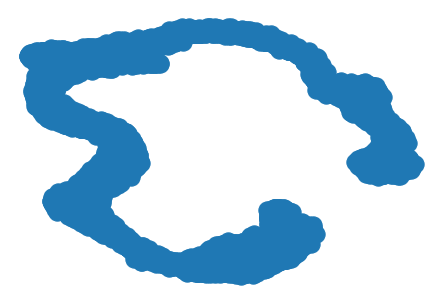

In [42]:
# This the new version (5/18) of the method to find the centerline points
# The total number of iterations
moved_count = []
for iteration in range(3):
    H_ini = 17
    H_delta = 5
    H_glo = 0
    trial_limit = 10
    min_neighbors = 60 + iteration * 25
    max_neighbors = 850
    curMoved = 0
  
    # We will move all the points for each iteration
    for targetPoint in range(len(pointsCor3D_base)):
        H_glo = H_ini
        trial = 0
        neighborsCor = []
        
        while(len(neighborsCor) < min_neighbors and trial < trial_limit and not len(neighborsCor) > max_neighbors):
            neighborsCor = collectPointsLite(targetPoint, H_glo, 2*H_glo)
            H_glo += H_delta
            trial += 1
            
        if(trial < trial_limit):
            moveVec = getMoveVec(pointsCor3D_base[targetPoint], neighborsCor)   
            print(targetPoint, "trial:",trial,len(neighborsCor))
            print(moveVec)
            vecLen = np.linalg.norm(moveVec);

            if(vecLen > H_glo/5):
                pointsCor3D_moved[targetPoint] = moveVec.tolist() + pointsCor3D_base[targetPoint]
                print("Moved!", vecLen, ">", H_glo/5)
                curMoved += 1
                
            else:
                print("Not Moved!", vecLen, "<", H_glo/5)
        else:
            print("Overflow!")
    
    curNeighborDis = 20
    first_flag = True
    
    while (first_flag or not nx.is_connected(graph_base)):
    
        if(first_flag):
            first_flag = False
            
        (graph_base, pointsCor3D_moved) = getMSTFromDataPoint(pointsCor3D_moved, drawMST=True, sampleNumber=len(pointsCor3D_base), maxNeighborDis=curNeighborDis)
        curNeighborDis *= 2 
        
    pointsCor3D_base = copy.deepcopy(pointsCor3D_moved)
    displayPoints(pointsCor3D_moved, 0.5)
    moved_count.append(curMoved)
print(moved_count)


In [32]:
displayPoints(pointsCor3D_moved, 0.5)    

In [ ]:
# the code to move points toward the centerline 
points_centerline = []

# The total number of iterations
for iteration in range(2):
    points_centerline = []
    H_ini = 40
    H_delta = 5
    H_glo = 0
    trial_limit = 18
    min_neighbors = 100
    max_neighbors = 850
    correlation_threshold = 0.2 + iteration*0.05
    weight_dict = {}
    distance_dict = {}

    # Set up a dirty dictionary to record the points that has been moved
    dirty_dict = {}
    for point in range(len(pointsCor3D)):
        dirty_dict[point] = 0
    
    # We will move 750 points of all the points for each iteration
    for targetPoint in range(3000, 4000):
        
        cur_correlation = 0
        H_glo = H_ini
        trial = 0
        correlation_hist = []
        localPointsCor2D_hist = []
        planeInfo = 0
        localPointsCor2D = []
        curPlaneGuess = [1, 1, 1, 1]
        # The next two lines are used in a dynamic programming version of computing the centerline
        #curScalar = np.zeros(10)
        #curALen = 0
        
        # if the correlation of the local points is not sufficient or the number of the local points is not sufficient
        # enlarge H_glo and find neighbors again  
        while(cur_correlation < correlation_threshold and len(localPointsCor2D) < max_neighbors \
               and trial < trial_limit):
        
            
            localPointsCor2D, planeInfo = get2DCorFrom3D(targetPoint)            
            slope, intersept = calculateRegressionLine(localPointsCor2D)
            rotatedPointsCor = rotatePointsCor(localPointsCor2D, slope)
            cur_correlation = abs(np.corrcoef(rotatedPointsCor[:, 0],rotatedPointsCor[:, 1])[0][1])
            print(targetPoint, "trial",str(trial), "H =", H_glo, ":" , str(cur_correlation), \
                  "size:", len(localPointsCor2D))
            H_glo += H_delta
            trial += 1
            correlation_hist.append(cur_correlation)
            localPointsCor2D_hist.append(copy.deepcopy(localPointsCor2D))
            
            
        localPointsCor2D = localPointsCor2D_hist[correlation_hist.index(max(correlation_hist))]
        centerPoint2D = np.asarray(localPointsCor2D)[:1, :2]
        newCor = Moving_Least_Square(centerPoint2D[0], np.asarray(localPointsCor2D)[:, :2])
        newCor3D = get3DCorFrom2D(newCor, planeInfo)
        print(pointsCor3D[targetPoint], newCor3D)
        
        if(distance.euclidean(newCor3D, pointsCor3D[targetPoint]) < 80):
            pointsCor3D[targetPoint] = list(newCor3D)
            dirty_dict[targetPoint] = 1
            points_centerline.append(newCor3D)
            

        
    displayPoints(points_centerline, 0.5)    

In [43]:
# Construct a MST only using the 750 points modified above
#(graph_centerline, pointsCor3D_centerline) = getMSTFromDataPoint(pointsCor3D_base, drawMST=True, sampleNumber=len(pointsCor3D_base), maxNeighborDis=80)

graph_centerline = graph_base
pointsCor3D_centerline = pointsCor3D_moved

if(not nx.is_connected(graph_centerline)):
    raise Exception('the raw centerline points cannot form a connected MST, raise maxNeighborDis and try again!')


# constantly delete the node that only has one edge, until there are only two nodes only having one edge left,
# both of them are the endpoints of one singal path representing the colon

toRemove = []
removeCount = 0
removedNodeDict = defaultdict(list)

print("MST has", len(pointsCor3D_centerline), "nodes. Now begin to trim the graph.")

while (True):
    toRemove = []
    for node in graph_centerline.nodes():
        if(len(graph_centerline.edges(node)) == 1):
            removedNodeDict[list(graph_centerline.edges(node))[0][1]].append(node)
            toRemove.append(node)
    if(len(toRemove) == 2):
        break
    for node in toRemove:
        graph_centerline.remove_node(node)
        removeCount += 1
        toRemove = []
        
        
endpoints = toRemove
print("Done! Trimed", removeCount, "nodes. Now MST has", len(graph_centerline.nodes), "nodes left.")

print("Now begin reconstruct endpoints")
# now add back the nodes that got deleted during the triming
addBackChildren(endpoints[0], 0)
addBackChildren(endpoints[1], 0)

print("Done! Now MST has", len(graph_centerline.nodes), "nodes left.")

# Displat the points on the centerline

to_display = []
for node in graph_centerline.nodes:
    to_display.append(pointsCor3D_centerline[node])
displayPoints(to_display, 1.3)

# check if there is more than 2 endpoints
new_endpoints = []
for node in graph_centerline.nodes:
    if(len(graph_centerline.edges(node)) == 1):
       new_endpoints.append(node)
if(len(new_endpoints) != 2):
    print("Fatal error: multiple endpoints detected!")

# check if there is more than 2 path
path = list(nx.all_simple_paths(graph_centerline, source=new_endpoints[0], target=new_endpoints[1]))
if(len(path) != 1):
    print("Fatal error: multiple path detected!")
    
pointsInorder = path[0]

MST has 7000 nodes. Now begin to trim the graph.
Done! Trimed 5555 nodes. Now MST has 1445 nodes left.
Now begin reconstruct endpoints
Done! Now MST has 1751 nodes left.


In [51]:
pointsCorInorder = []
for point, index in zip(pointsInorder, range(len(pointsInorder))):
    pointsCorInorder.append([pointsCor3D_centerline[point], index])

samplePointsCorInorder = np.asarray(sample(pointsCorInorder, int(len(pointsCorInorder)/2)))
samplePointsCorInorder = sorted(samplePointsCorInorder, key=lambda x:x[1])
samplePointsCorInorder = [x[0] for x in samplePointsCorInorder]
                        
displayPoints(samplePointsCorInorder, 1.3)

In [52]:
np.savetxt("6_3_1_centerpoints_2016.csv", samplePointsCorInorder, delimiter=" ")
np.save("6_3_1_centerpoints_2016", samplePointsCorInorder)